# Import and Read

In [1]:
# wide screen
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [3]:
import math
import torch

import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import xgboost as xgb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from random import randint
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [4]:
df = pd.read_csv('./data/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']

In [5]:
df.loc[8314:65671, 'Ebeam'] = 5.754

In [6]:
df['phi'] = df.phi.apply(lambda x: math.radians(x))

# Preprocessing (remove soft dups)

In [6]:
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

In [10]:
# Creating a Data Set
class PhysicsDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

In [11]:
feature_data = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
label_data = df['dsigma_dOmega']

# Splitting Data into Train and Test

scaler_feature = StandardScaler()
scaler_target = StandardScaler()
feature_data = scaler_feature.fit_transform(feature_data)
label_data = scaler_target.fit_transform(label_data.values.reshape(-1,1))

train_feature_data, test_feature_data, train_label_data, test_label_data = train_test_split(feature_data, label_data, test_size=0.2, random_state=42)


# Creating Data Loaders
train_dataset = PhysicsDataSet(train_feature_data, train_label_data)
test_dataset = PhysicsDataSet(test_feature_data, test_label_data)

train_loader = DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False)

# FCNN

In [13]:
input_dim = 5
hidden_dim_1 = 60
hidden_dim_2 = 80
hidden_dim_3 = 100
hidden_dim_4 = 120
hidden_dim_5 = 140
hidden_dim_6 = 100
hidden_dim_7 = 80
hidden_dim_8 = 60
output_dim = 1

num_epochs = 5000
early_stop_cond = 0.001
epoch_early_stop = 10
lr=0.0001

In [14]:
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim_1),
    nn.ReLU(),
    nn.Linear(hidden_dim_1, hidden_dim_2),
    nn.ReLU(),
    nn.Linear(hidden_dim_2, hidden_dim_3),
    nn.ReLU(),
    nn.Linear(hidden_dim_3, hidden_dim_4),
    nn.ReLU(),
    nn.Linear(hidden_dim_4, hidden_dim_5),
    nn.ReLU(),
    nn.Linear(hidden_dim_5, hidden_dim_6),
    nn.ReLU(),
    nn.Linear(hidden_dim_6, hidden_dim_7),
    nn.ReLU(),
    nn.Linear(hidden_dim_7, hidden_dim_8),
    nn.ReLU(),
    nn.Linear(hidden_dim_8, output_dim)
)

# Training the Model
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    train_loader = DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True)
    for feature, label in train_loader:
        optimizer.zero_grad()
        outputs = model(feature.to(torch.float32))
        loss = criterion(outputs.to(torch.float32), label.to(torch.float32))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))
    if epoch > epoch_early_stop and abs(epoch_loss - last_loss) < early_stop_cond:
        break
    last_loss = epoch_loss

Epoch: 10/5000, Loss: 823.1084
Epoch: 20/5000, Loss: 613.9641
Epoch: 30/5000, Loss: 477.3203
Epoch: 40/5000, Loss: 428.2101
Epoch: 50/5000, Loss: 410.6135
Epoch: 60/5000, Loss: 385.8868
Epoch: 70/5000, Loss: 369.6599
Epoch: 80/5000, Loss: 355.3543
Epoch: 90/5000, Loss: 356.7788
Epoch: 100/5000, Loss: 339.9211
Epoch: 110/5000, Loss: 337.7834
Epoch: 120/5000, Loss: 329.5706
Epoch: 130/5000, Loss: 325.1095
Epoch: 140/5000, Loss: 317.2125
Epoch: 150/5000, Loss: 311.4150
Epoch: 160/5000, Loss: 309.2064
Epoch: 170/5000, Loss: 304.9872
Epoch: 180/5000, Loss: 298.6841
Epoch: 190/5000, Loss: 299.5058
Epoch: 200/5000, Loss: 294.7470
Epoch: 210/5000, Loss: 289.5523
Epoch: 220/5000, Loss: 281.9359
Epoch: 230/5000, Loss: 280.7768
Epoch: 240/5000, Loss: 268.9727
Epoch: 250/5000, Loss: 268.8771
Epoch: 260/5000, Loss: 263.9787
Epoch: 270/5000, Loss: 257.7582
Epoch: 280/5000, Loss: 258.3294
Epoch: 290/5000, Loss: 256.2435
Epoch: 300/5000, Loss: 244.7823
Epoch: 310/5000, Loss: 243.5927
Epoch: 320/5000, 

Epoch: 2580/5000, Loss: 54.8098
Epoch: 2590/5000, Loss: 54.9019
Epoch: 2600/5000, Loss: 56.3818
Epoch: 2610/5000, Loss: 52.6800
Epoch: 2620/5000, Loss: 55.8404
Epoch: 2630/5000, Loss: 55.0136
Epoch: 2640/5000, Loss: 52.9532
Epoch: 2650/5000, Loss: 54.2359
Epoch: 2660/5000, Loss: 61.0164
Epoch: 2670/5000, Loss: 55.0073
Epoch: 2680/5000, Loss: 52.1202
Epoch: 2690/5000, Loss: 69.3511
Epoch: 2700/5000, Loss: 53.9022
Epoch: 2710/5000, Loss: 50.7254
Epoch: 2720/5000, Loss: 52.5803
Epoch: 2730/5000, Loss: 52.7965
Epoch: 2740/5000, Loss: 68.6045
Epoch: 2750/5000, Loss: 51.4179
Epoch: 2760/5000, Loss: 57.4837
Epoch: 2770/5000, Loss: 53.8687
Epoch: 2780/5000, Loss: 53.3756
Epoch: 2790/5000, Loss: 56.7581
Epoch: 2800/5000, Loss: 53.1017
Epoch: 2810/5000, Loss: 54.7020
Epoch: 2820/5000, Loss: 52.3563
Epoch: 2830/5000, Loss: 52.7236
Epoch: 2840/5000, Loss: 52.0038
Epoch: 2850/5000, Loss: 51.0246
Epoch: 2860/5000, Loss: 50.3434
Epoch: 2870/5000, Loss: 52.0336
Epoch: 2880/5000, Loss: 54.0492
Epoch: 2

In [17]:
# Testing the Model
test_loss = 0.0
with torch.no_grad():
    for feature, label in test_loader:
        outputs = model(feature.to(torch.float32))
        loss = criterion(outputs.to(torch.float32), label.to(torch.float32))
        test_loss += loss.item()

print('Test Loss: {:.4f}'.format(test_loss))

Test Loss: 100.1490


In [20]:
torch.save(model, './models/7_desc_layers_3k')

In [30]:
# model = torch.load('./models/5_60_layers')

# Validations

In [18]:
def interpol_check(df, number):
    example = df.iloc[number][['Ebeam', 'W', 'Q2', 'cos_theta']]
    
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.W == example['W'])&
                       (df.Q2 == example['Q2'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')
    
    df_example_set_for_prediction = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'W' : [example['W'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'Q2' : [example['Q2'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'cos_theta' : [example['cos_theta'] for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

#     return df_example_set
    with torch.no_grad():
        dsigma_dOmega_predicted = scaler_target.inverse_transform(model(torch.tensor(scaler_feature.transform(df_example_set_for_prediction)).to(torch.float32)))
     
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 

    #input data 
    xdata = df_example_set.phi
    ydata = df_example_set.dsigma_dOmega 

    #fitting the data 
    popt, pcov = curve_fit(func_cos, xdata, ydata) 

    a, b, c = popt[0], popt[1], popt[2]
    #print the fitted parameters 
    print("a = %s , b = %s, c = %s" % (a, b, c))
    phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
    dsigma_dOmega_theory = [func_cos(x, a, b, c) for x in phi_theory]
    
    plt.figure(figsize=(22, 6), dpi=80)
    plt.plot(phi_theory, 
             dsigma_dOmega_theory, 
             label=f'fitted a + b*cos(2*x) + c*cos(x) function')
    plt.plot(df_example_set_for_prediction.phi, 
             dsigma_dOmega_predicted, 
             color='green', label=f'predicted')
    plt.scatter(x=df_example_set.phi, 
                y=df_example_set.dsigma_dOmega, 
                color='red', marker='*', label=f"real_data with params Ebeam: {example['Ebeam']}, W: {example['W']}, Q2: {example['Q2']}, cos_theta: {example['cos_theta']}")
    
    plt.xlabel("phi: rad")
    plt.ylabel("dsigma_dOmega: barn")
    
    plt.legend()
    plt.show()

a = 0.08540416670045271 , b = -0.022772978619187572, c = 0.026425169163887555


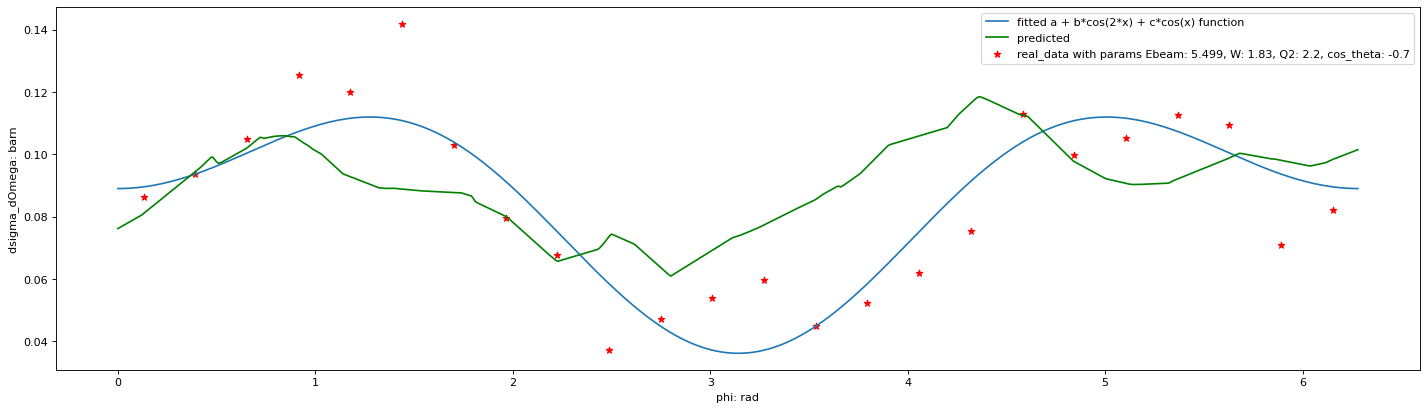

a = 0.2754580110208795 , b = -0.1744036438181762, c = 0.009189210598153252


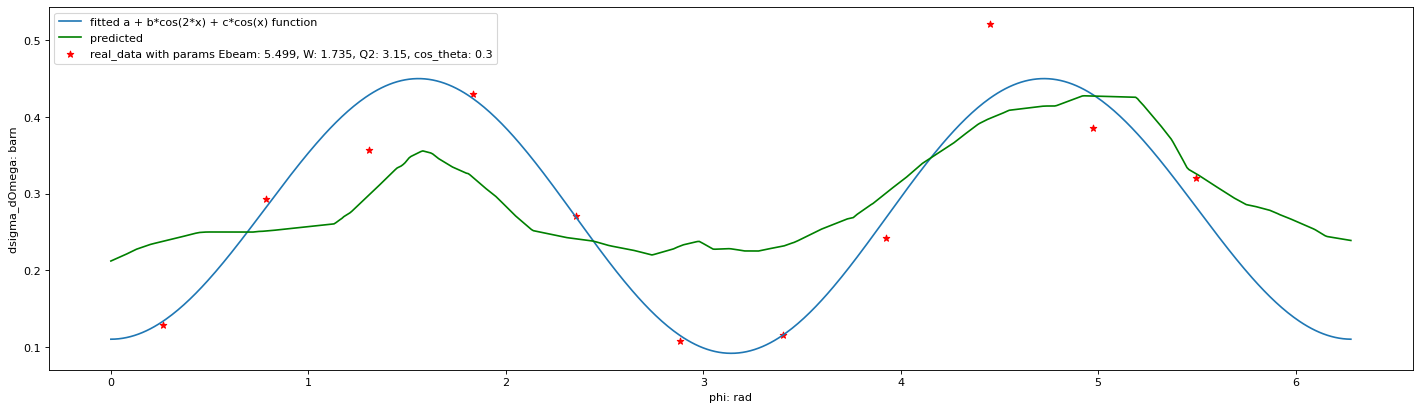

a = 0.24095300185341384 , b = -0.07321513077077224, c = -0.0063709933776834315


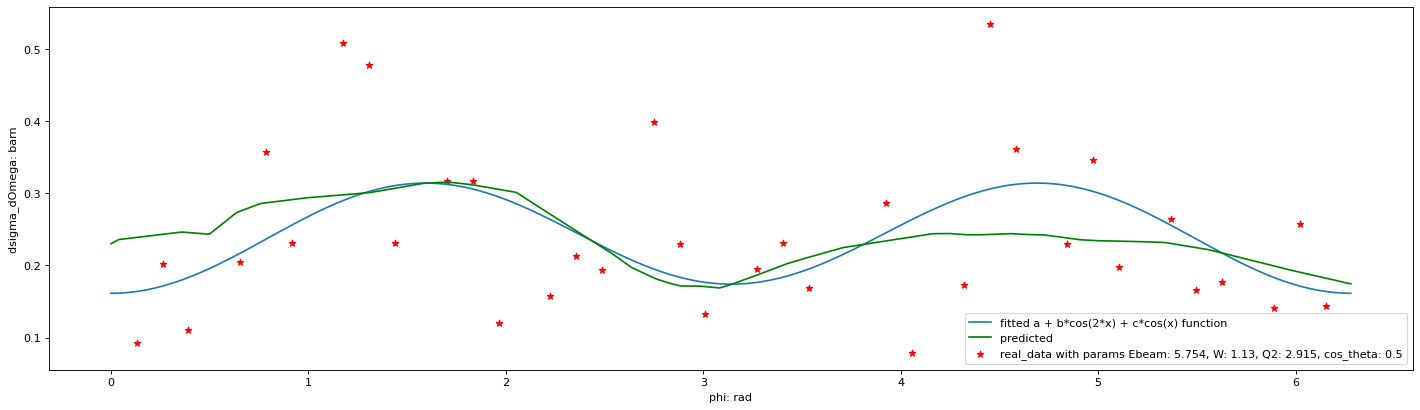

a = 0.8242404166666667 , b = -0.09928639882943467, c = 0.10521341181049067


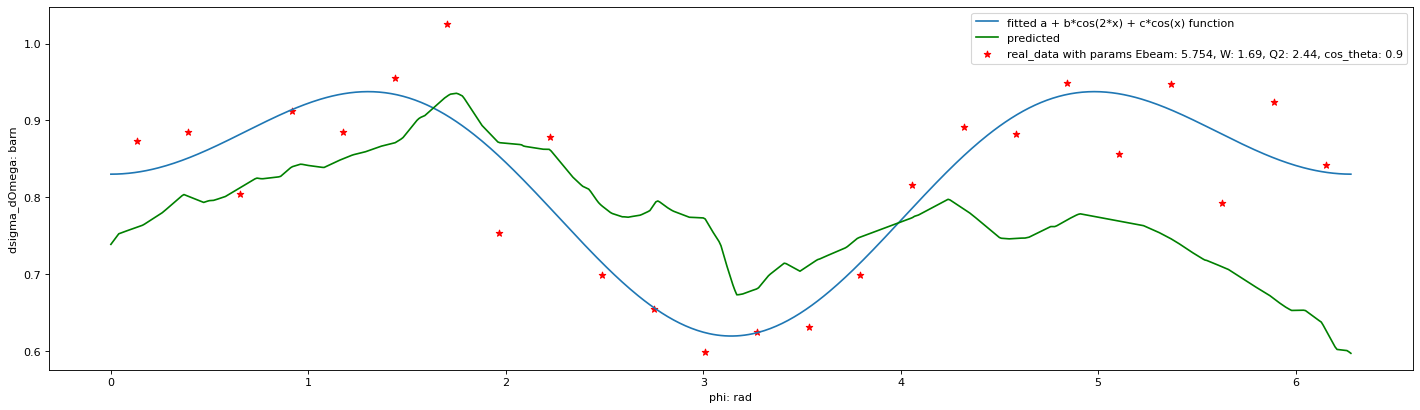

a = 1.6493133405344682 , b = -0.39426430114472943, c = 0.2358126989281679


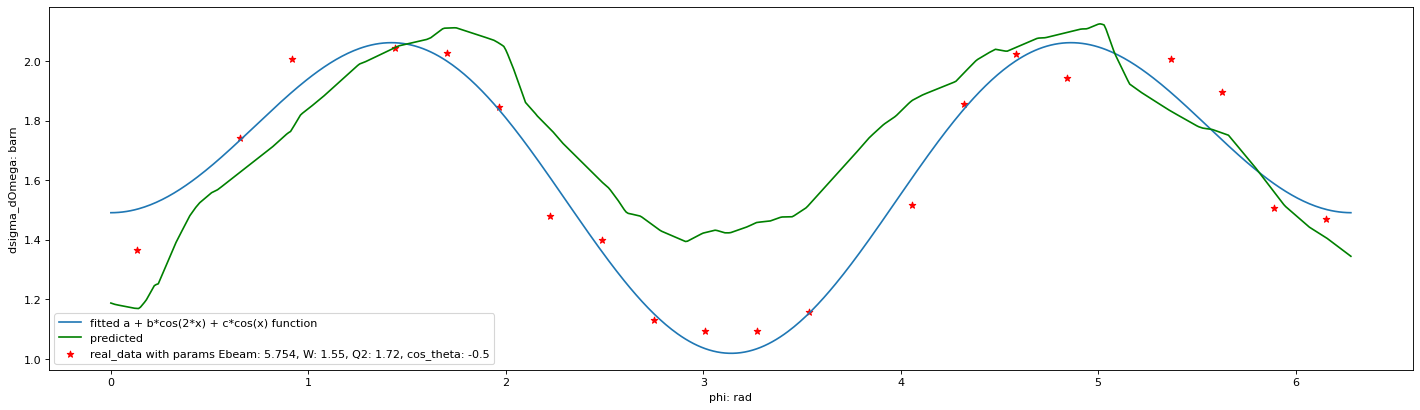

a = 0.48304549618047354 , b = -0.10795708814500404, c = 0.03943239633136873


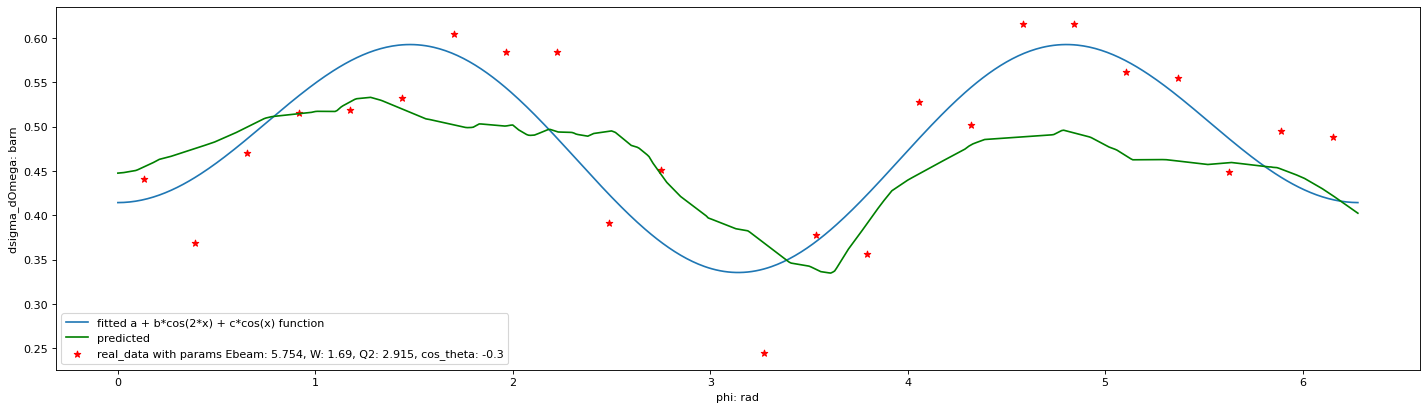

a = 0.4110945833480297 , b = 0.021253740141419564, c = -0.07205106513762514


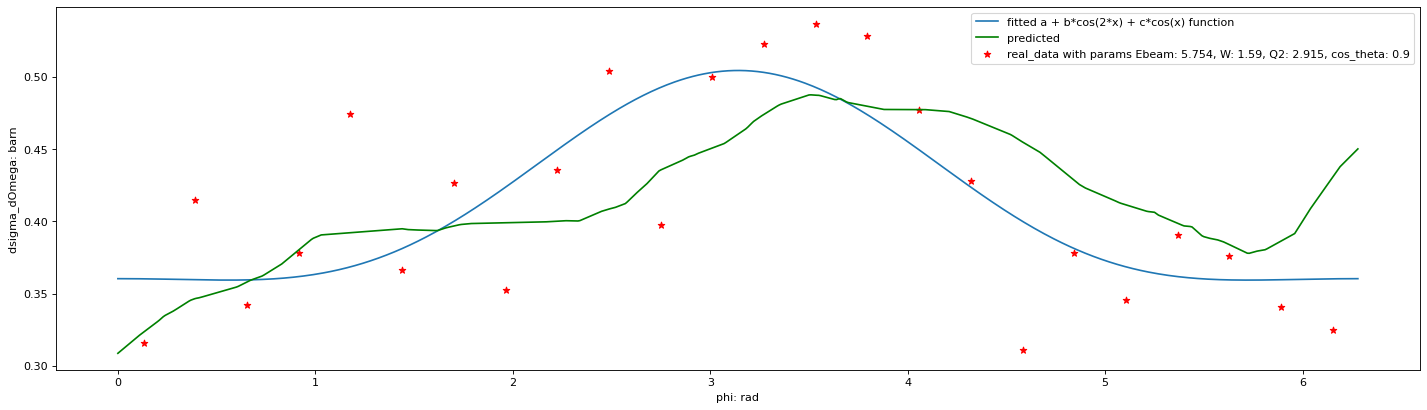

a = 0.06384282560078886 , b = -0.07002080858102018, c = 0.06105080657954332


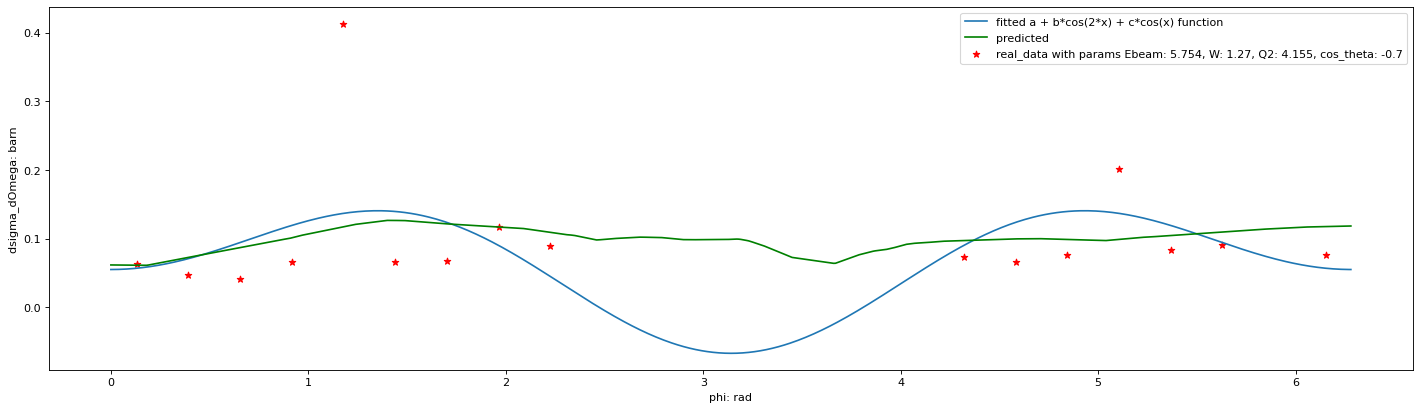

a = 1.7609508333333335 , b = -0.08366649096812481, c = -0.03384304162565456


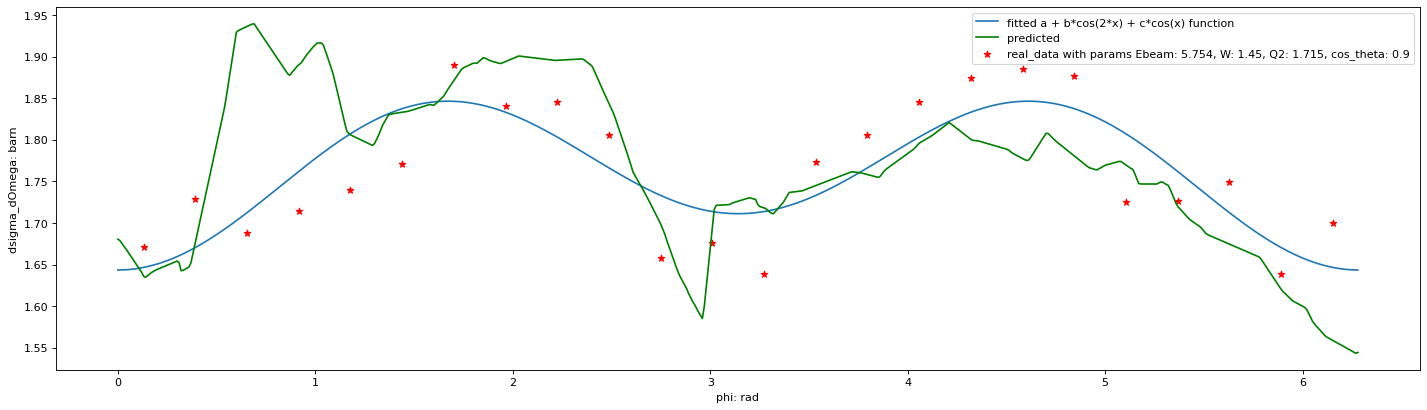

a = 0.1300674559296889 , b = -0.04132853818687328, c = 0.023004489480613833


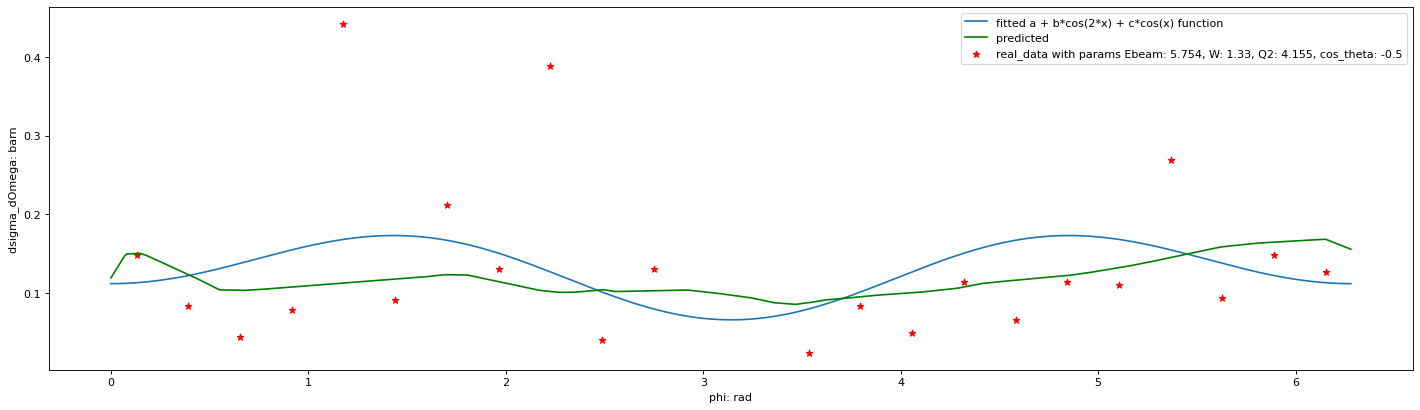

a = 1.051708220790345 , b = -0.10787426209286954, c = -0.07625829147193093


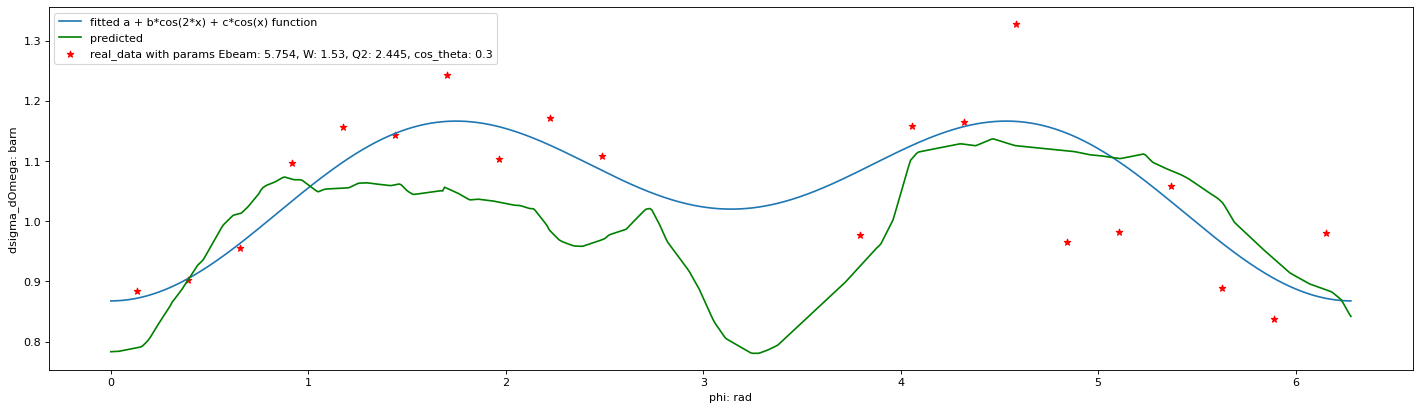

a = 0.5570254166666666 , b = -0.11356815942141833, c = 0.05154354629090628


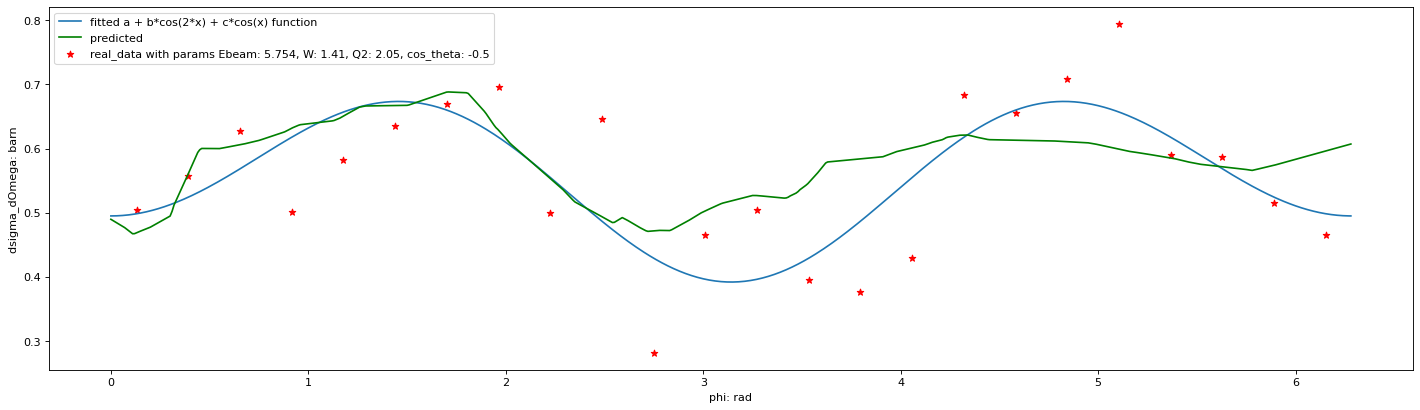

a = 8.31734152442626 , b = -3.6657758899930104, c = -2.195102976816373


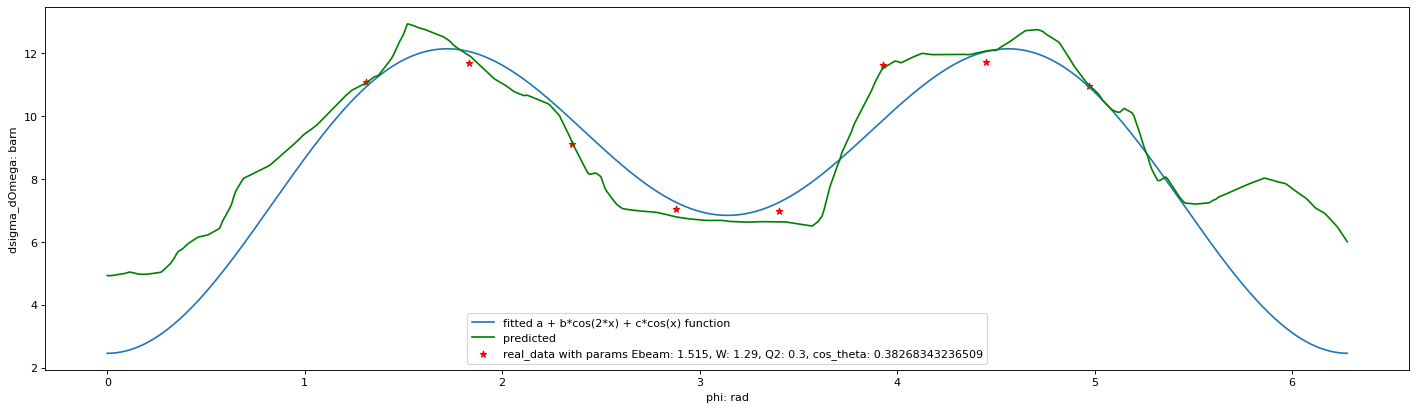

a = 0.8354428009267102 , b = -0.5132128430089313, c = 0.025922357365313453


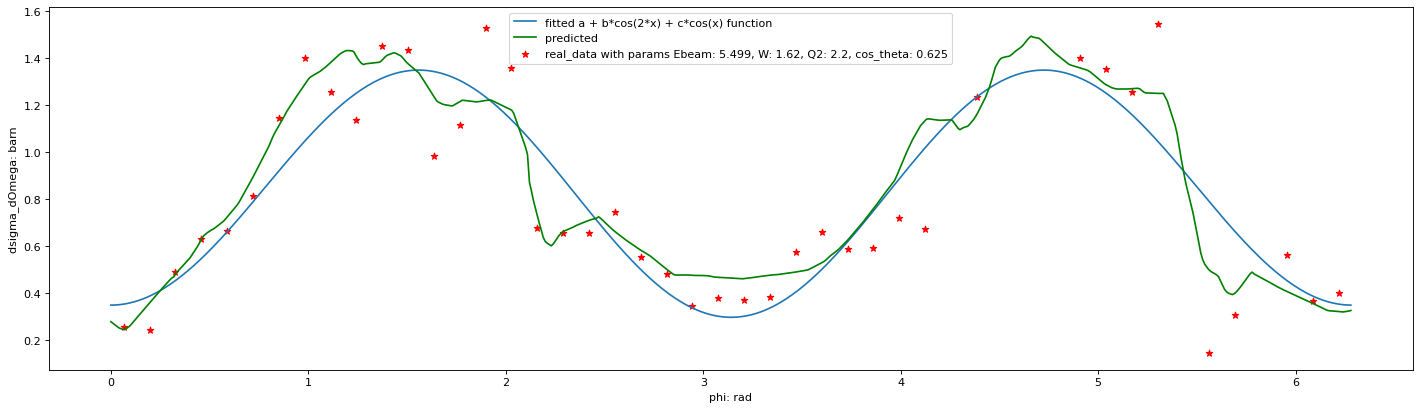

a = 0.5776583333333334 , b = -0.11223689294026144, c = -0.16082704719237473


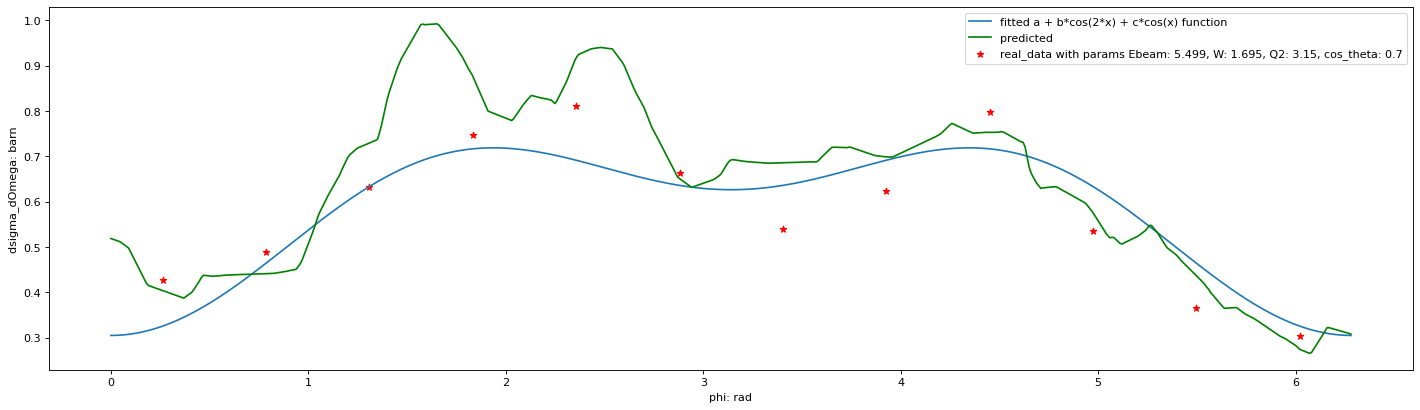

a = 1.049135638111497 , b = -0.038380810622867134, c = -0.00736917359840783


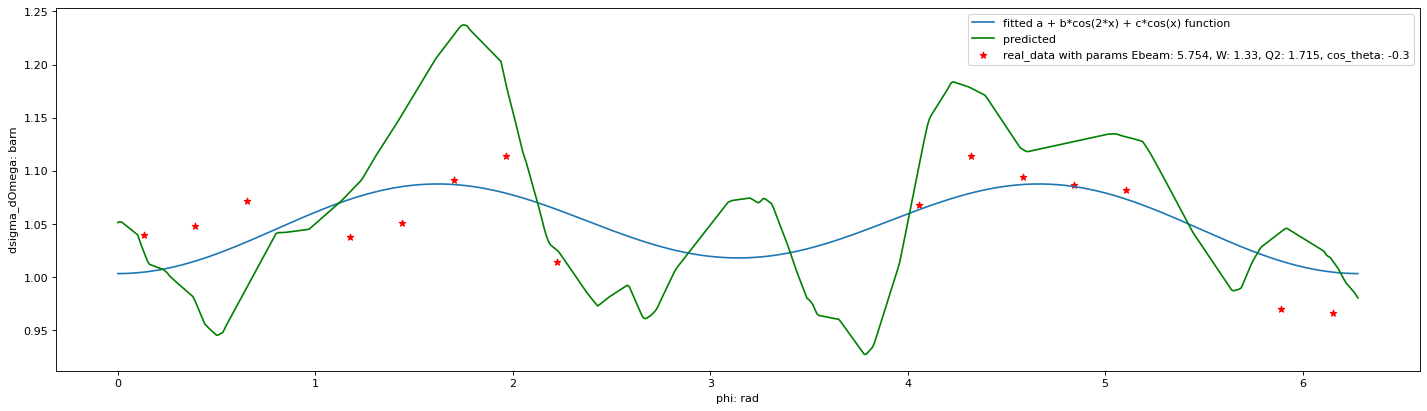

a = 3.843141777604902 , b = -0.5493918438123637, c = 0.3882246930623232


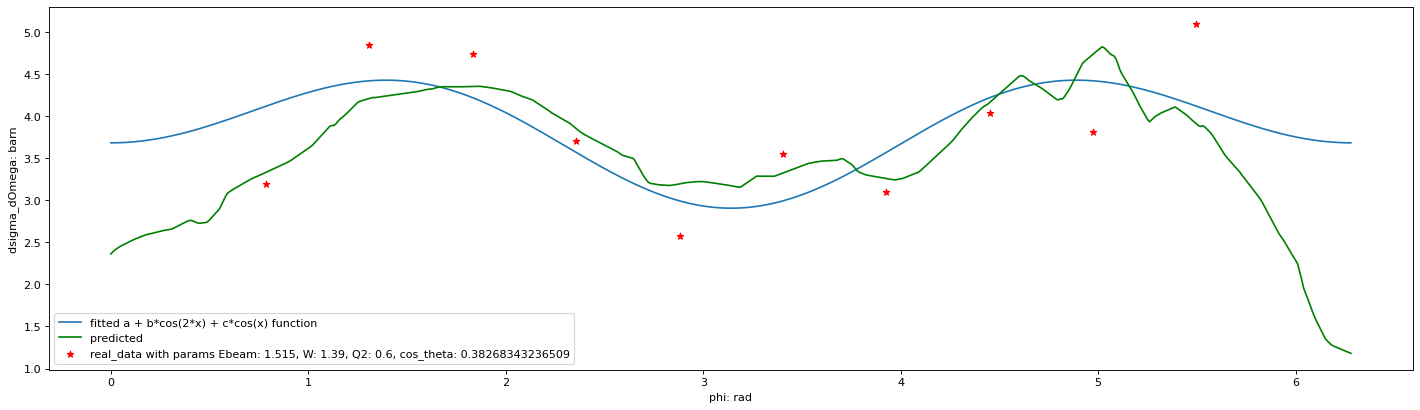

a = 0.1699530621534186 , b = -0.02247236361010203, c = 0.027121709827696804


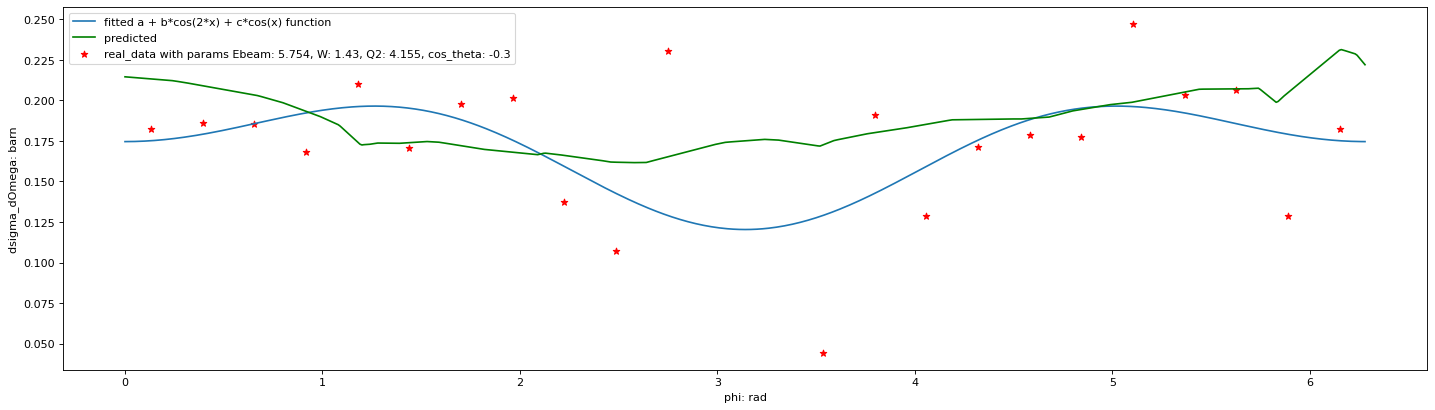

a = 3.135083333333333 , b = -1.334400809664522, c = -0.6694063315275225


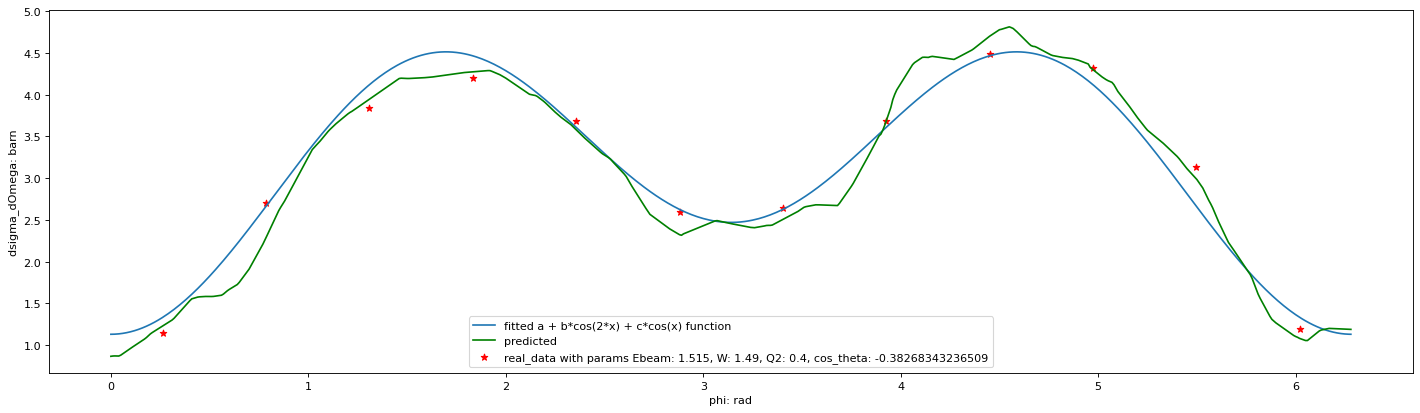

a = 0.9816308497396099 , b = -0.6085548072603495, c = -0.05822899519860458


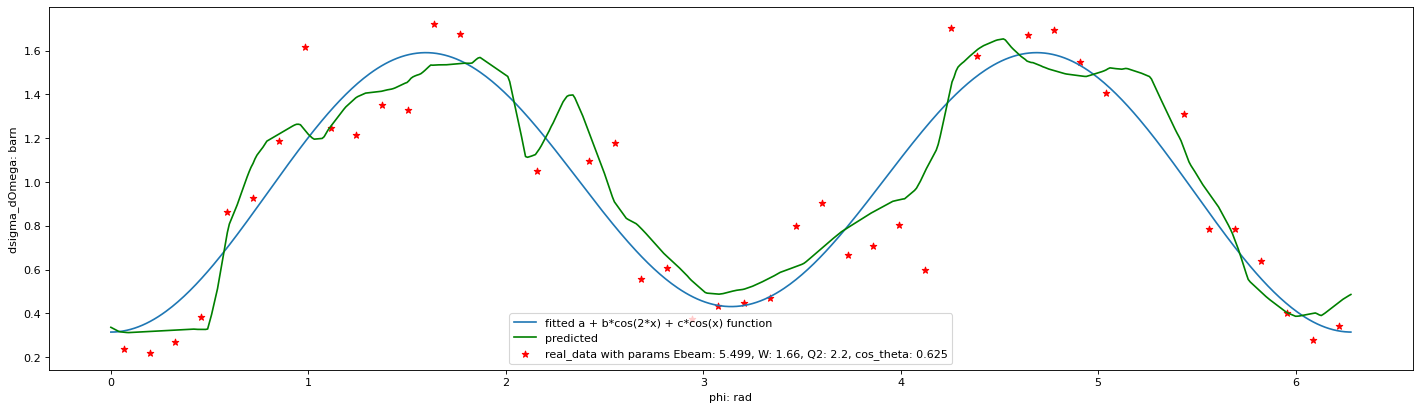

a = 0.40035675887549615 , b = -0.02883013994041944, c = 0.05465322082297463


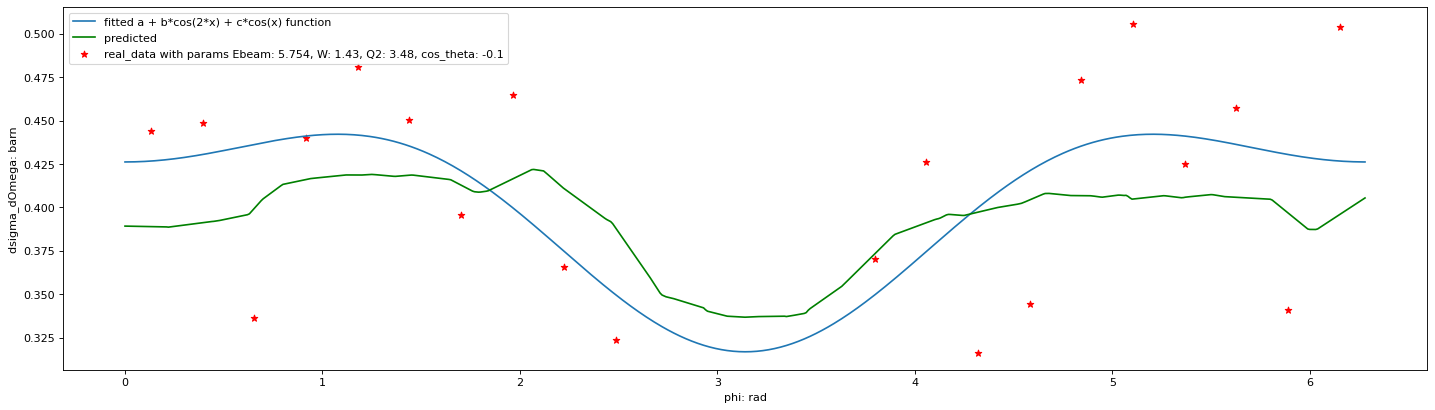

a = 0.42189023655514724 , b = -0.06940202663123107, c = 0.13640662771283837


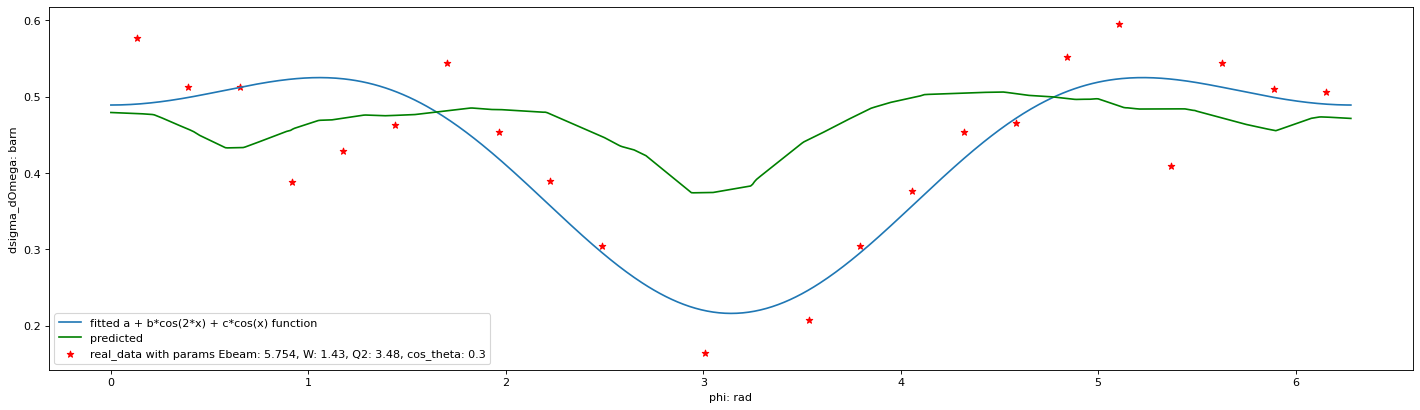

a = 0.5683820833333334 , b = -0.0533222520434625, c = 0.07341051240705435


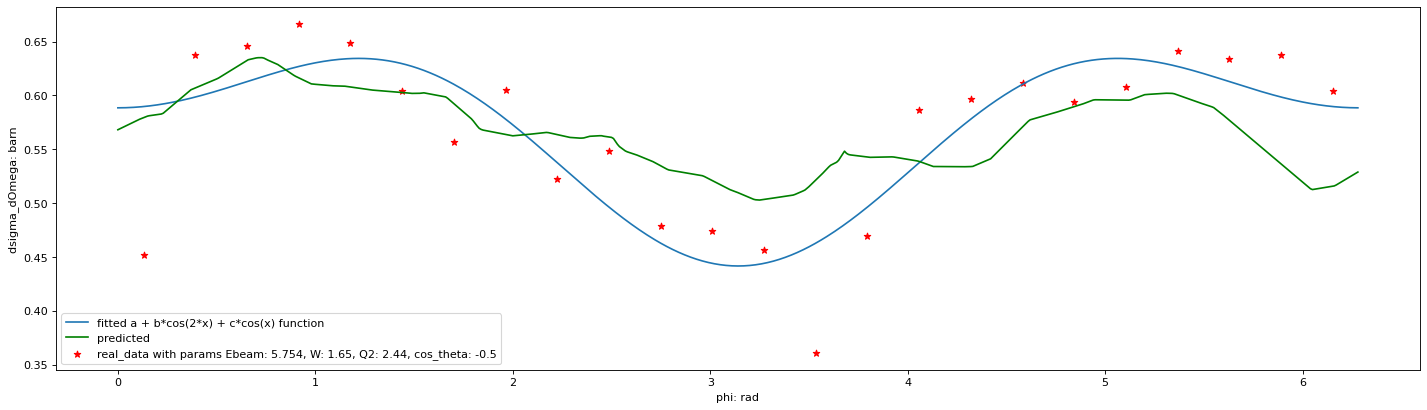

a = 0.48927846001033864 , b = -0.05851277958157131, c = 0.01567276767120049


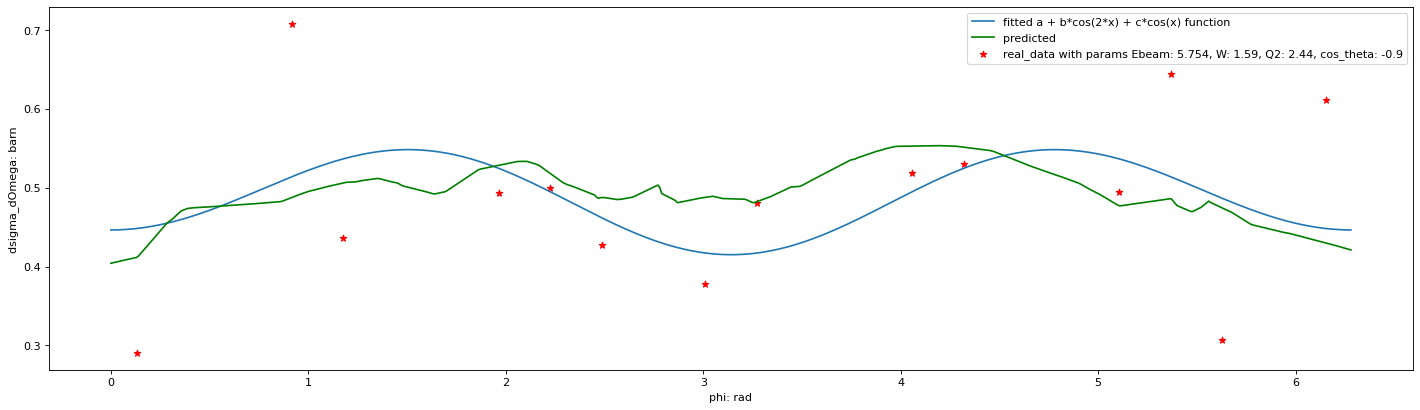

a = 0.9696396616783461 , b = -0.18902874265837855, c = -0.13562089894305898


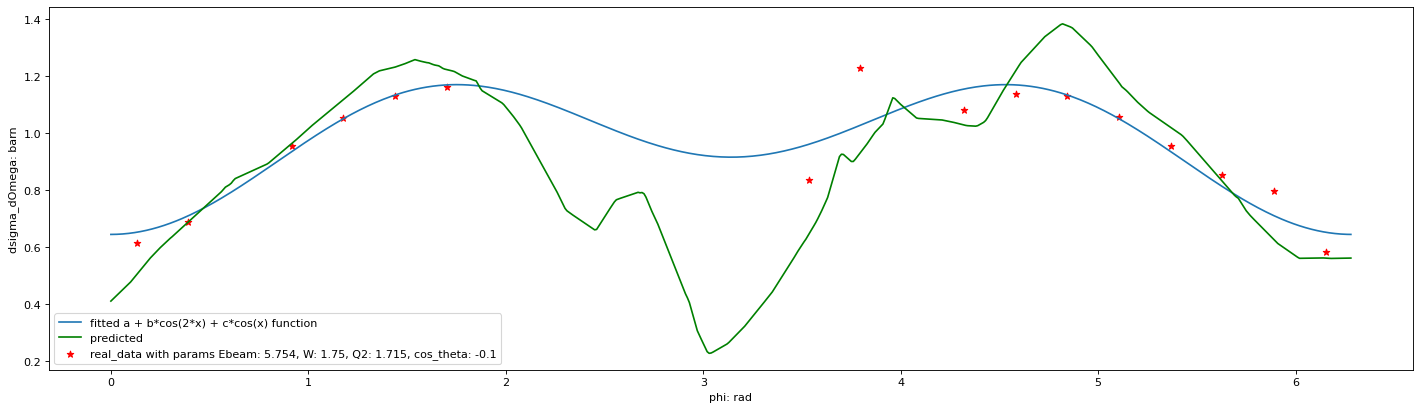

a = 0.6753012999059973 , b = -0.26740136318076524, c = 0.11755091116427564


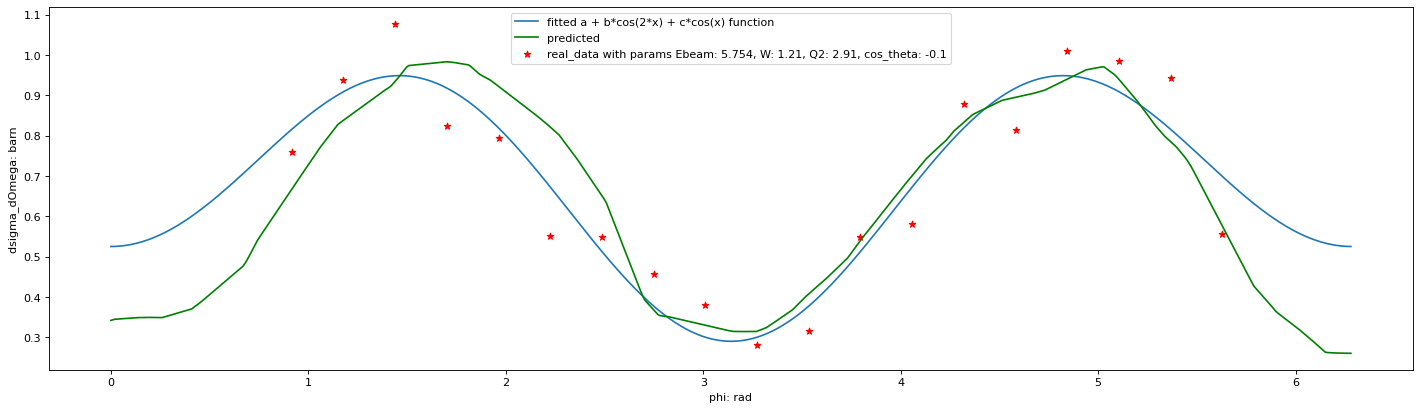

a = 0.9533416665586596 , b = -0.049751734849340735, c = -0.14114665287711423


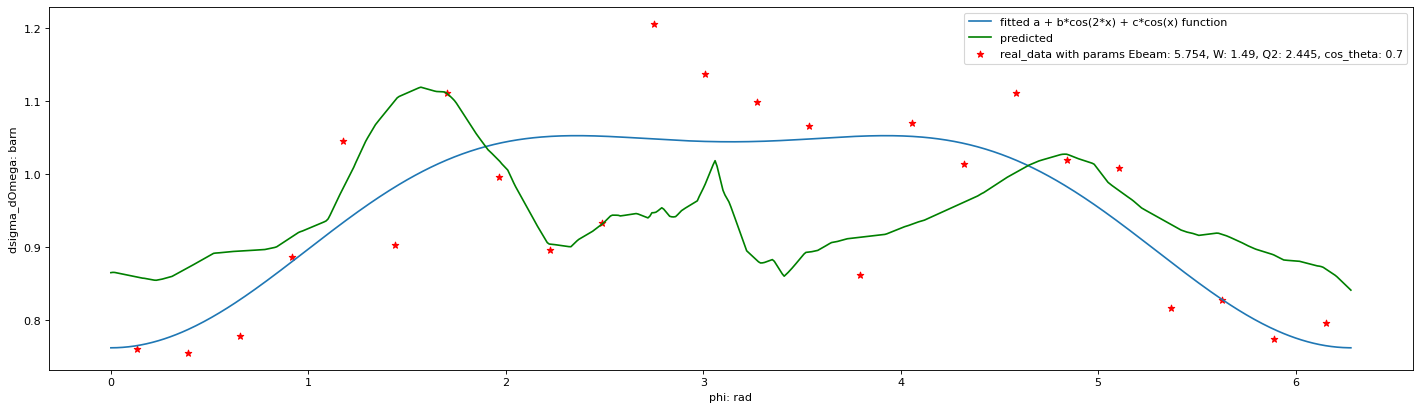

a = 0.6277833333750789 , b = 0.009901557116602058, c = -0.17820104104646006


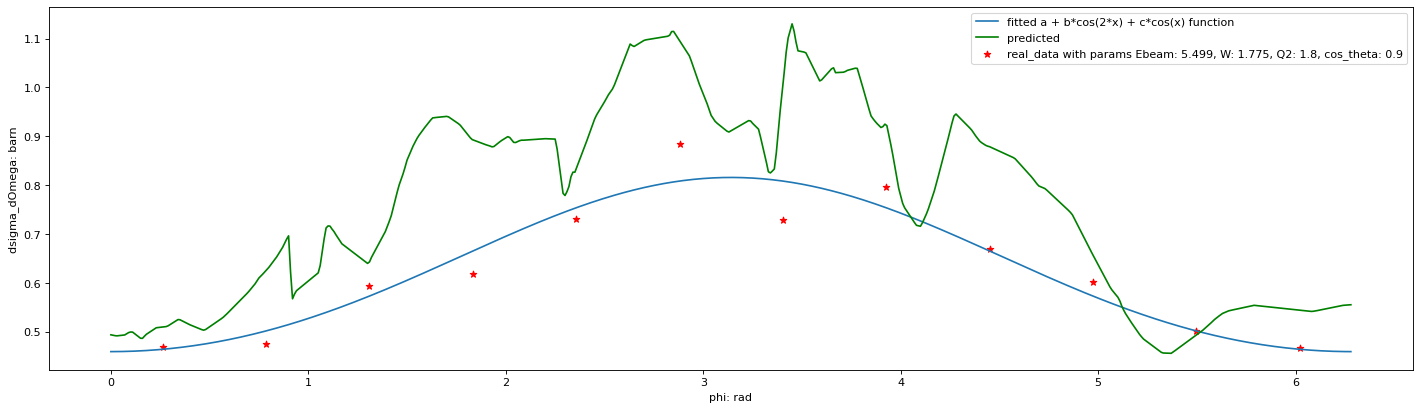

a = 0.7821258333388464 , b = -0.05831730943392428, c = 0.14513990656484066


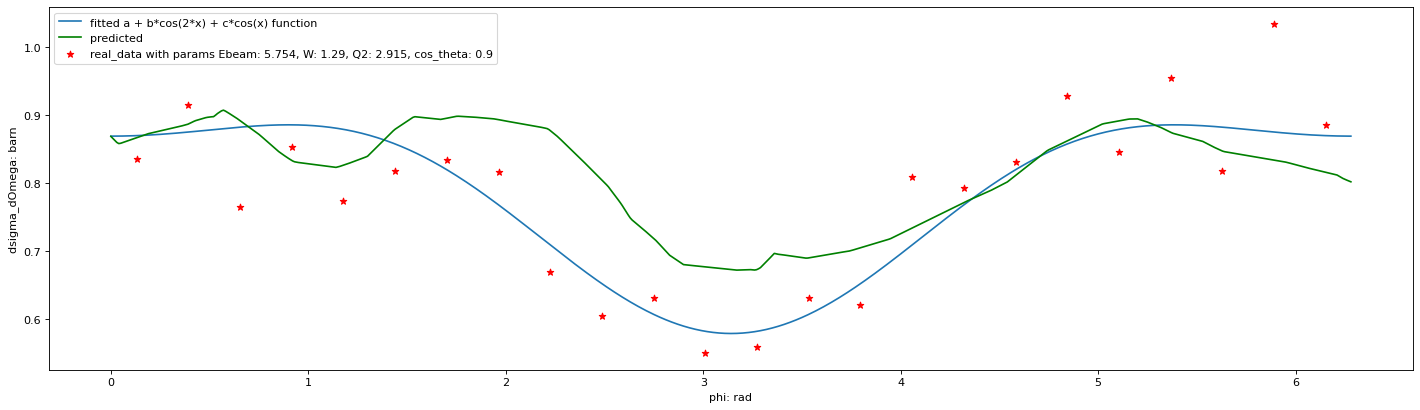

a = 0.3198670832868182 , b = -0.04155116129260792, c = -0.09471155747203049


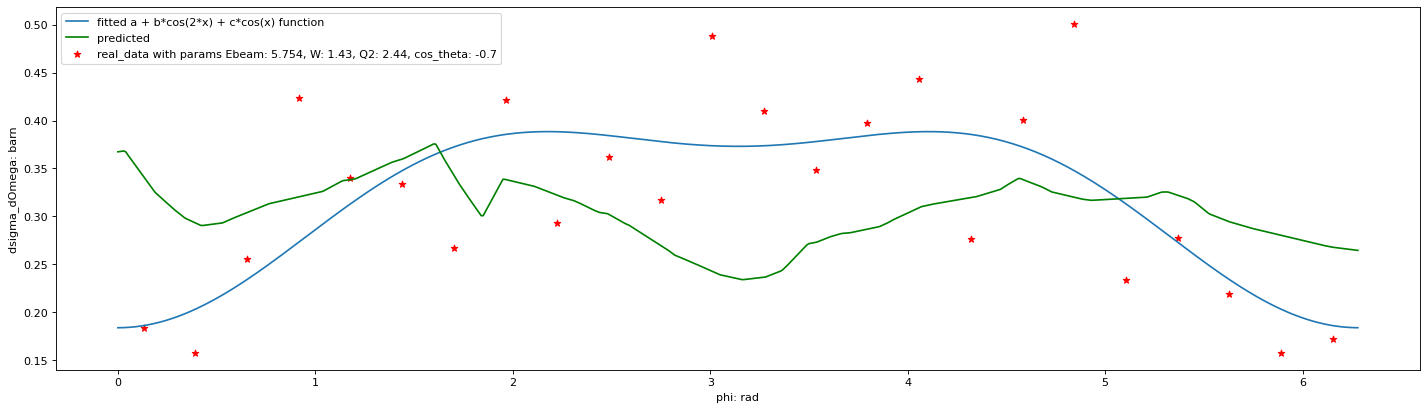

a = 0.33374458333333334 , b = 0.003155958713243993, c = -0.0034206407485918486


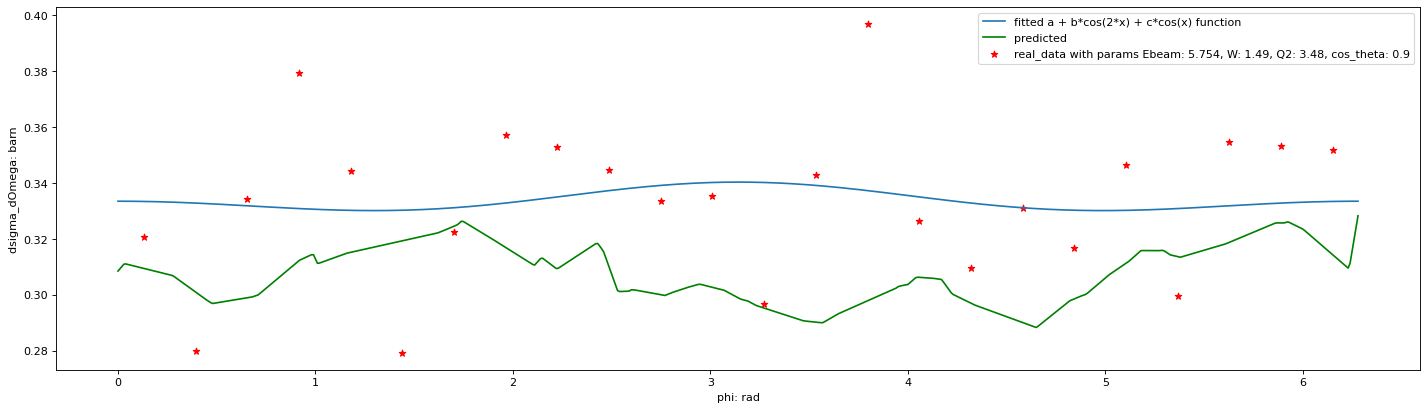

a = 0.7227963891997873 , b = -0.08876451934489182, c = 0.00498495870899196


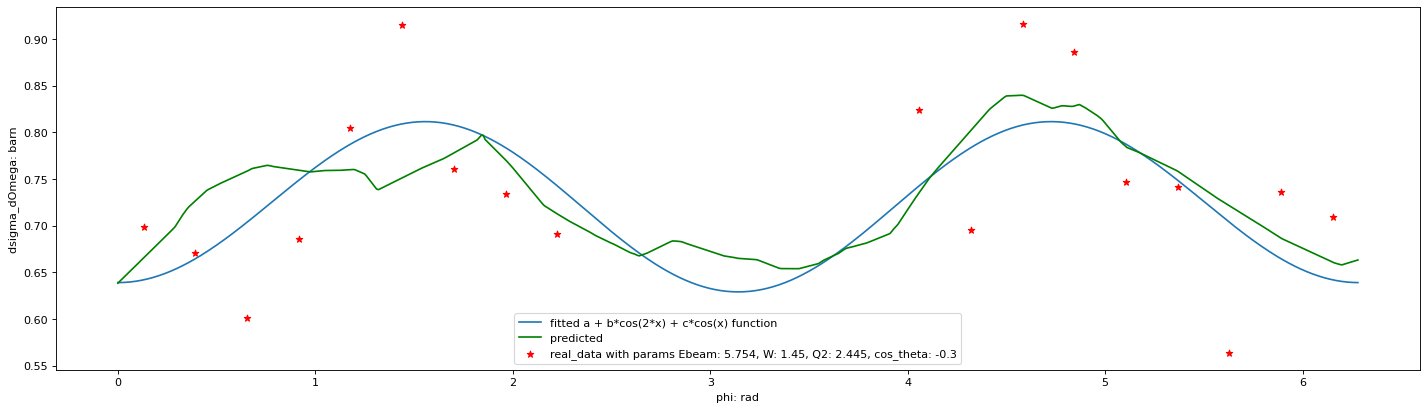

a = 6.4847071708952395 , b = -2.787198220089509, c = 1.5483182059424054


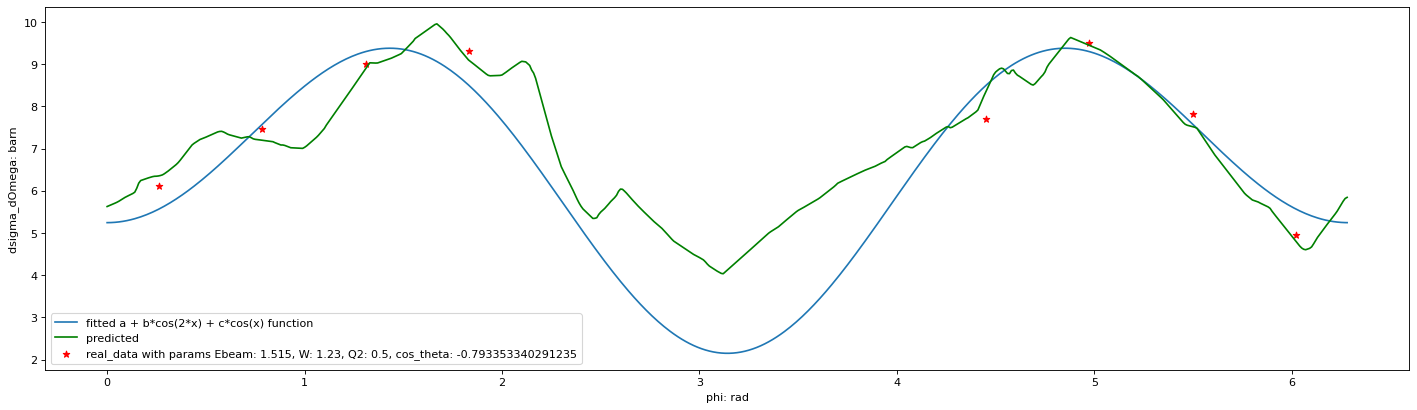

a = 0.16239038535497974 , b = 0.0013174057625668922, c = -0.01338174441721085


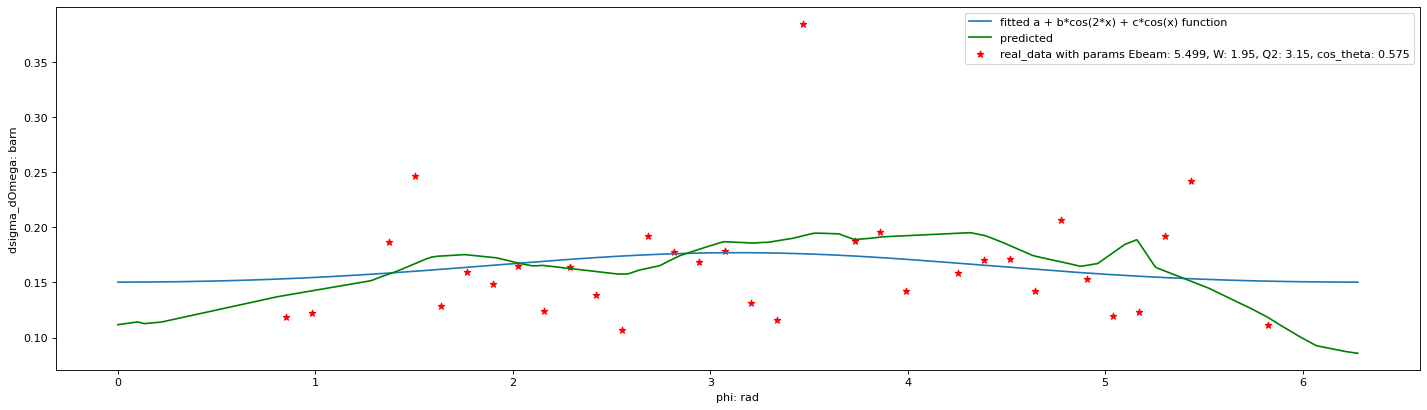

a = 0.2295032190401227 , b = -0.0016474010087333922, c = -0.010741767740638276


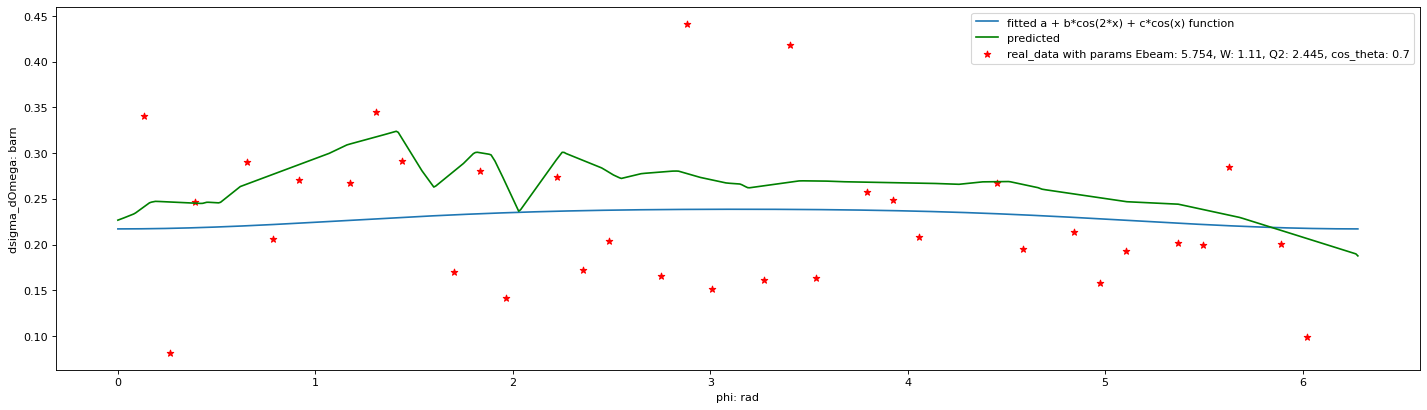

a = 0.5570254166666666 , b = -0.11356815942141833, c = 0.05154354629090628


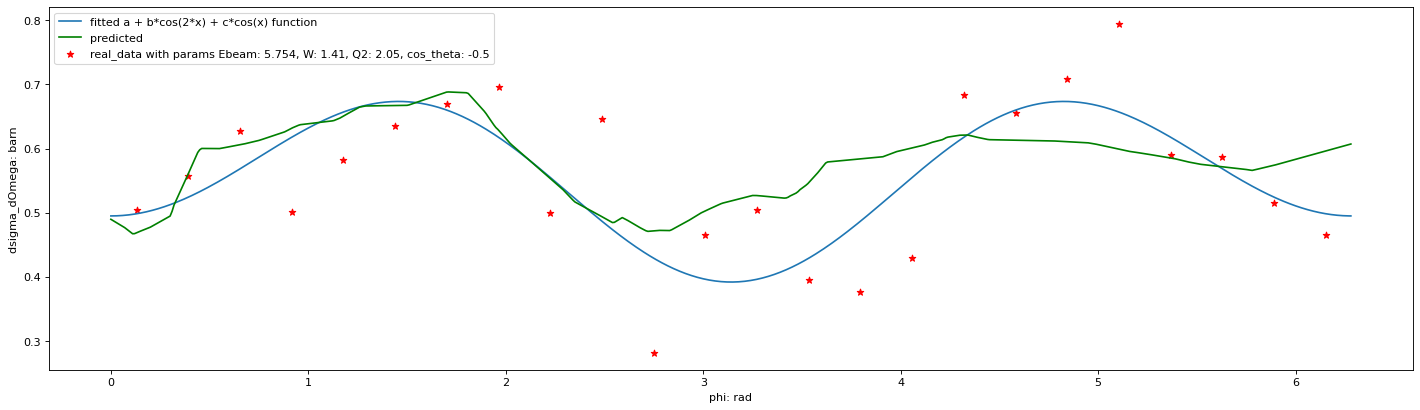

a = 0.2958319596918124 , b = -0.1471143797726957, c = -0.17187432323284813


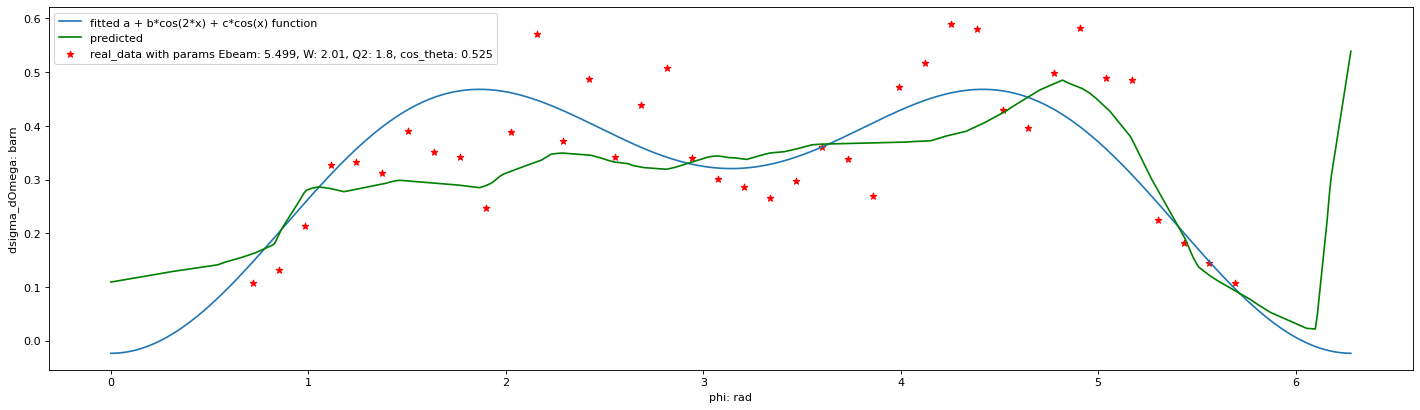

a = 0.255490029666792 , b = -0.04362491333410356, c = -0.006721257923611498


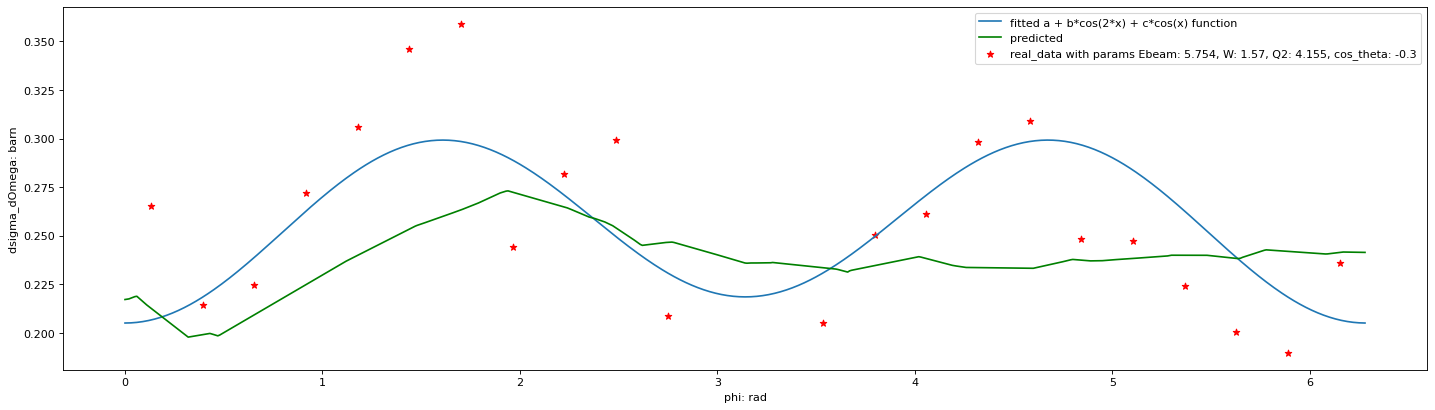

a = 0.20829325926004993 , b = -0.001986660319515554, c = -0.037772157933451345


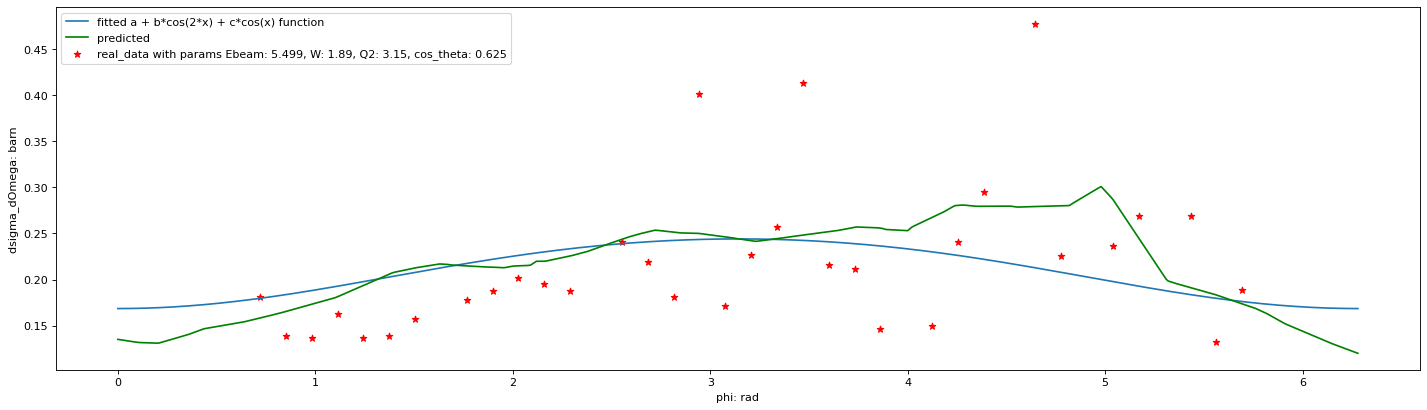

In [33]:
for i in range(1,40):
    interpol_check(df, randint(0, len(df)))

a = 0.3328329166666667 , b = -0.07941457798581507, c = 0.02905387643682495


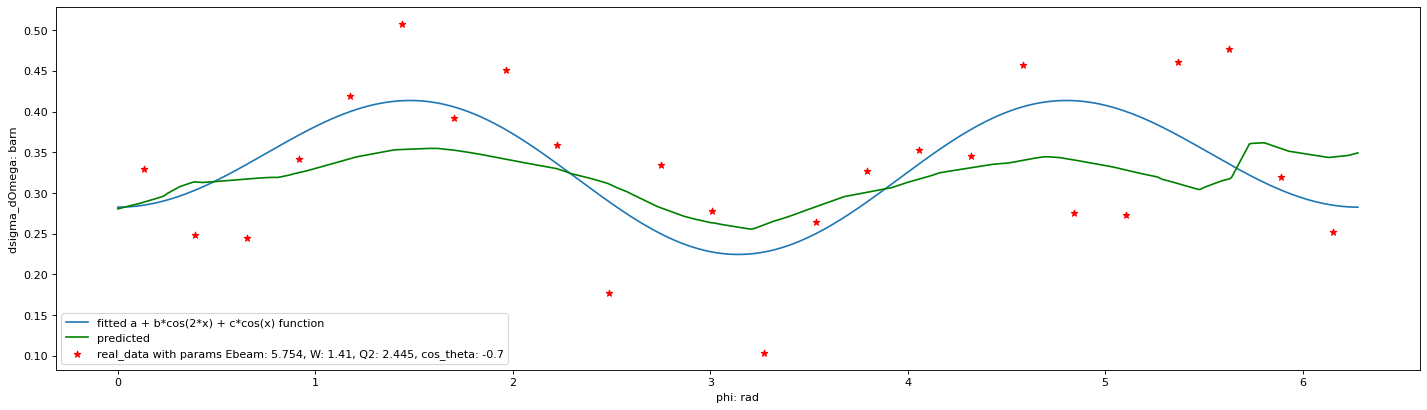

a = 0.6196597164905369 , b = -0.076404893074922, c = -0.05687116966103477


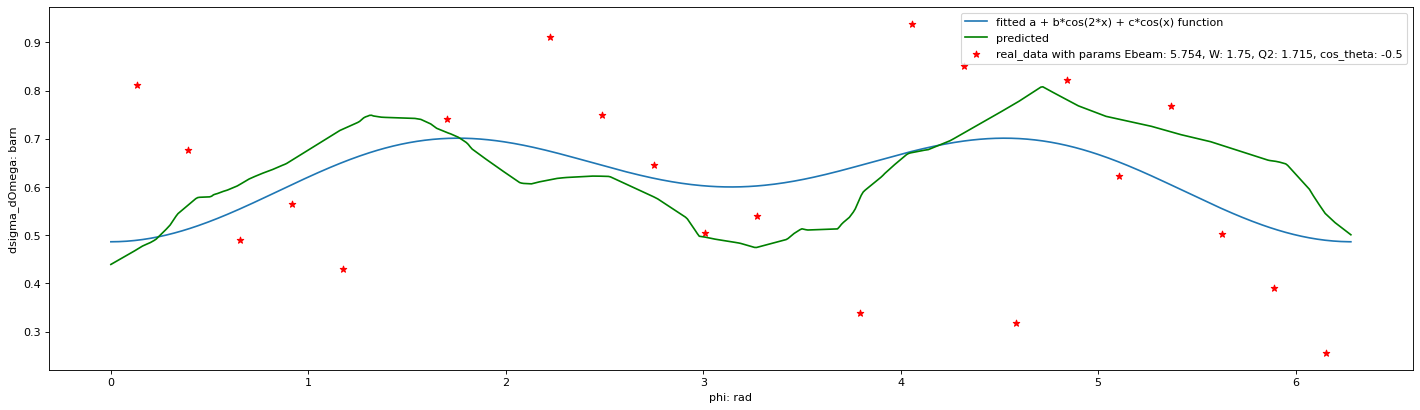

a = 0.19237441330730487 , b = 0.00030463318057583066, c = -0.03457854171764163


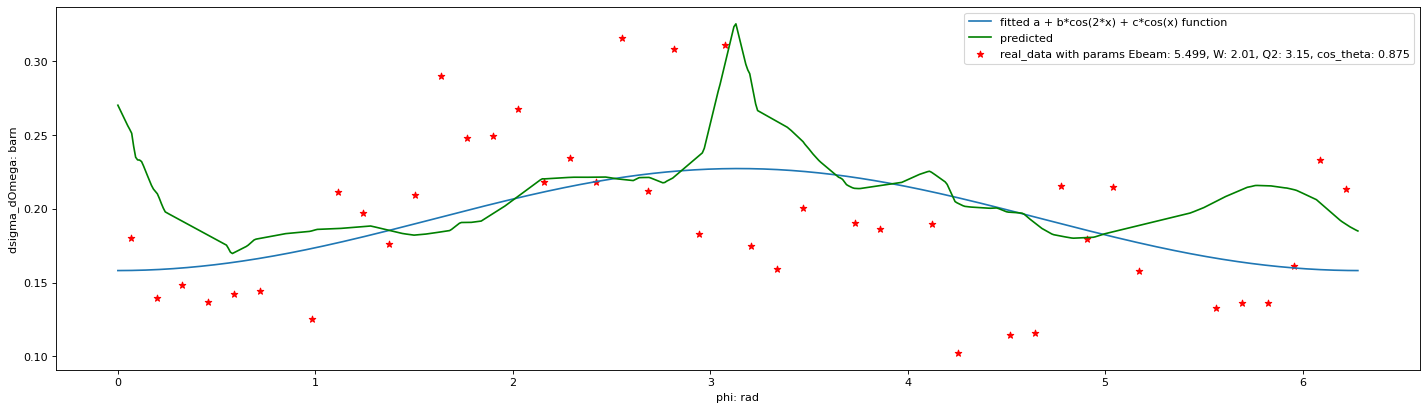

a = 0.2171880544348465 , b = -0.024360460931982405, c = 0.06789520082401986


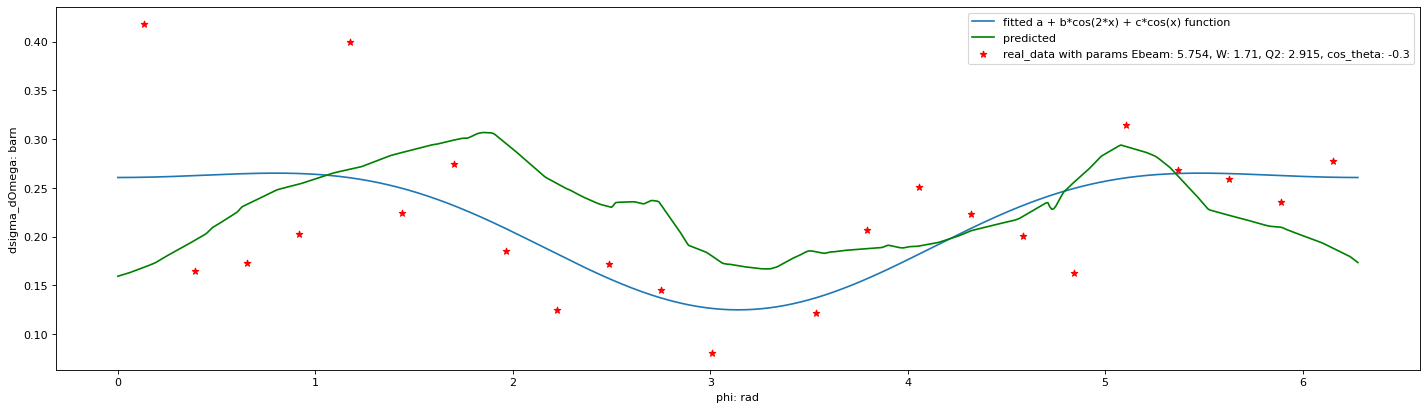

a = 1.907451168013242 , b = -1.0030006372520917, c = -0.35061547645452684


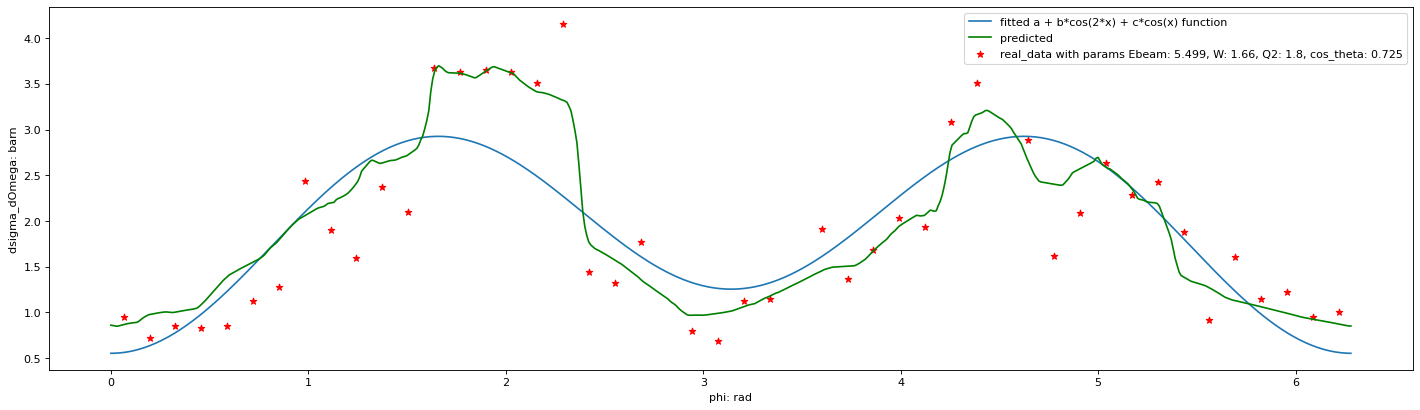

a = 1.2027670186303503 , b = -0.4755397905403908, c = -0.09534108255214713


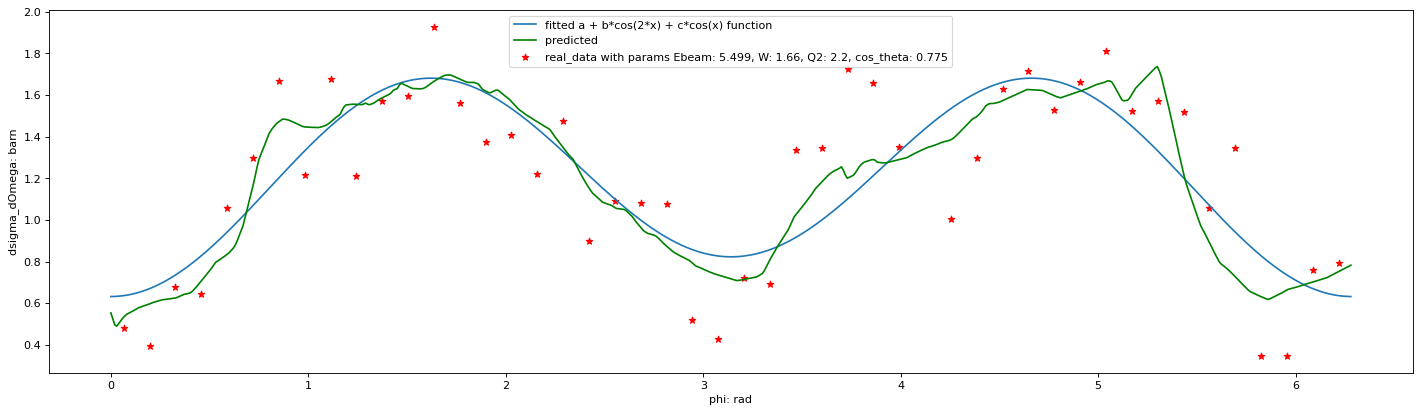

a = 0.09136606737237966 , b = -0.011570119047743677, c = 0.01026378482145348


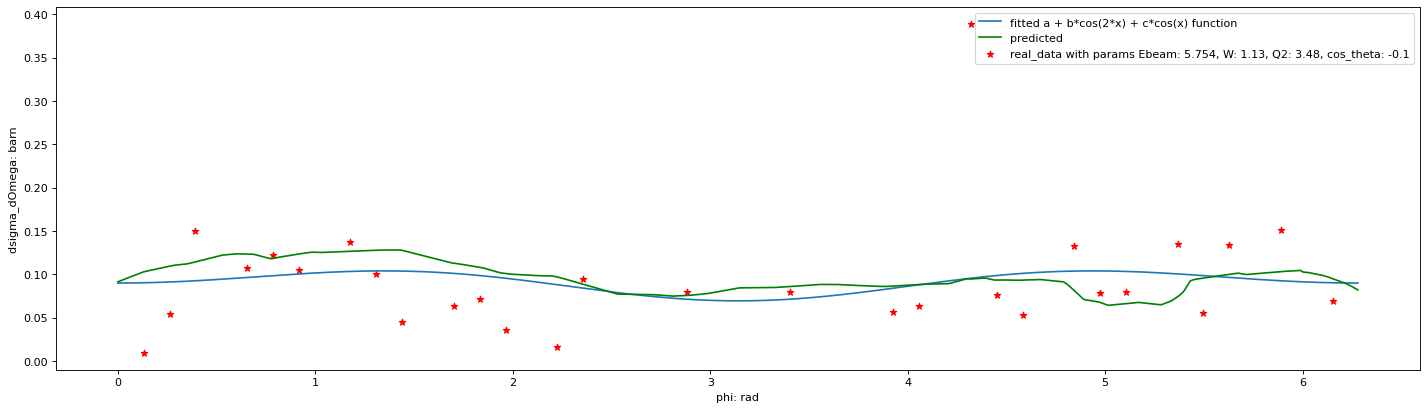

a = 0.1835236249872342 , b = -0.06139740243488615, c = 0.02853541456085805


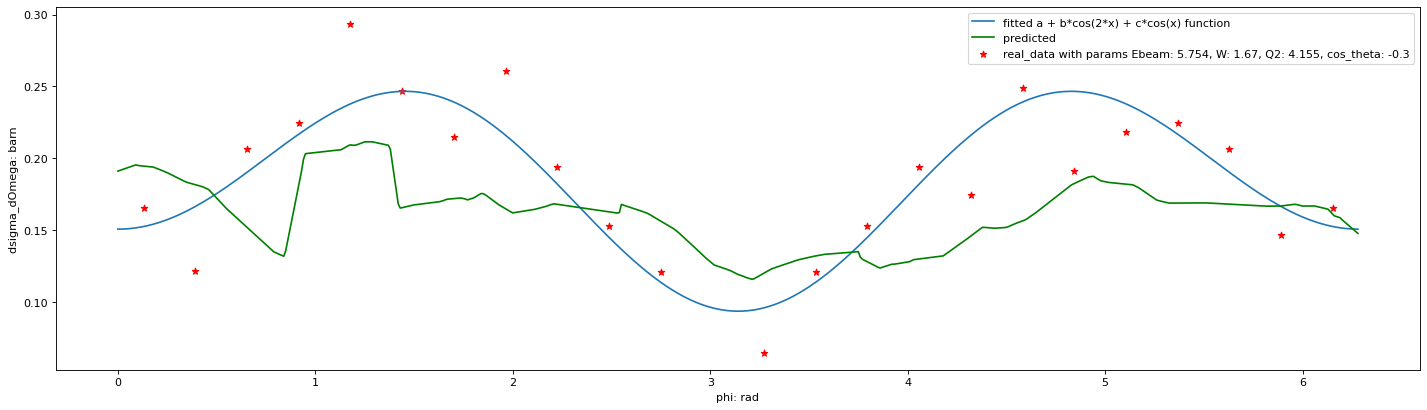

a = 0.9533416665586596 , b = -0.049751734849340735, c = -0.14114665287711423


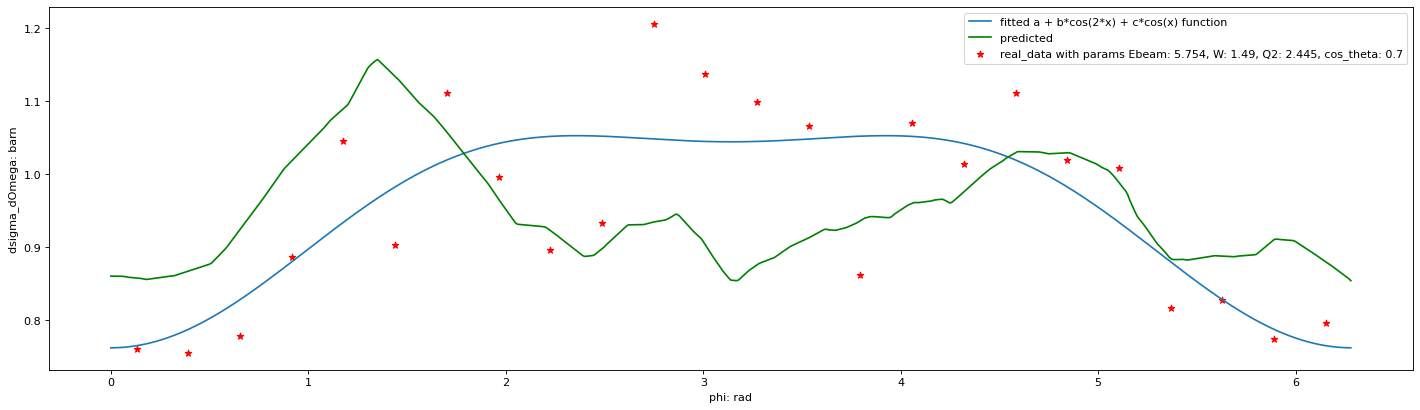

a = 0.22505495781986126 , b = -0.09666010215023767, c = -0.03569378061837072


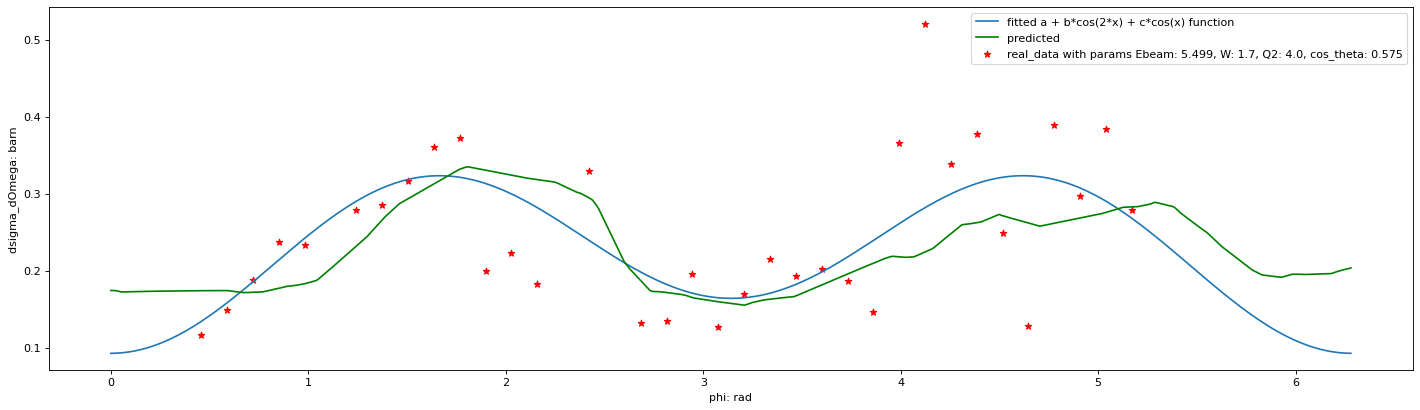

a = 0.6640240359471452 , b = -0.012232389196907612, c = -0.11661468727444646


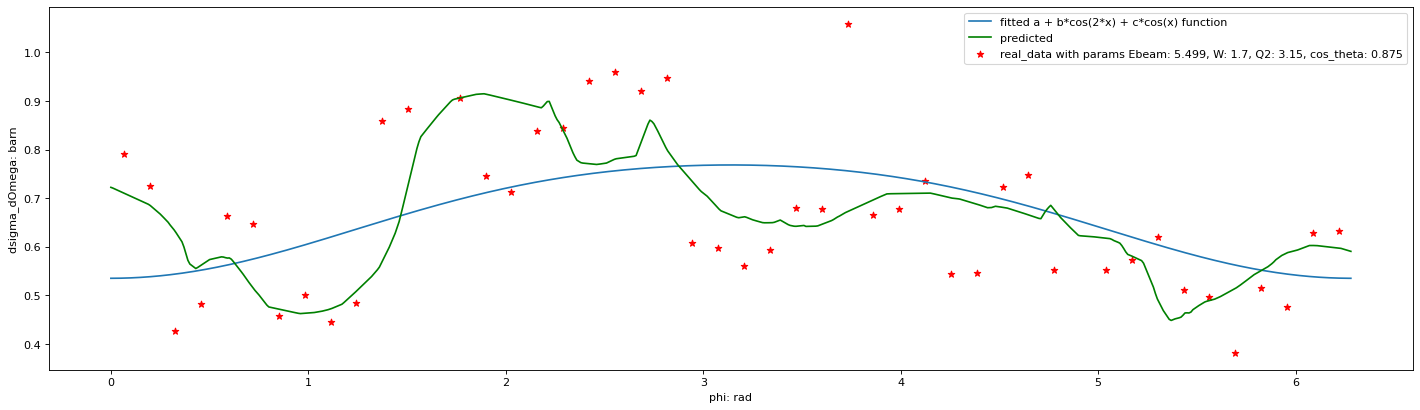

a = 0.37242375000000005 , b = -0.021273656655030906, c = -0.05801723240912536


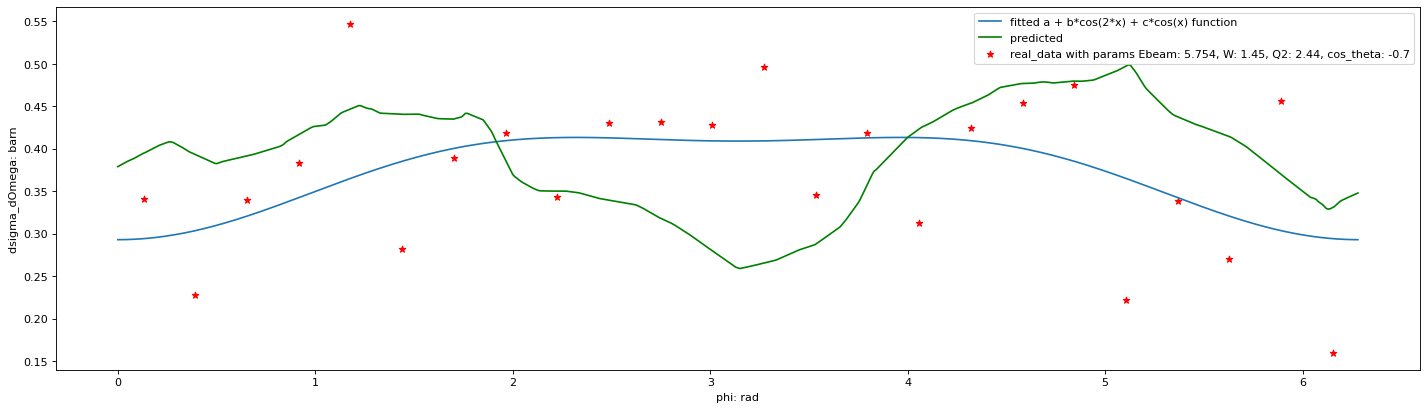

a = 0.07937083333333332 , b = -0.00974017523096156, c = 0.00190321233115577


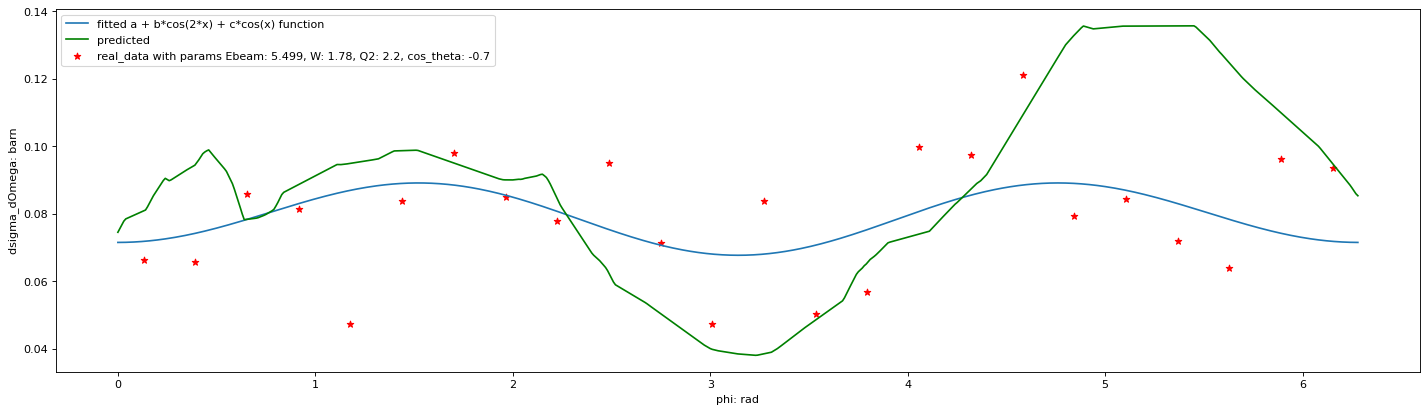

a = 0.6872730344415356 , b = -0.09718104806645925, c = -0.00615181869207805


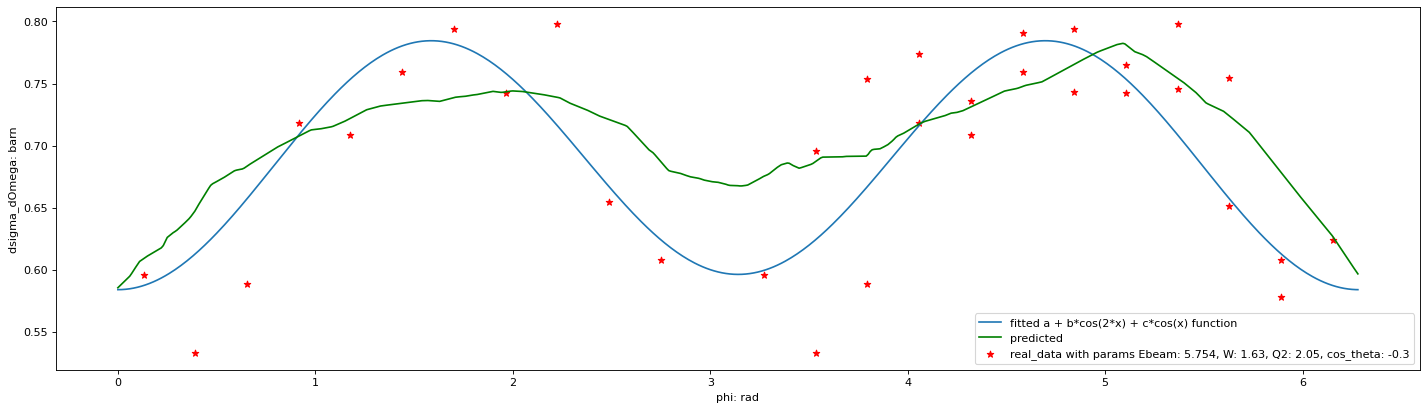

a = 0.5200058333333331 , b = -0.02978254626400856, c = -0.14389376553643976


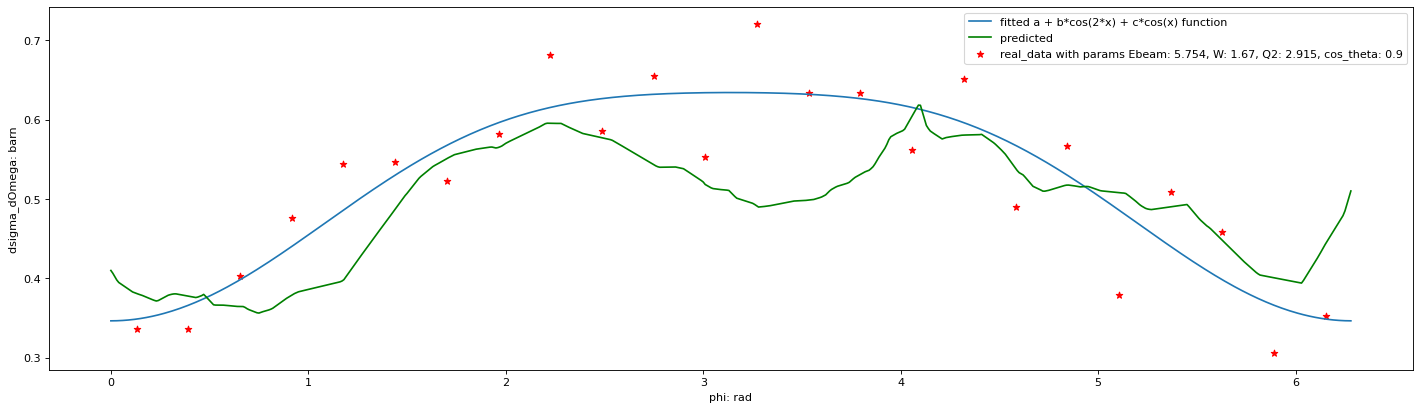

a = 0.2752822810004696 , b = -0.04347625799519352, c = -0.027244512411564184


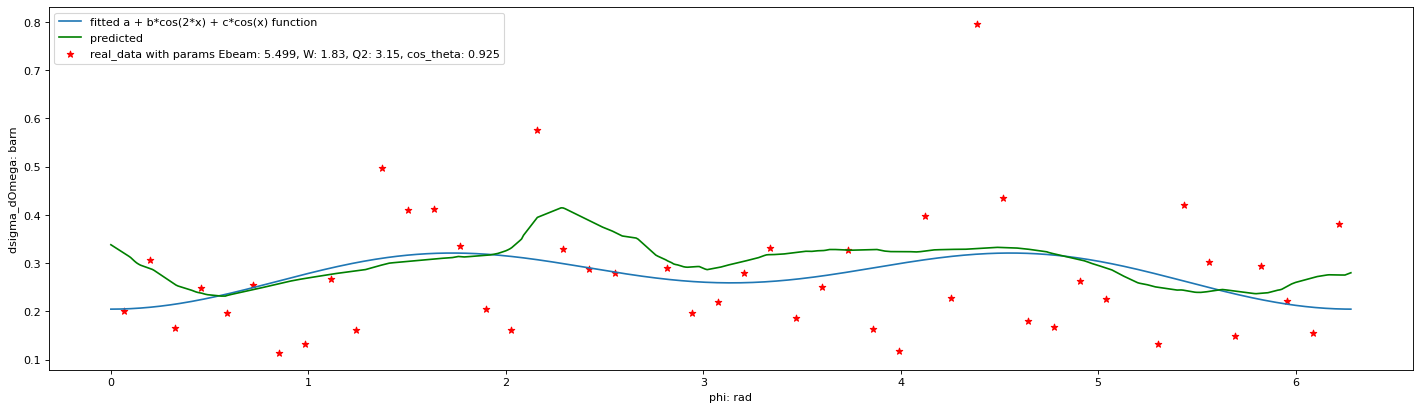

a = 15.17626663671336 , b = -5.446549287791363, c = -5.63895966590377


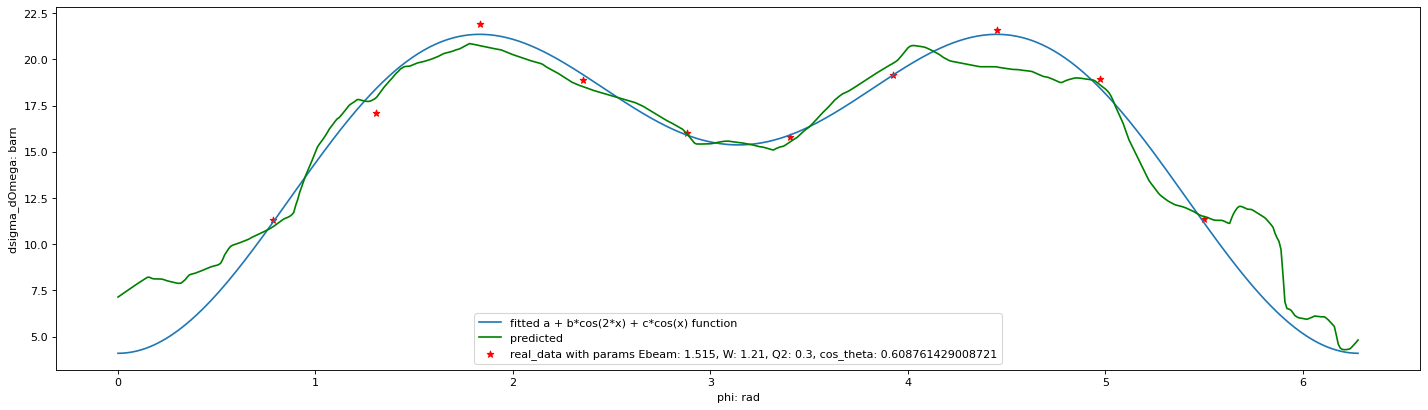

a = 0.33902708333809095 , b = -0.08643211852252412, c = -0.011442730449976478


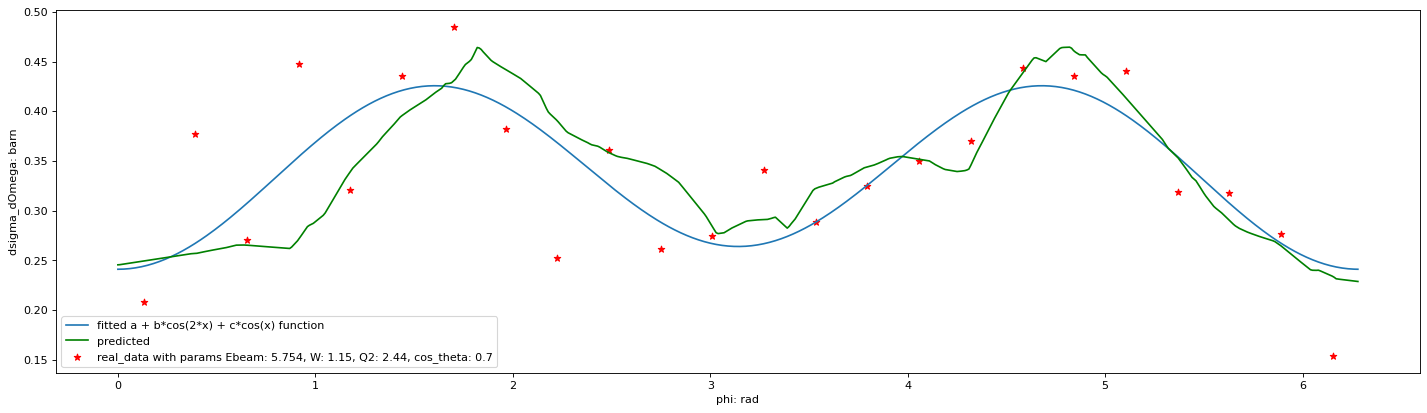

a = 0.7140833333333333 , b = 0.011243895314719135, c = -0.20269782218327914


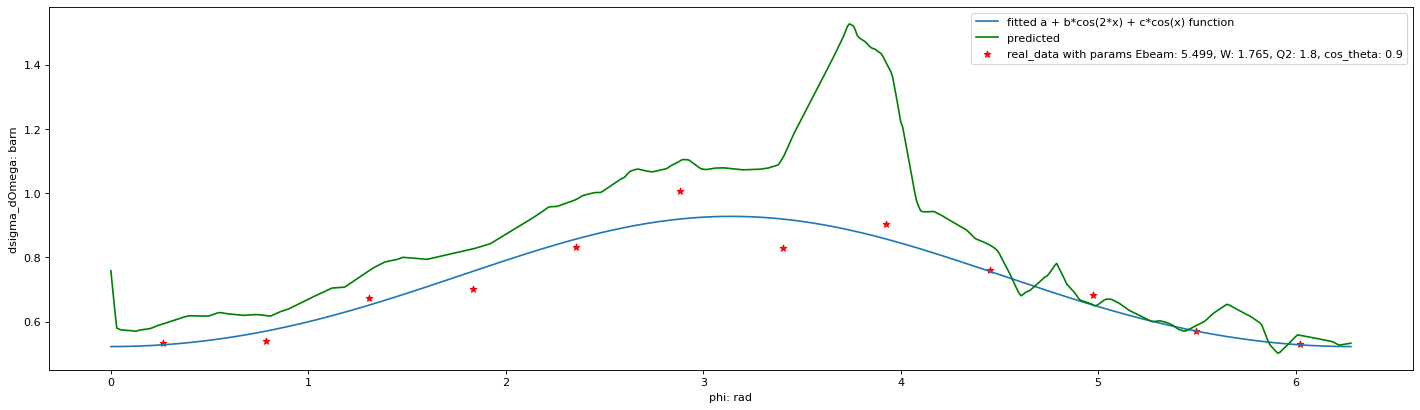

a = 0.7311016666039587 , b = -0.1042973577896464, c = 0.13428342786619163


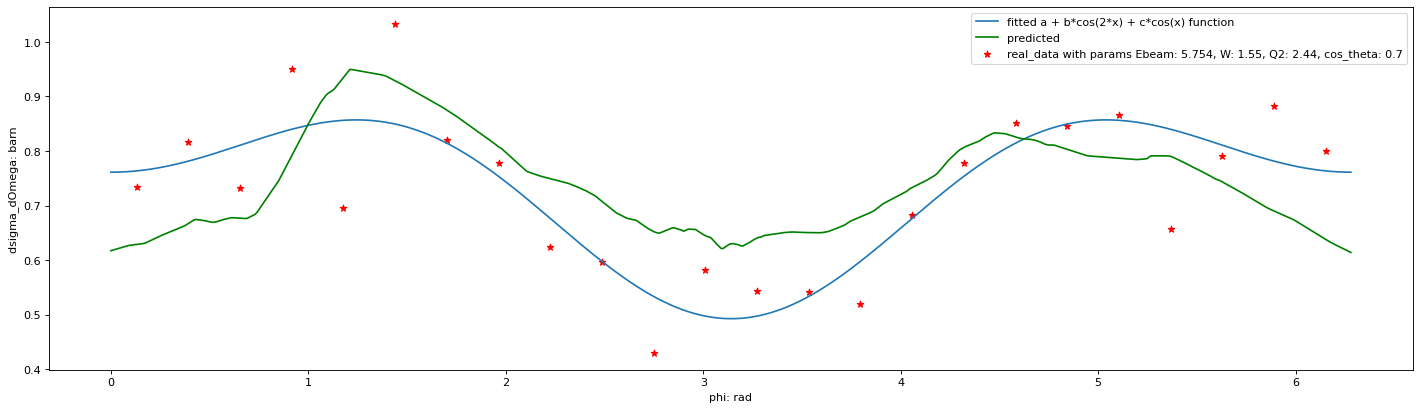

a = 0.8754293977718004 , b = -0.18276249225239038, c = -0.04652768107283914


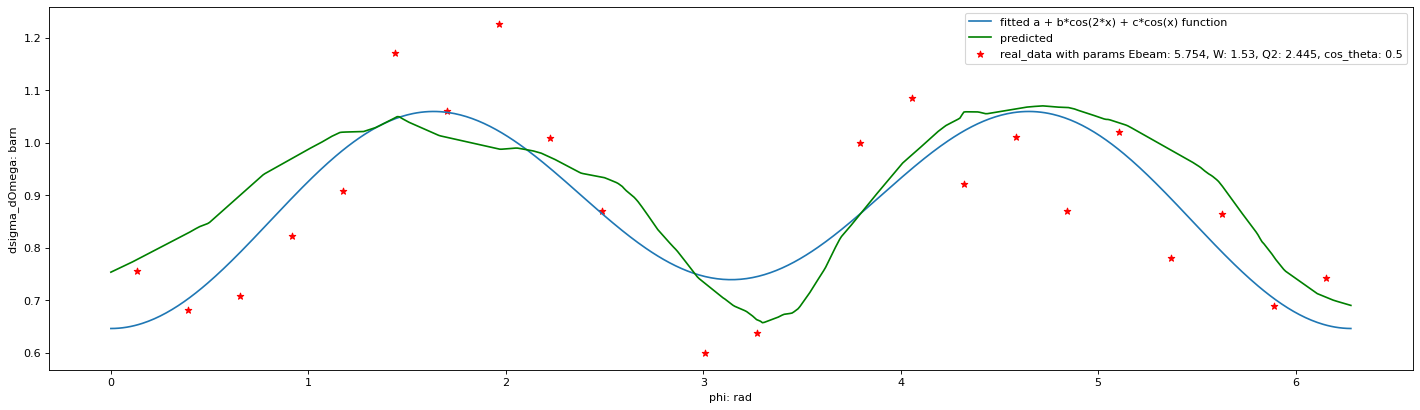

a = 1.5075664531402773 , b = -0.37299263027108154, c = 0.2512507214662876


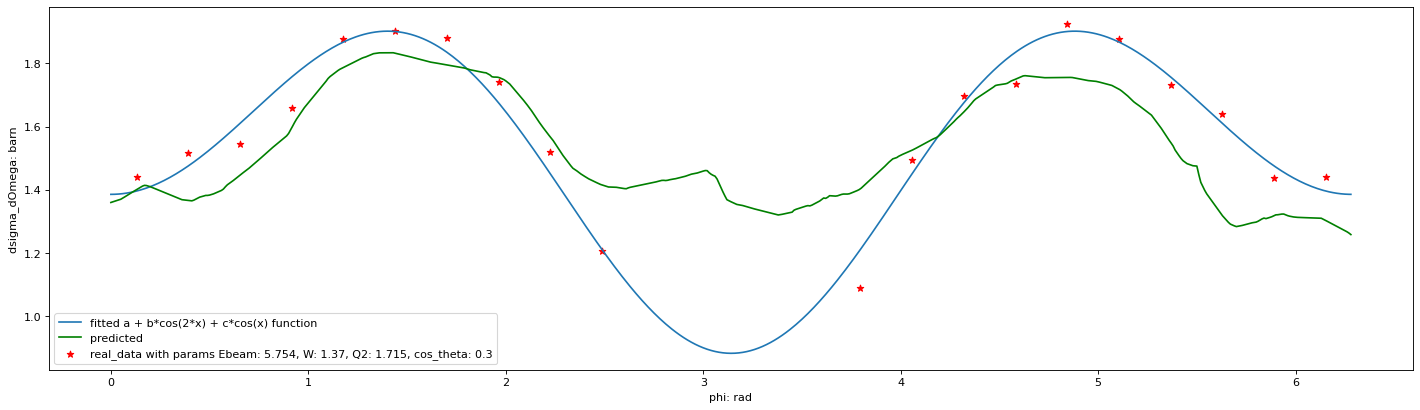

a = 0.5673499253390573 , b = -0.033270729087182656, c = -0.022739508174835842


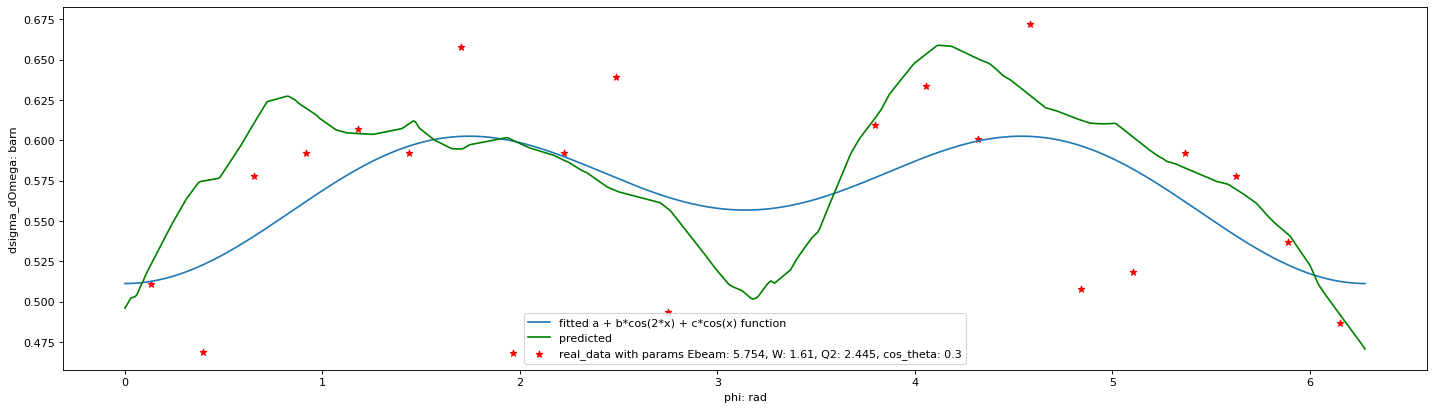

a = 1.0591913646212392 , b = -0.02726534771062657, c = 0.14151217111131623


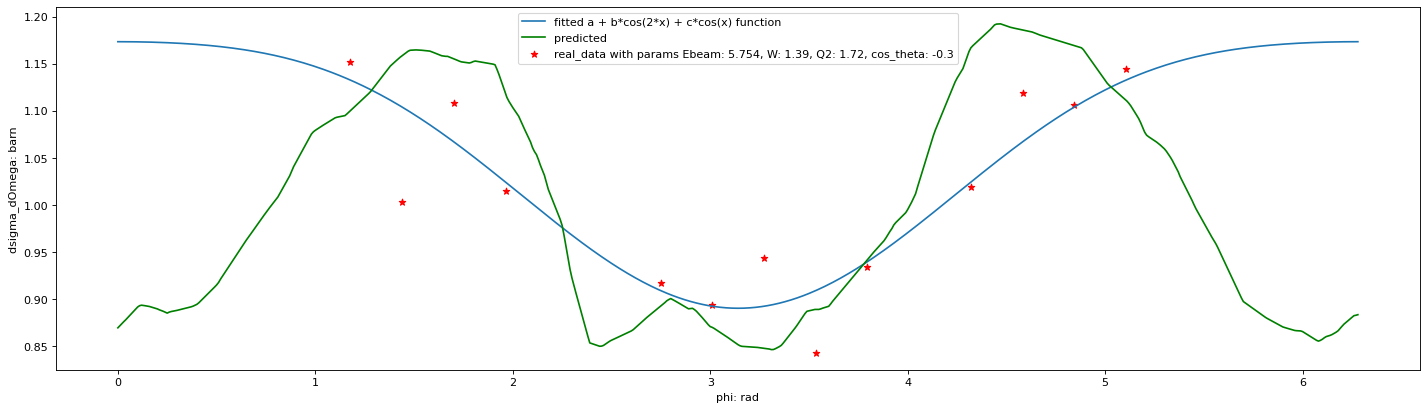

a = 0.3020596259690808 , b = -0.06202505333305081, c = 0.1279672542077423


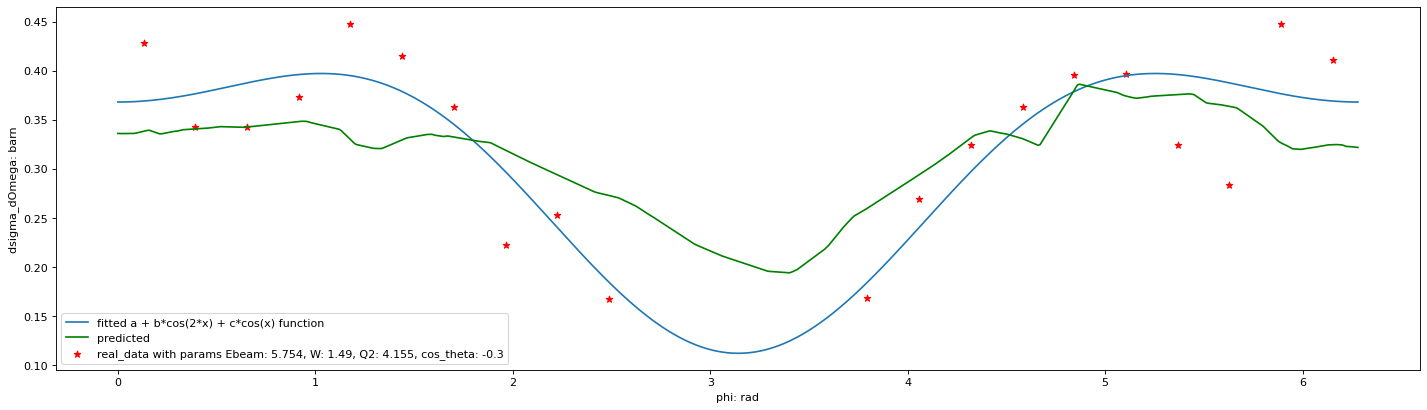

a = 2.221842324774003 , b = -1.141888111745429, c = -0.31303136145600385


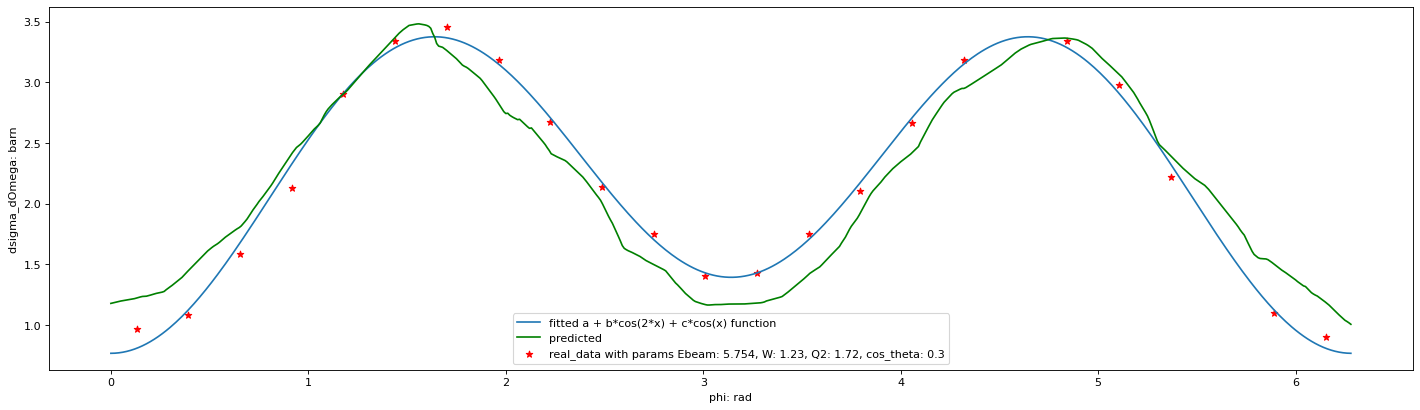

a = 2.0704252131614527 , b = -0.4381859854438703, c = -0.19030440987034783


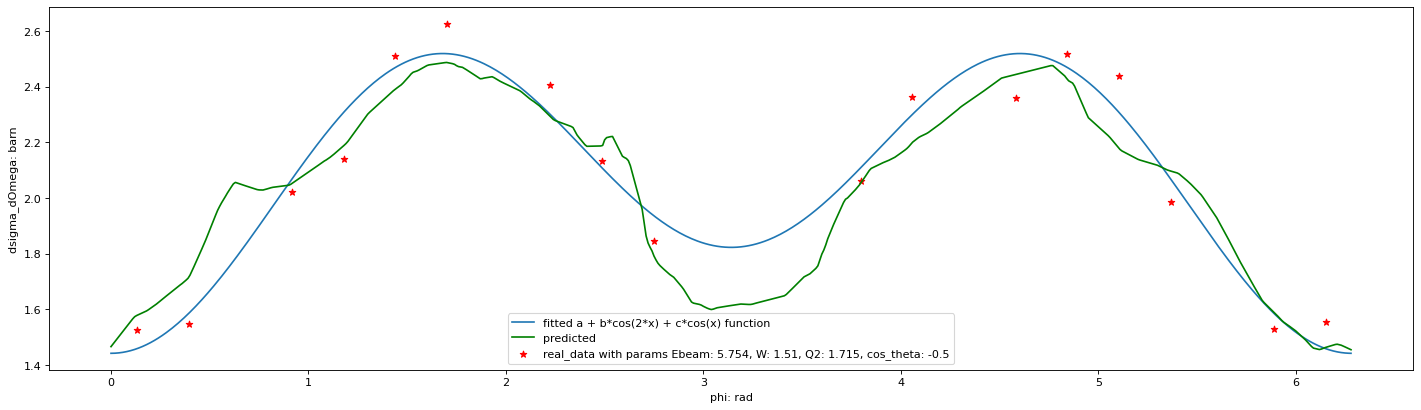

a = 1.4528852930305394 , b = -0.7890583240067024, c = -0.2463822634260029


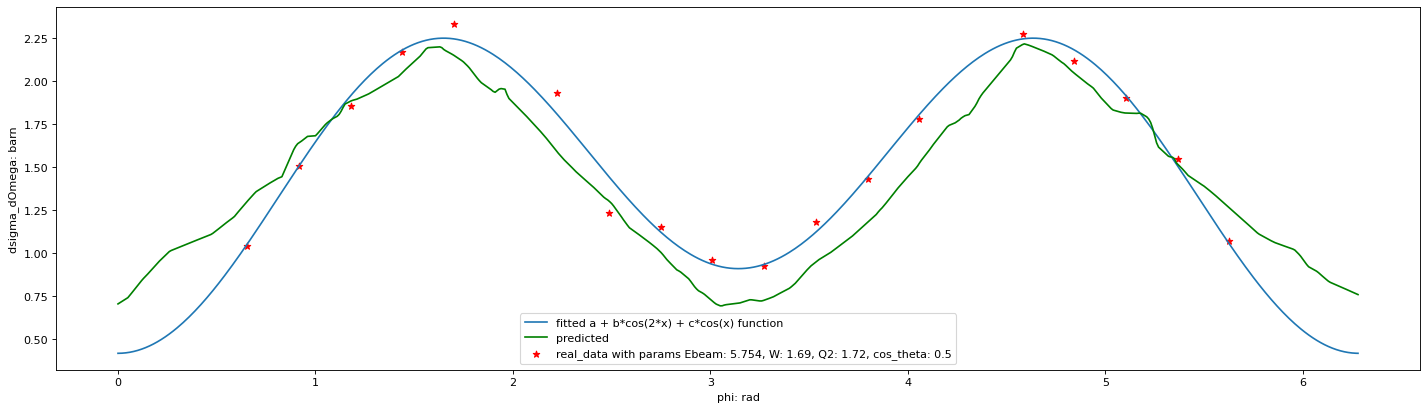

a = 8.154051754057335 , b = 1.6333836767557066, c = -1.9531021092175214


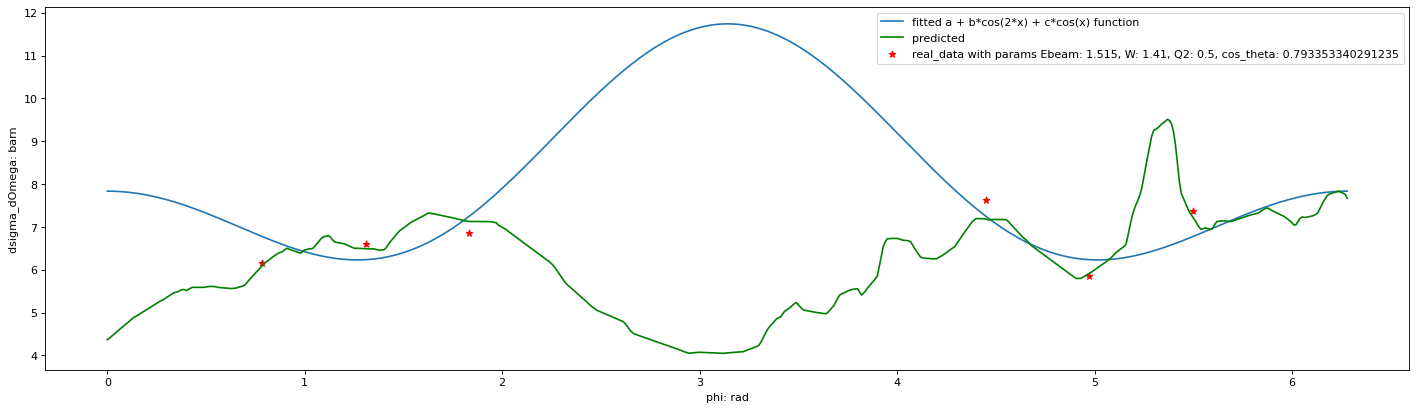

a = 0.9935006206322943 , b = -0.537458149032888, c = 3.654863705431027e-10


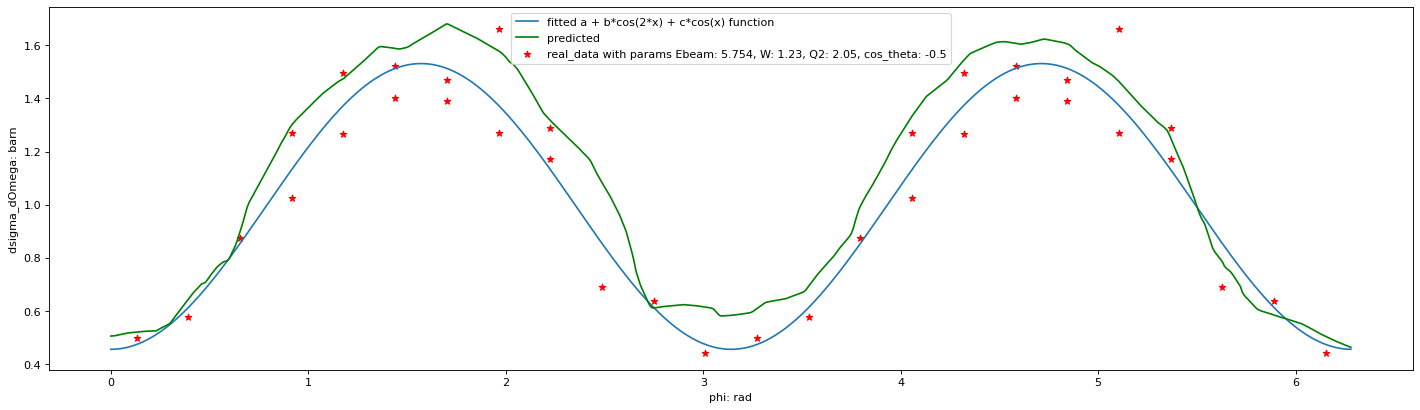

a = 0.49459690931486444 , b = -0.11563859025220768, c = 0.027053952049615915


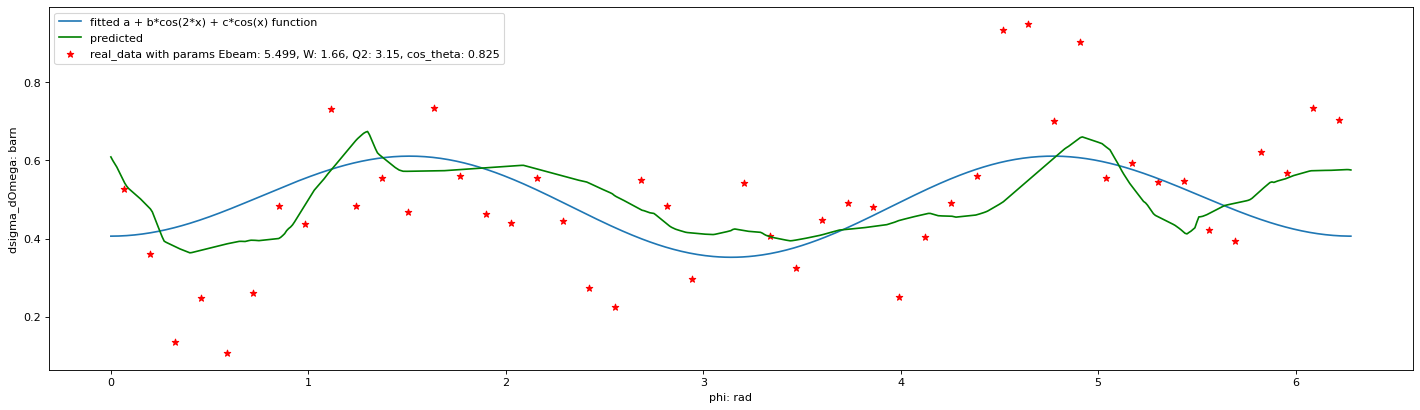

a = 0.7680161281074707 , b = -0.14735690494905238, c = -0.080850957938634


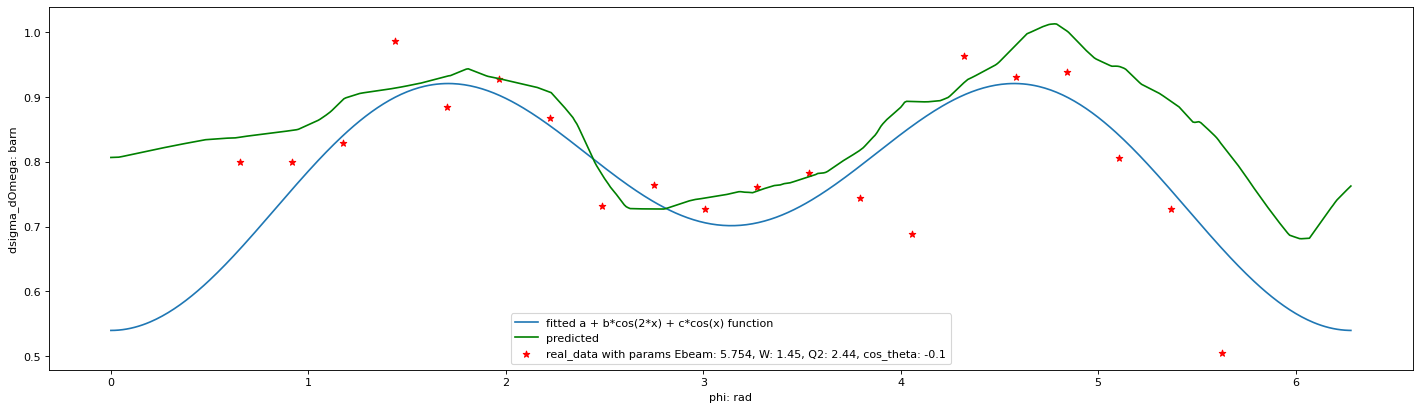

a = 0.3747197702364814 , b = -0.09664632548872663, c = 0.011994252029282832


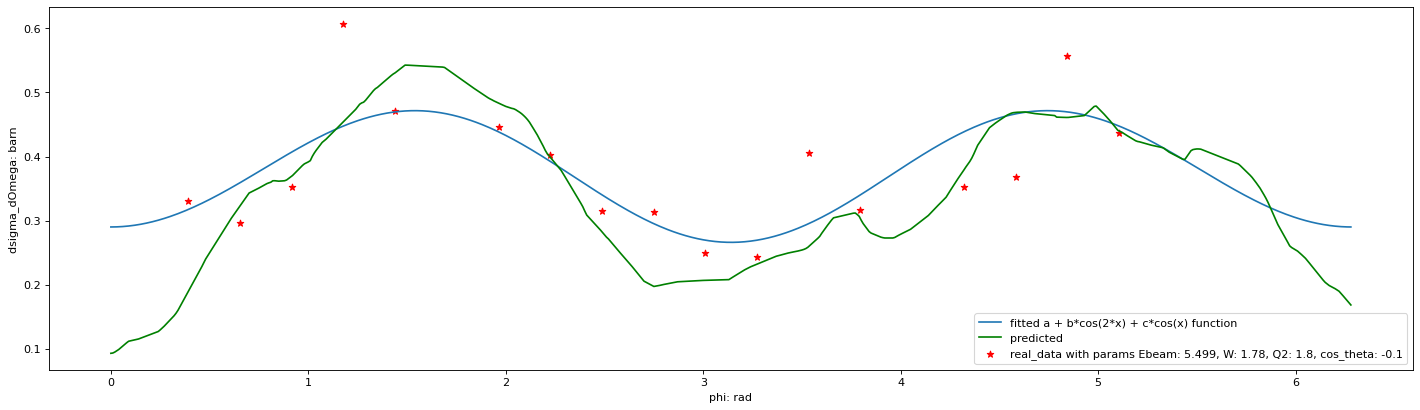

a = 0.6971833333573197 , b = -0.1493483405990698, c = -0.07653139219806761


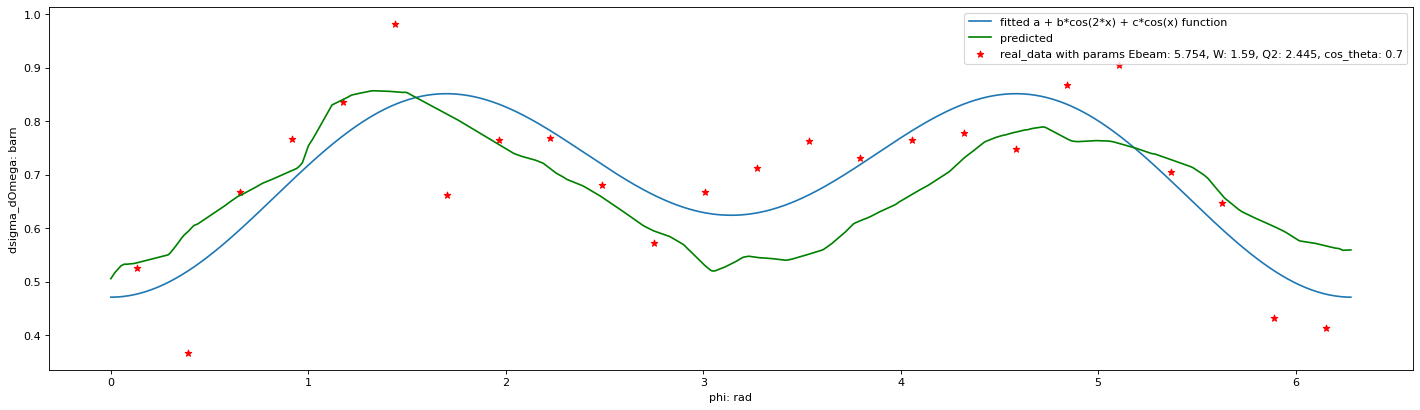

a = 0.919734655976068 , b = -0.1343948524315381, c = 0.08673369273511633


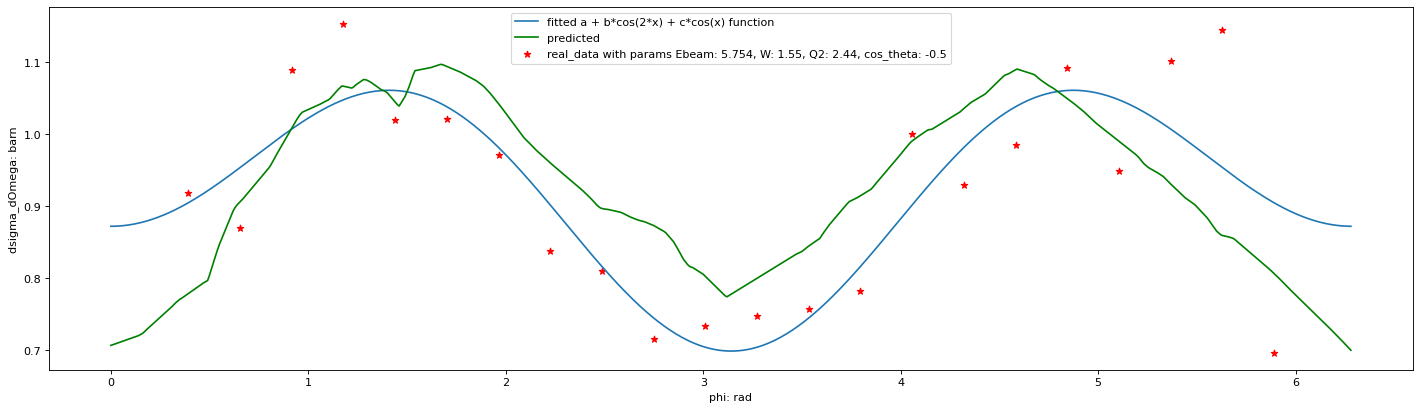

a = 0.8617983493961329 , b = -0.21578940911114608, c = 0.3260514383169989


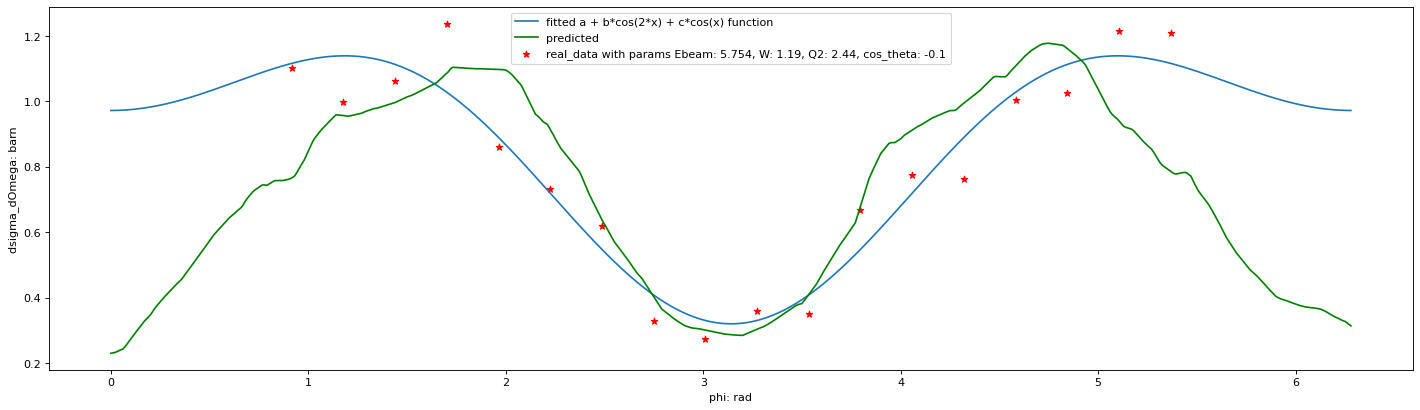

a = 1.290992911719819 , b = -0.5654915597858162, c = -0.340785647648912


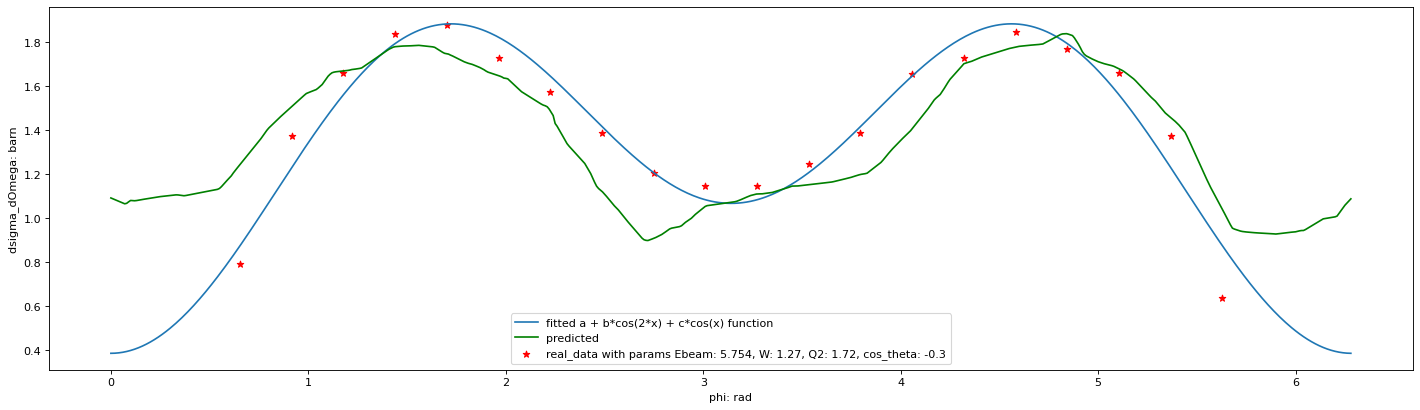

a = 0.39056074609839336 , b = -0.12853851359549018, c = -0.10086283898229681


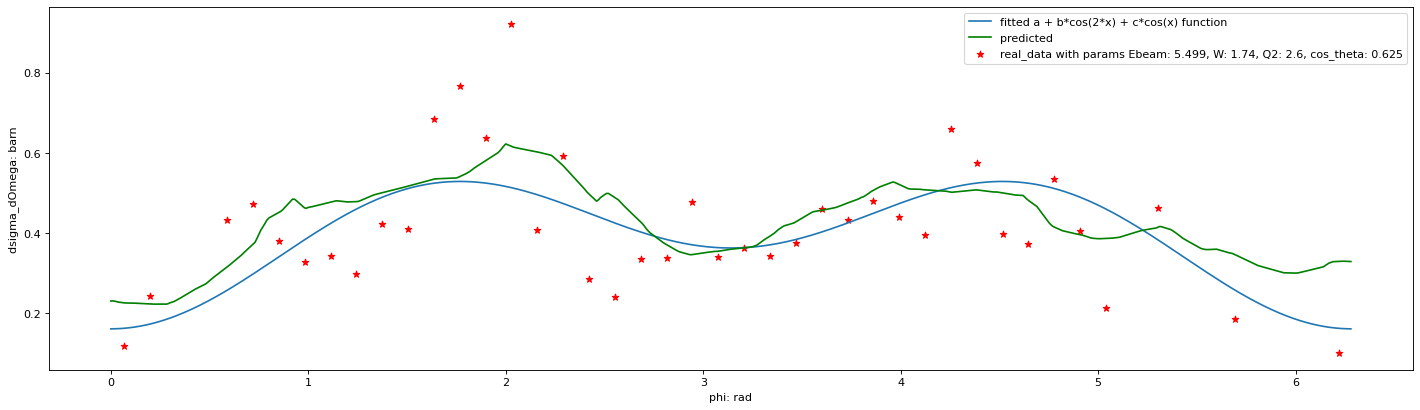

a = 0.4659961305791065 , b = -1.3831924361218384e-05, c = -0.044183376524986606


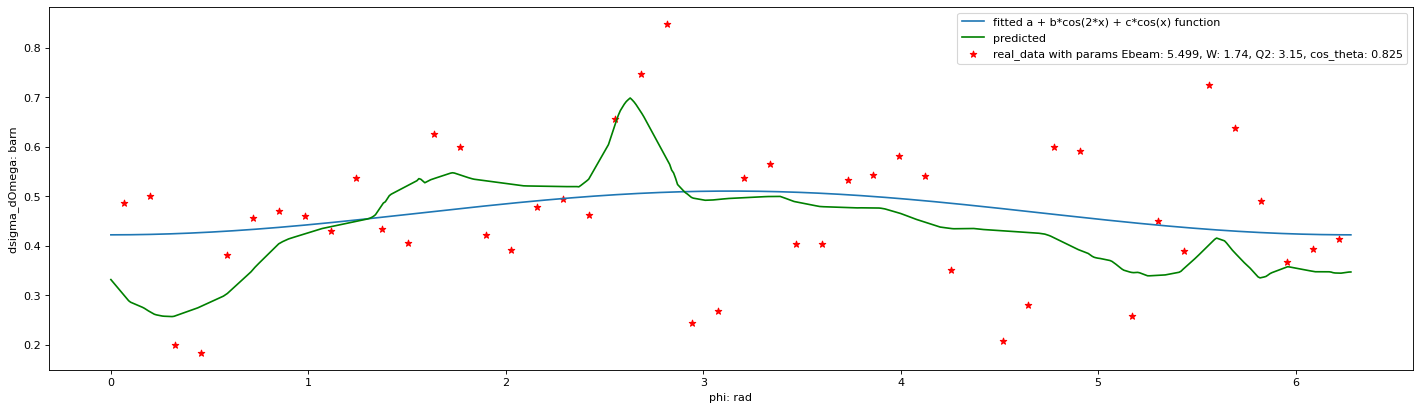

In [19]:
for i in range(1,40):
    interpol_check(df, randint(0, len(df)))

### dsigma_dOmega as a function of W

In [13]:
def integral_cross_section_W():
    rand_n = randint(0, len(df))
    grid_step_phi = 0.001
    
    example = df.iloc[rand_n]
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.Q2 == example['Q2'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')

    phi_grid = np.arange(0, 2*np.pi, grid_step_phi)
    W_grid = np.sort(df_example_set.W.unique())
    
    final_list = []
    for i in range(len(W_grid)):
        one_set = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in range(len(phi_grid))],
                                 'W' :  [W_grid[i] for _ in range(len(phi_grid))],
                                 'Q2' : [example['Q2'] for _ in range(len(phi_grid))],
                                 'cos_theta' : [example['cos_theta'] for _ in range(len(phi_grid))],
                                 'phi' : phi_grid})

        one_set = torch.tensor(scaler_feature.transform(one_set)).to(torch.float32)

        with torch.no_grad():
            one_predictions_set = model(one_set)
            one_predictions_set = scaler_target.inverse_transform(one_predictions_set)

        final_list.append({'Ebeam' : example['Ebeam'],
                            'W' :  W_grid[i],
                            'Q2' : example['Q2'],
                            'cos_theta' : example['cos_theta'],
                            'phi' : 'all_phi',
                            'dsigma_dOmega' : np.trapz(one_predictions_set.flatten(), dx=grid_step_phi)})
        
    cross_sections_int = [element['dsigma_dOmega'] for element in final_list]
    
    # plot part
    plt.figure(figsize=(22, 6), dpi=80)
    plt.scatter(x=W_grid, 
                y=cross_sections_int, 
                color='red', marker='*', label=f"Predicted integral cross_section. Fixed params: Ebeam {example['Ebeam']}, Q2: {example['Q2']}, cos_theta: {example['cos_theta']}")
    
    plt.xlabel("W: GeV")
    plt.ylabel("dsigma_dOmega: barn")
    
    plt.legend()
    plt.show()

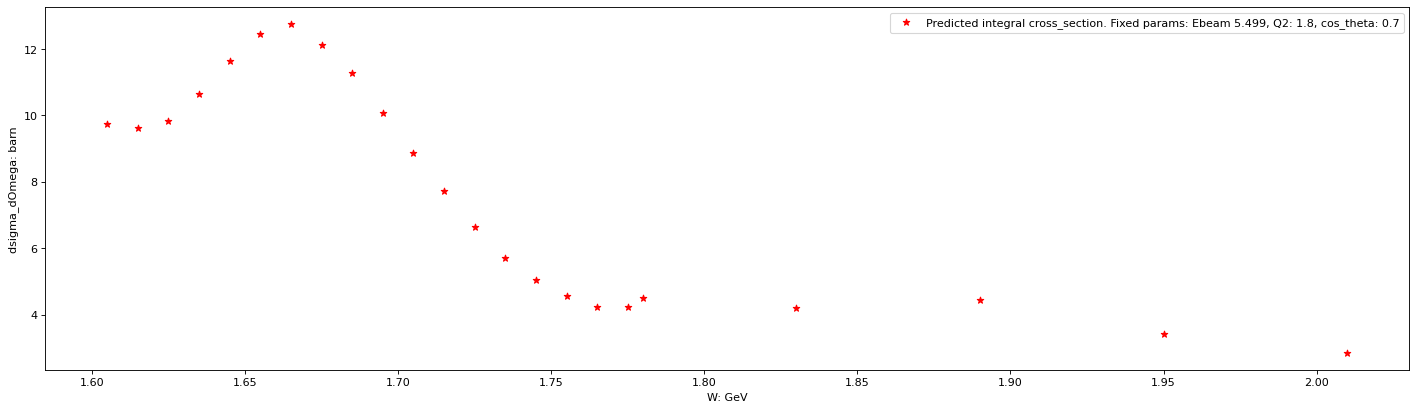

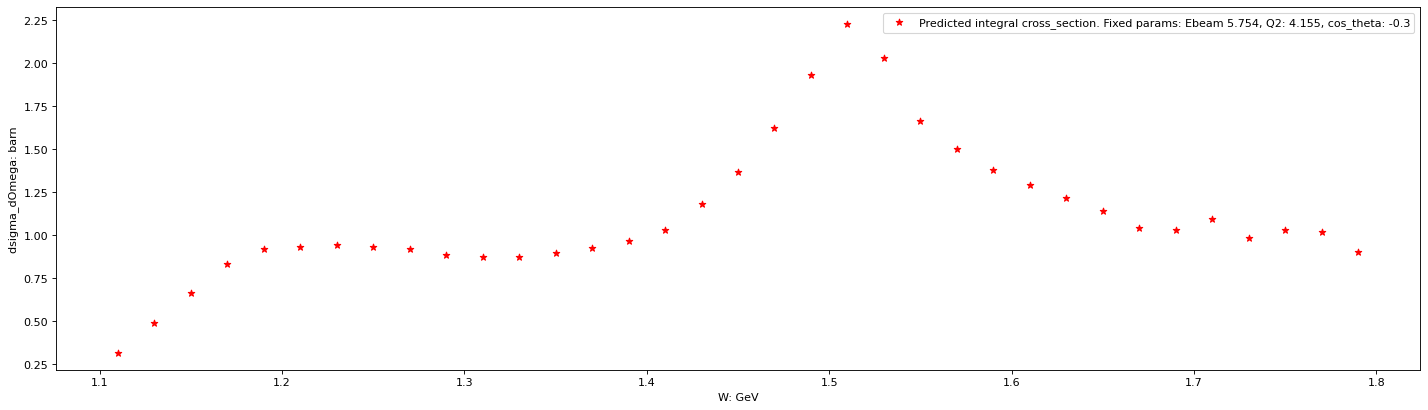

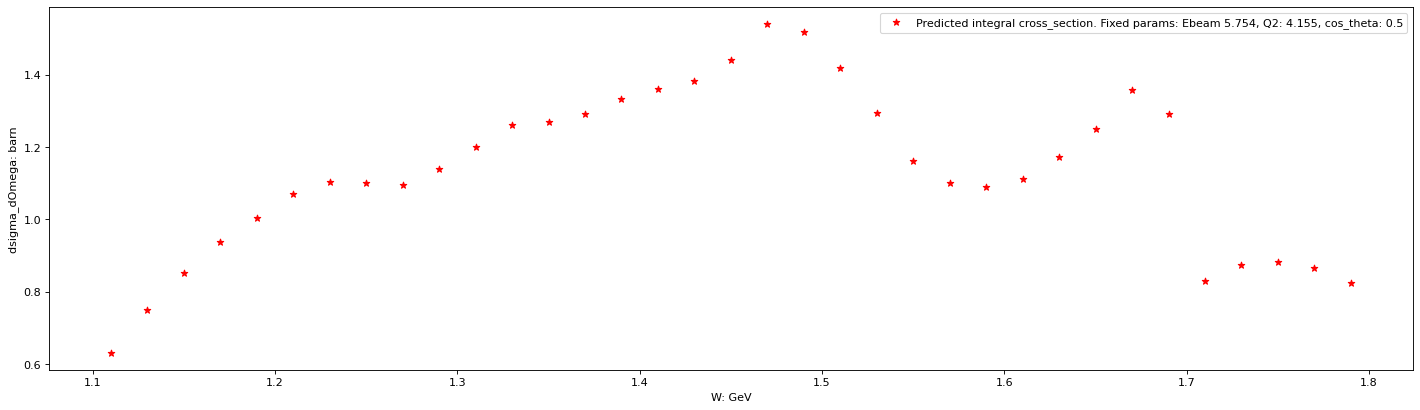

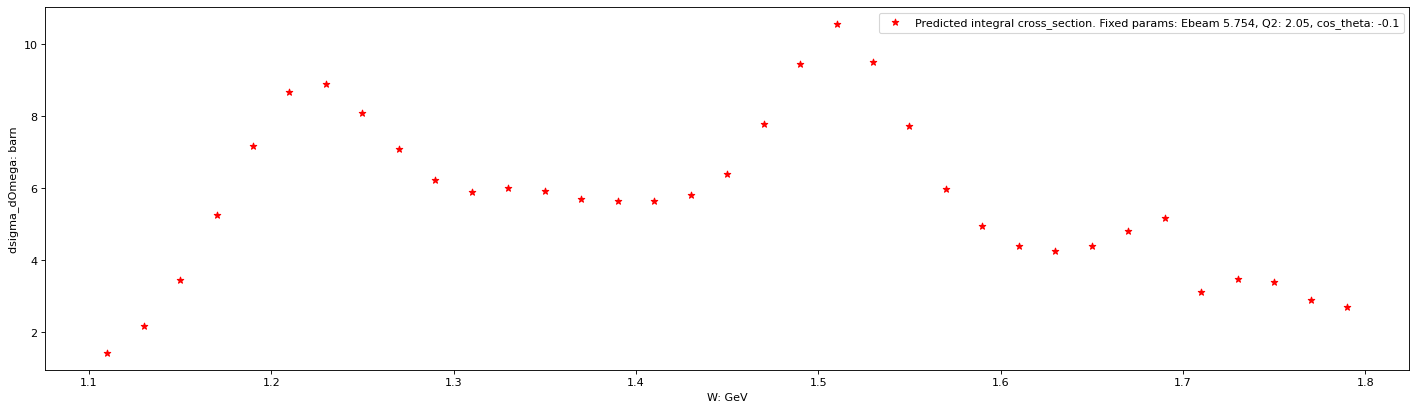

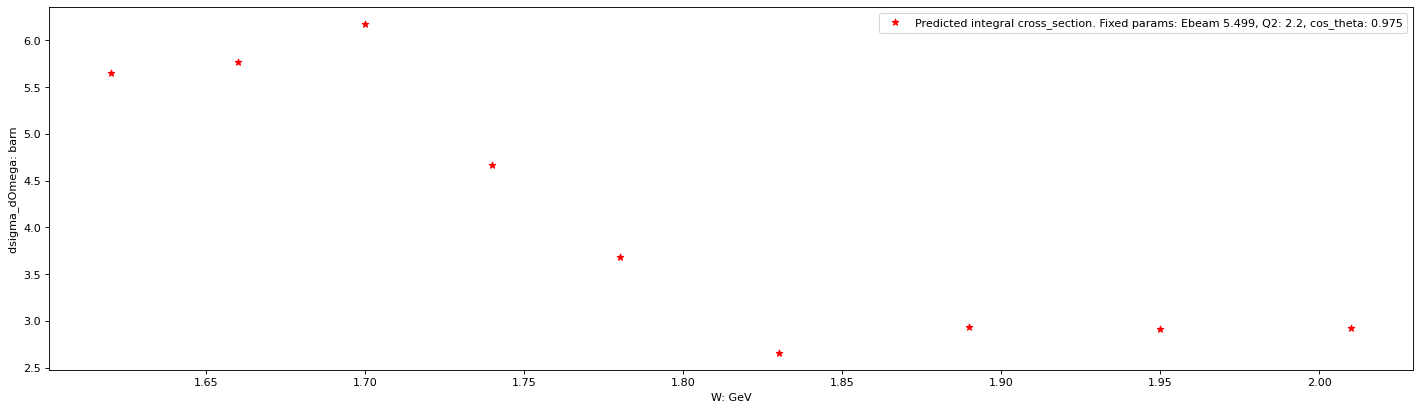

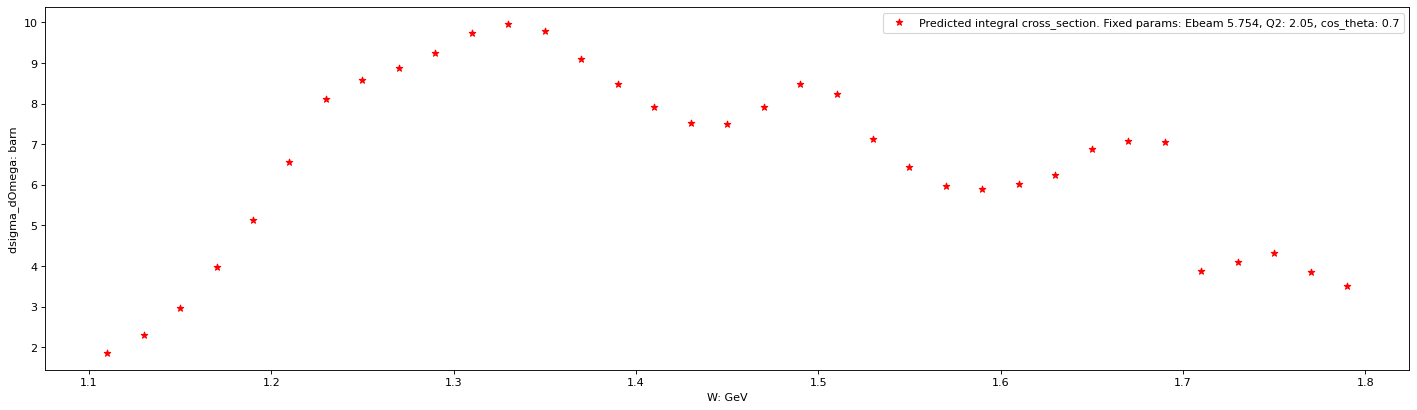

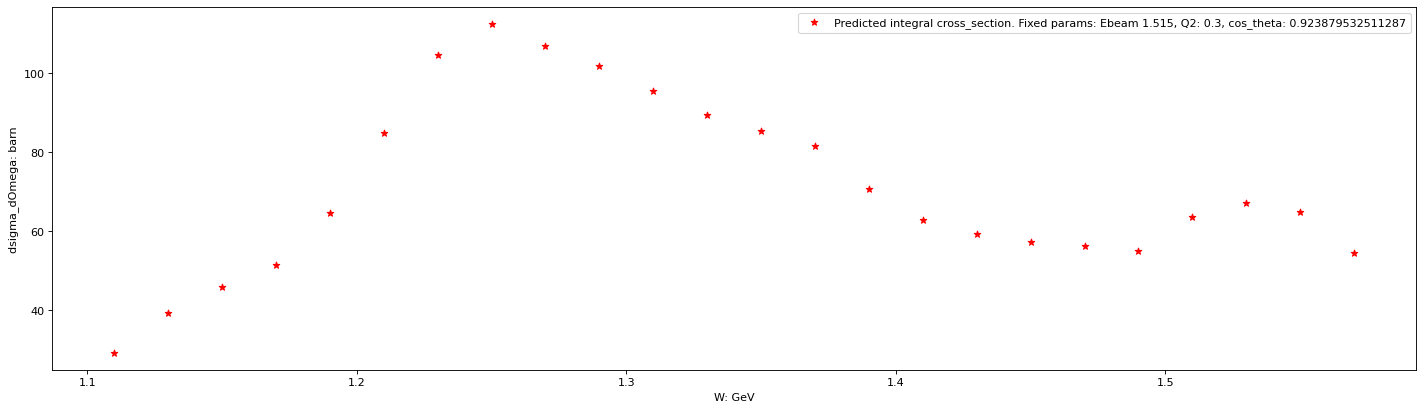

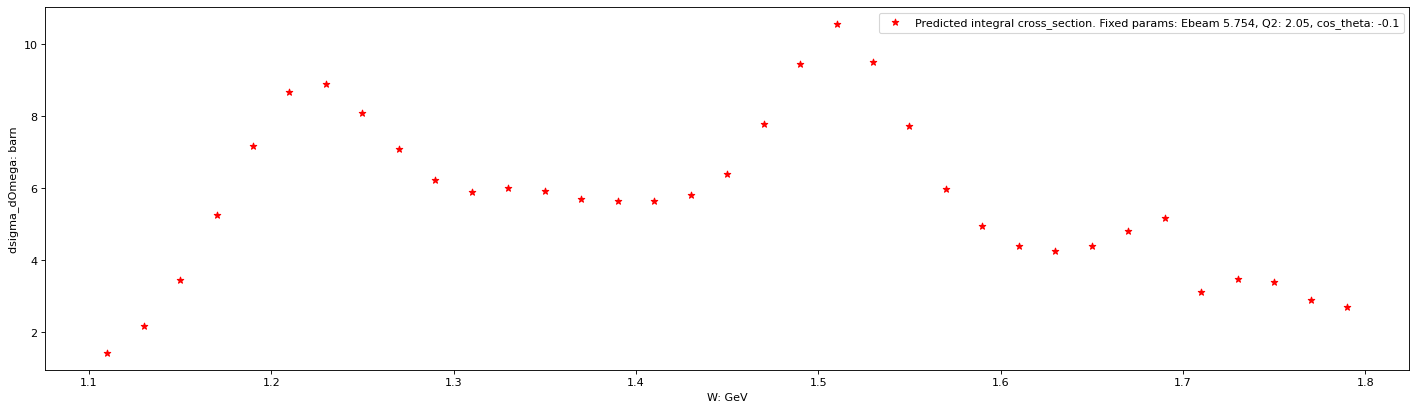

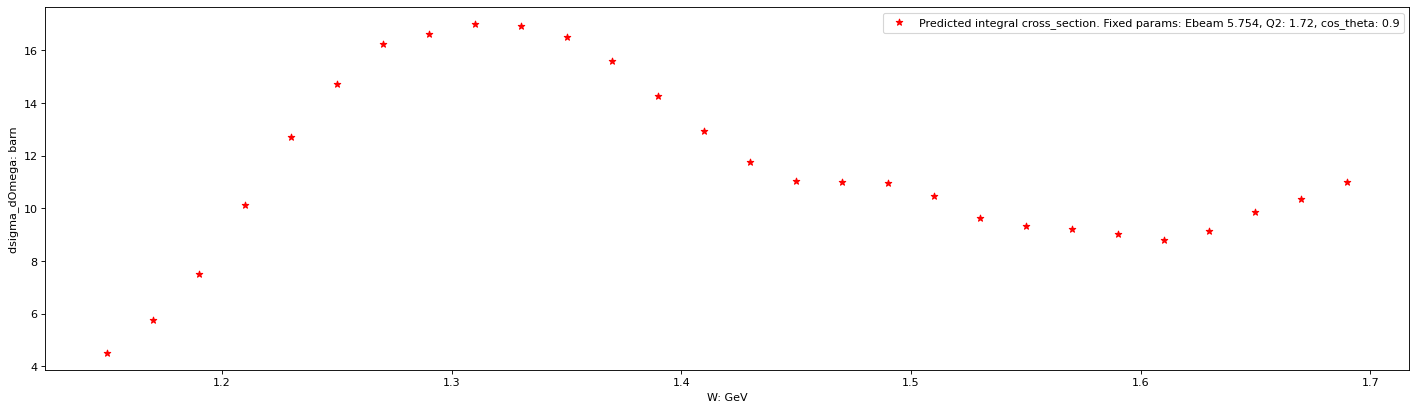

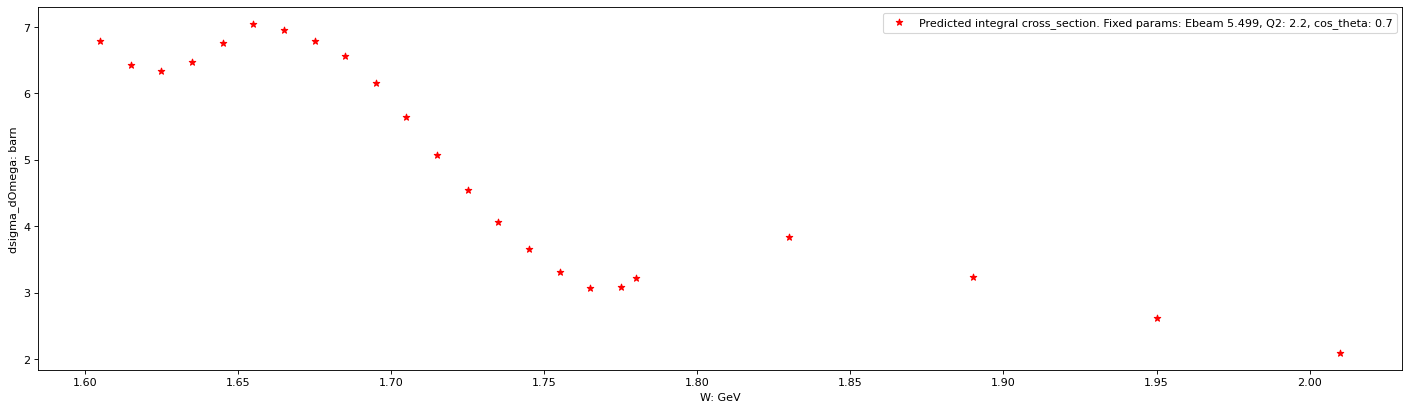

In [14]:
for _ in range(10):
    integral_cross_section_W()

### dsigma_dOmega as a function of Q2

In [140]:
def integral_cross_section_q_sqrd():
    rand_n = randint(0, len(df))
    grid_step_phi = 0.001
    
    example = df.iloc[rand_n]
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.W == example['W'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')

    phi_grid = np.arange(0, 2*np.pi, grid_step_phi)
    Q2_grid = np.arange(df_example_set.Q2.min(), df_example_set.Q2.max(), 0.07)
#     Q2_grid = np.sort(df_example_set.Q2.unique())
    
    final_list = []
    for i in range(len(Q2_grid)):
        one_set = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in range(len(phi_grid))],
                                 'W' :  [example['W'] for _ in range(len(phi_grid))],
                                 'Q2' : [Q2_grid[i] for _ in range(len(phi_grid))],
                                 'cos_theta' : [example['cos_theta'] for _ in range(len(phi_grid))],
                                 'phi' : phi_grid})

        one_set = torch.tensor(scaler_feature.transform(one_set)).to(torch.float32)

        with torch.no_grad():
            one_predictions_set = model(one_set)
            one_predictions_set = scaler_target.inverse_transform(one_predictions_set)

        final_list.append({'Ebeam' : example['Ebeam'],
                            'W' :  example['W'],
                            'Q2' :  Q2_grid[i],
                            'cos_theta' : example['cos_theta'],
                            'phi' : 'all_phi',
                            'dsigma_dOmega' : np.trapz(one_predictions_set.flatten(), dx=grid_step_phi)})
        
    cross_sections_int = [element['dsigma_dOmega'] for element in final_list]
    
    # plot part
    plt.figure(figsize=(22, 6), dpi=80)
    plt.scatter(x=Q2_grid, 
                y=cross_sections_int, 
                color='red', marker='*', label=f"Predicted integral cross_section. Fixed params: Ebeam {example['Ebeam']}, W: {example['W']}, cos_theta: {example['cos_theta']}")
    
    plt.xlabel("Q2: GeV")
    plt.ylabel("dsigma_dOmega: barn")
    
    plt.legend()
    plt.show()

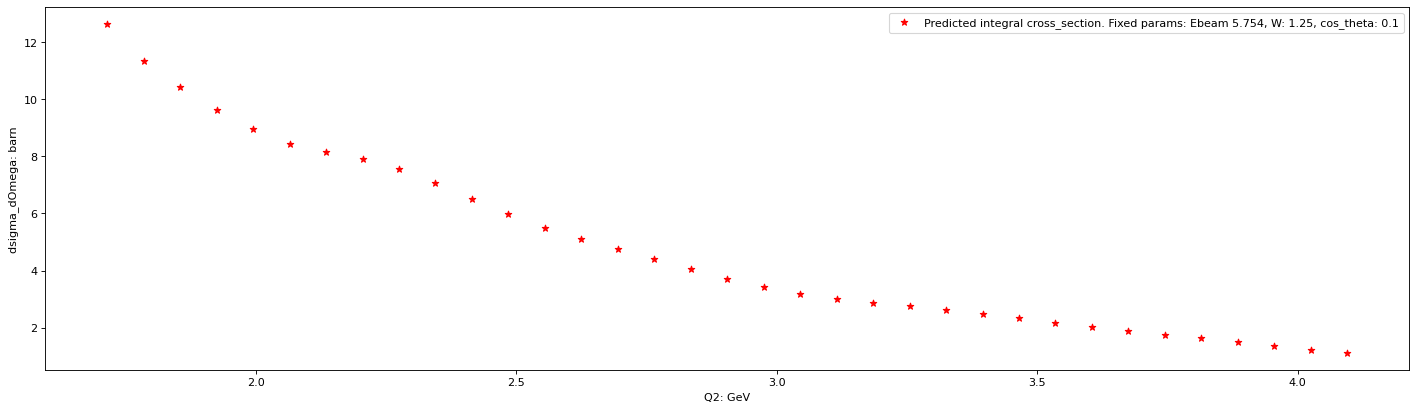

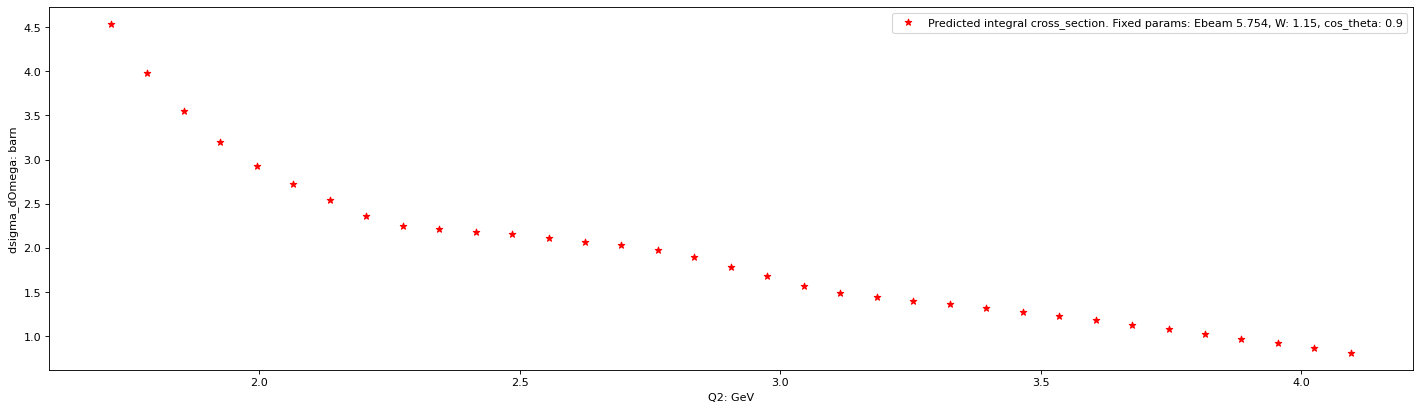

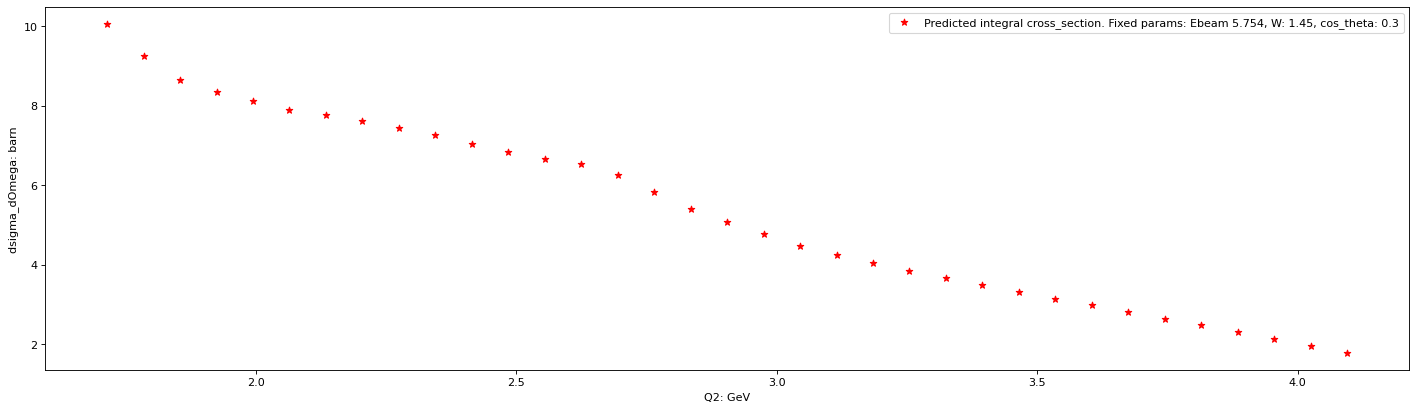

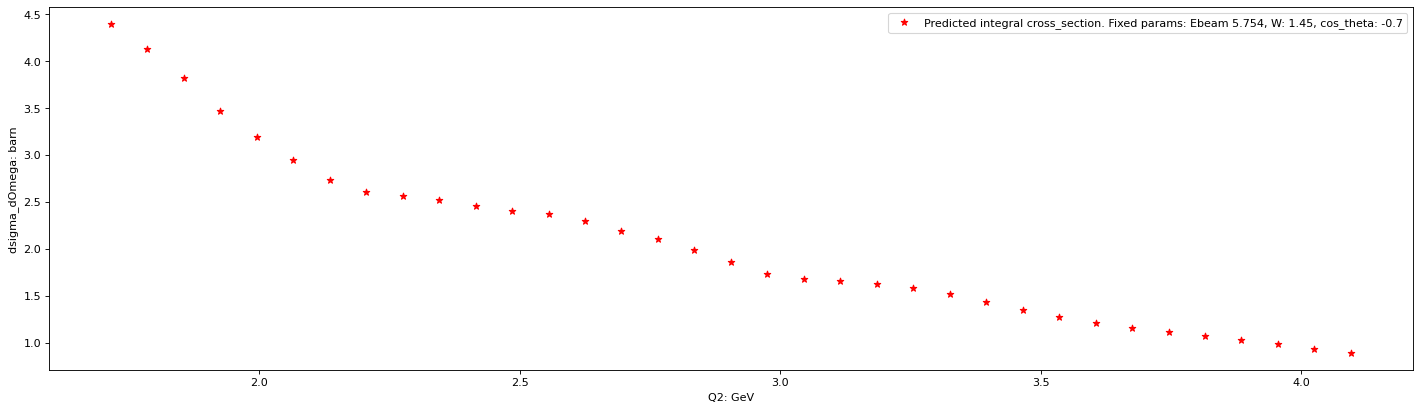

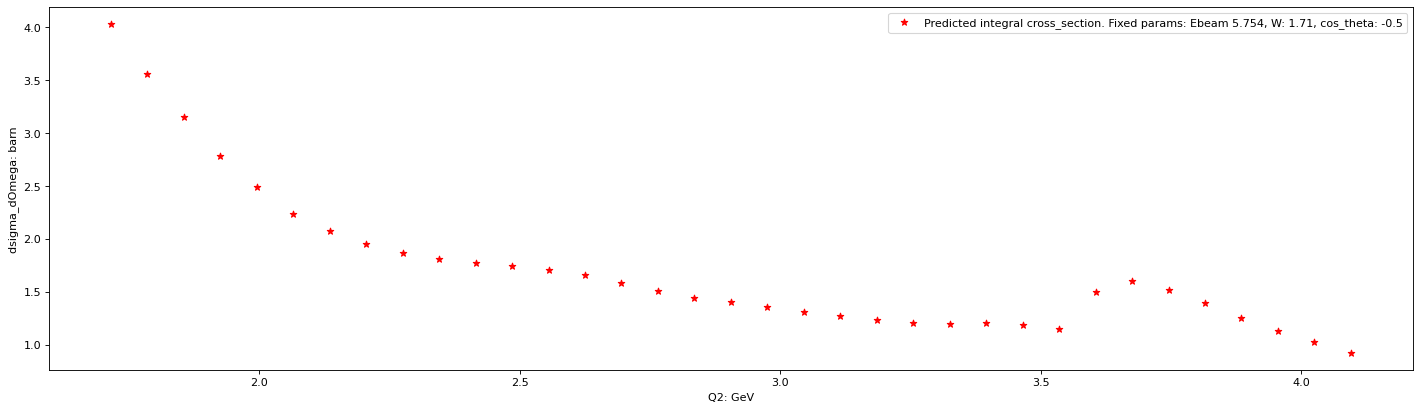

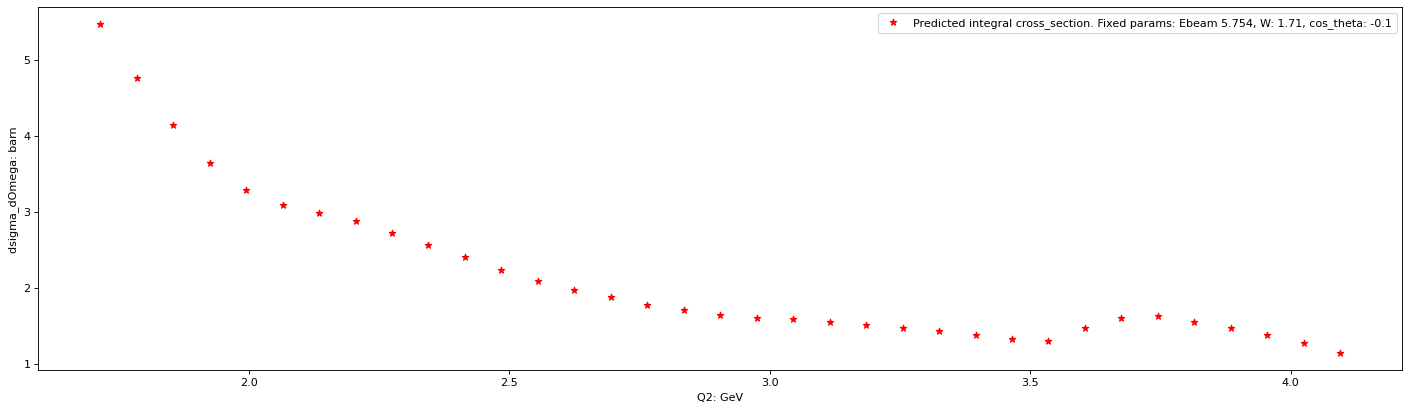

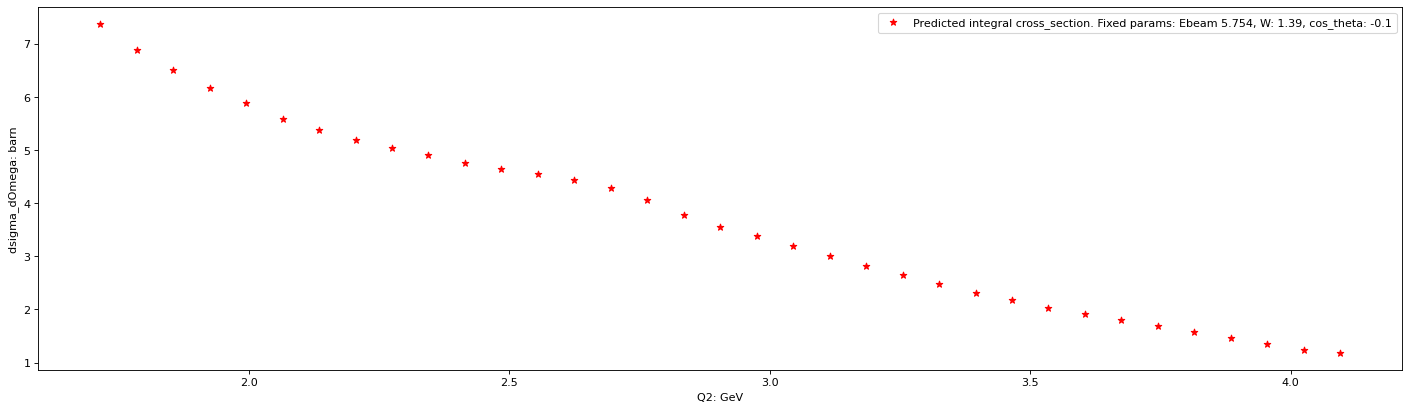

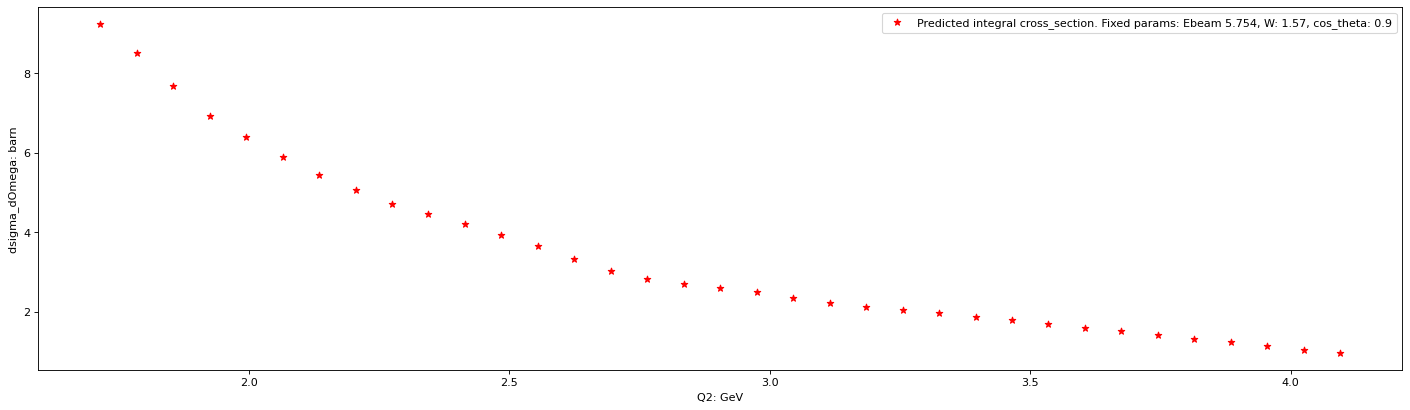

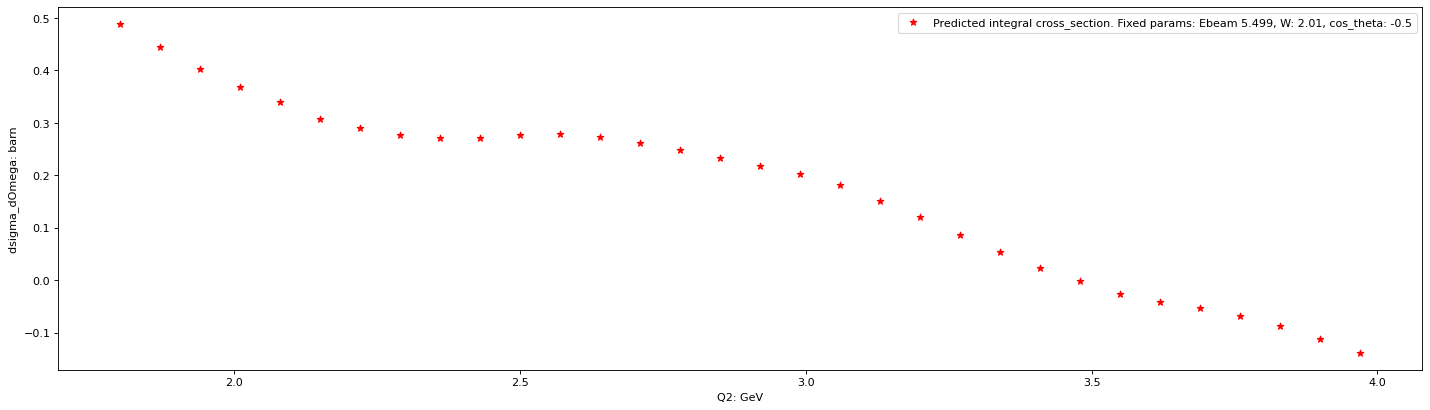

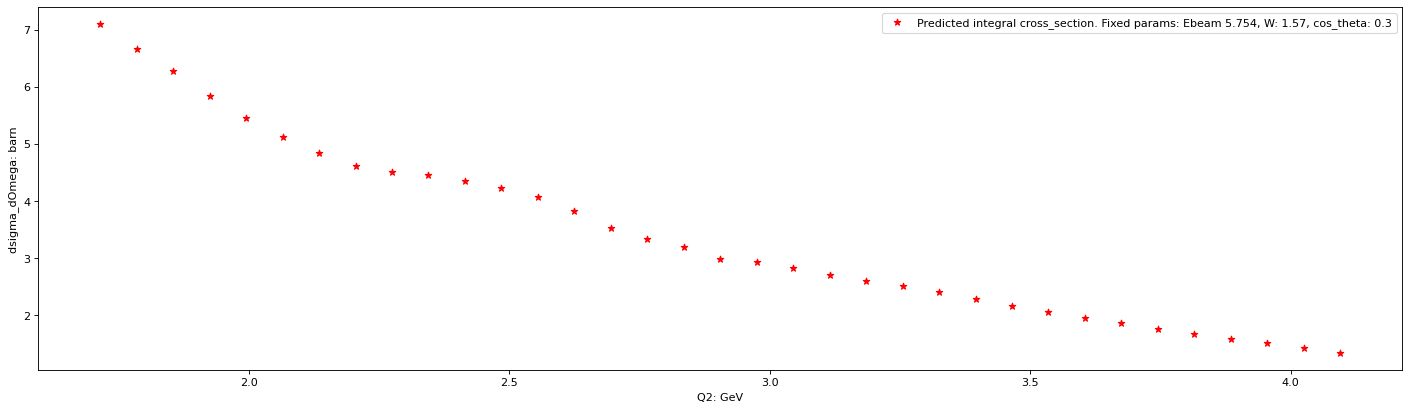

In [142]:
for _ in range(10):
    integral_cross_section_q_sqrd()

# dsigma_dOmega as a function of W

In [61]:
def integral_cross_section_W_Q2():
    rand_n = randint(0, len(df))
    grid_step_phi = 0.001
    grid_step_q2 = 0.5

    example = df.iloc[rand_n]
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')

    phi_grid = np.arange(0, 2*np.pi, grid_step_phi)
    W_grid = np.sort(df_example_set.W.unique())
    Q2_grid = np.arange(df_example_set.Q2.min(), df_example_set.Q2.max(), grid_step_q2)



    final_list = []

    for j in range(len(Q2_grid)):
        for i in range(len(W_grid)):
            one_set = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in range(len(phi_grid))],
                                     'W' :  [W_grid[i] for _ in range(len(phi_grid))],
                                     'Q2' : [Q2_grid[j] for _ in range(len(phi_grid))],
                                     'cos_theta' : [example['cos_theta'] for _ in range(len(phi_grid))],
                                     'phi' : phi_grid})

            one_set = torch.tensor(scaler_feature.transform(one_set)).to(torch.float32)

            with torch.no_grad():
                one_predictions_set = model(one_set)
                one_predictions_set = scaler_target.inverse_transform(one_predictions_set)

            final_list.append({'Ebeam' : example['Ebeam'],
                                'W' :  W_grid[i],
                                'Q2' : Q2_grid[j],
                                'cos_theta' : example['cos_theta'],
                                'phi' : 'all_phi',
                                'dsigma_dOmega' : np.trapz(one_predictions_set.flatten(), dx=grid_step_phi)})

        cross_sections_int = [element['dsigma_dOmega'] for element in final_list]


    df_final_list = pd.DataFrame(final_list)

    plt.figure(figsize=(22, 6), dpi=80)
    for j in range(len(Q2_grid)):
        plt.scatter(x=W_grid, 
                    y=df_final_list[df_final_list.Q2 == Q2_grid[j]]['dsigma_dOmega'], 
                    marker='*', label=f"Predicted integral cross_section. Fixed params: Ebeam {example['Ebeam']}, Q2: {np.round(Q2_grid[j],2)}, cos_theta: {example['cos_theta']}")

    plt.xlabel("W: GeV")
    plt.ylabel("dsigma_dOmega: barn")

    plt.legend()
    plt.show()

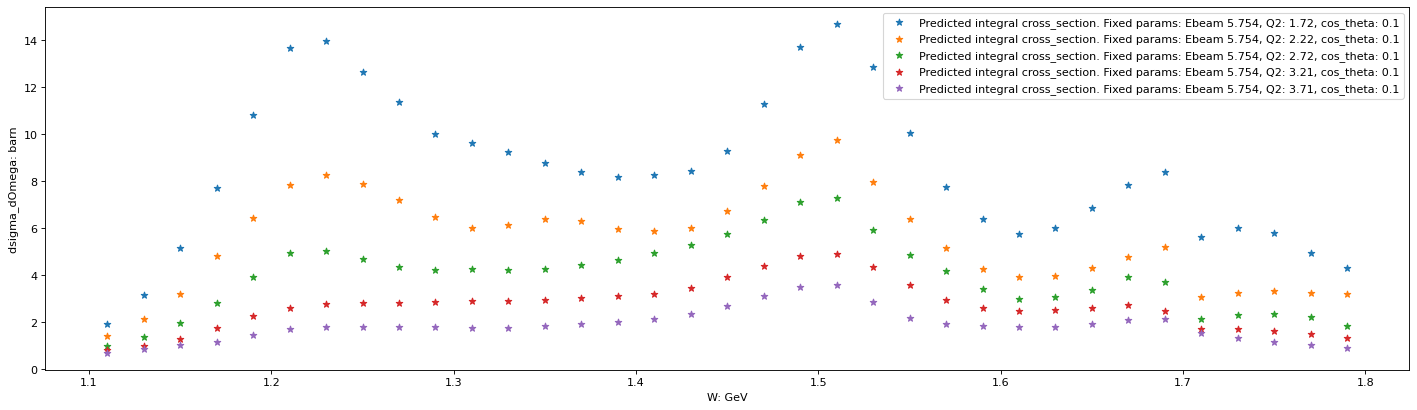

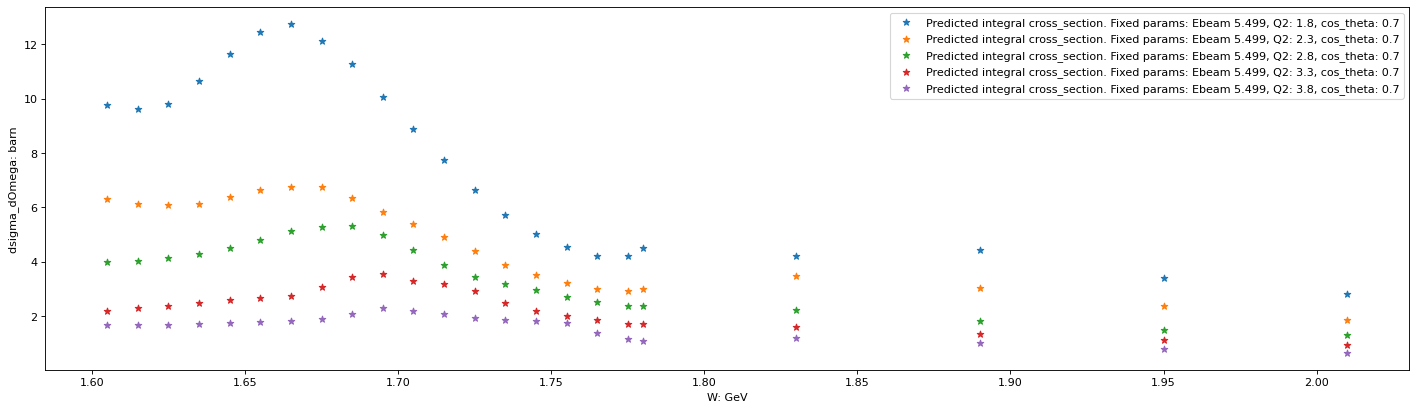

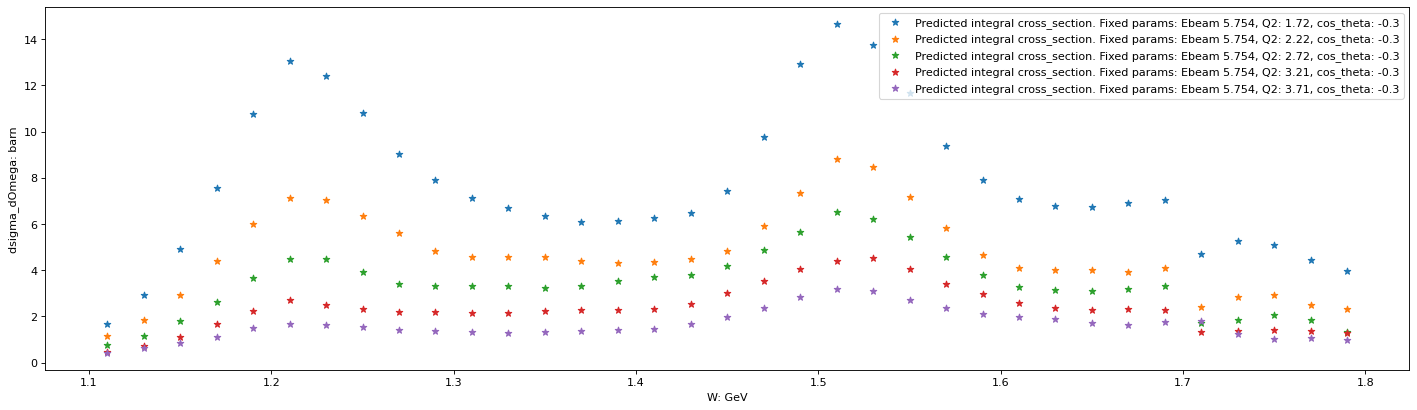

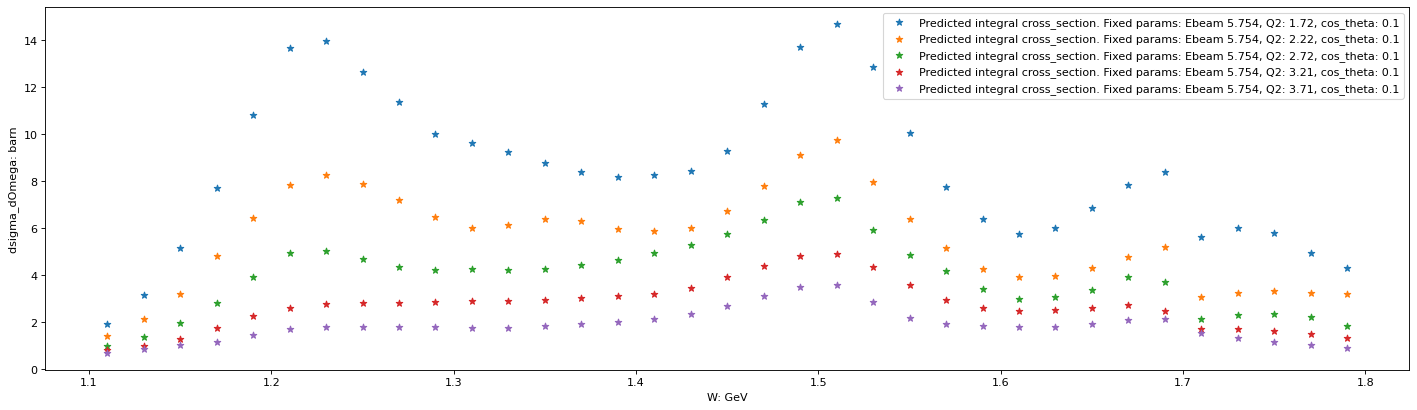

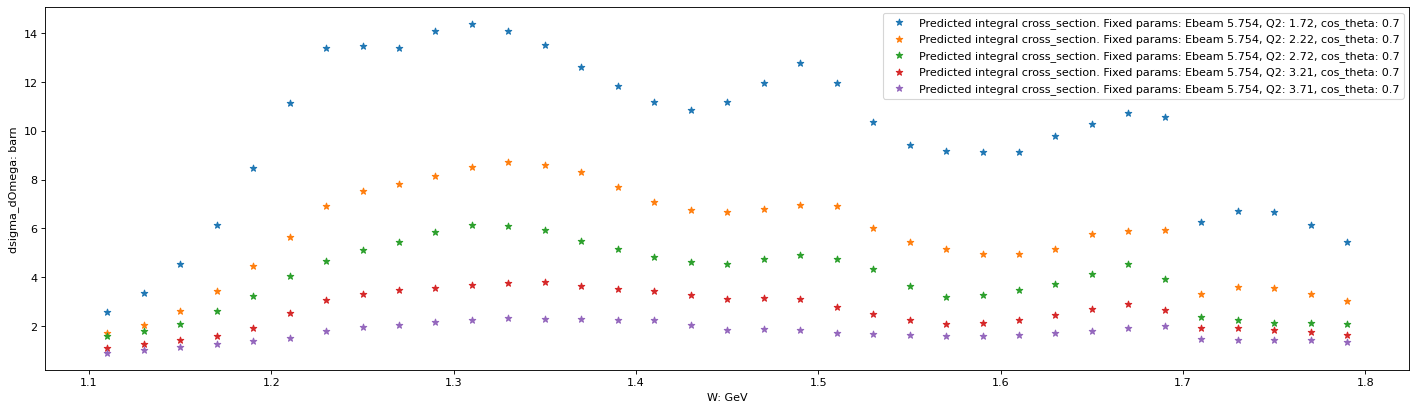

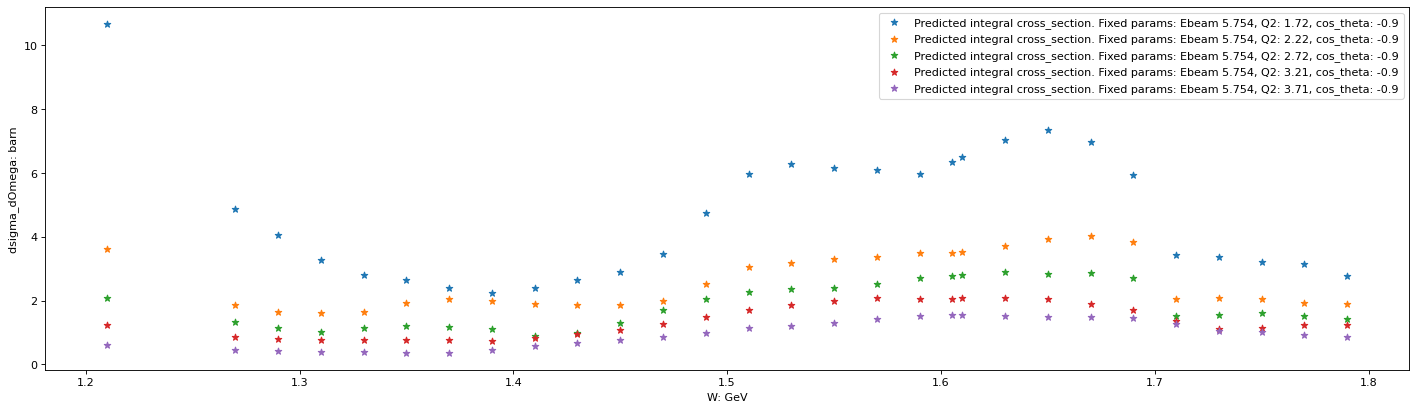

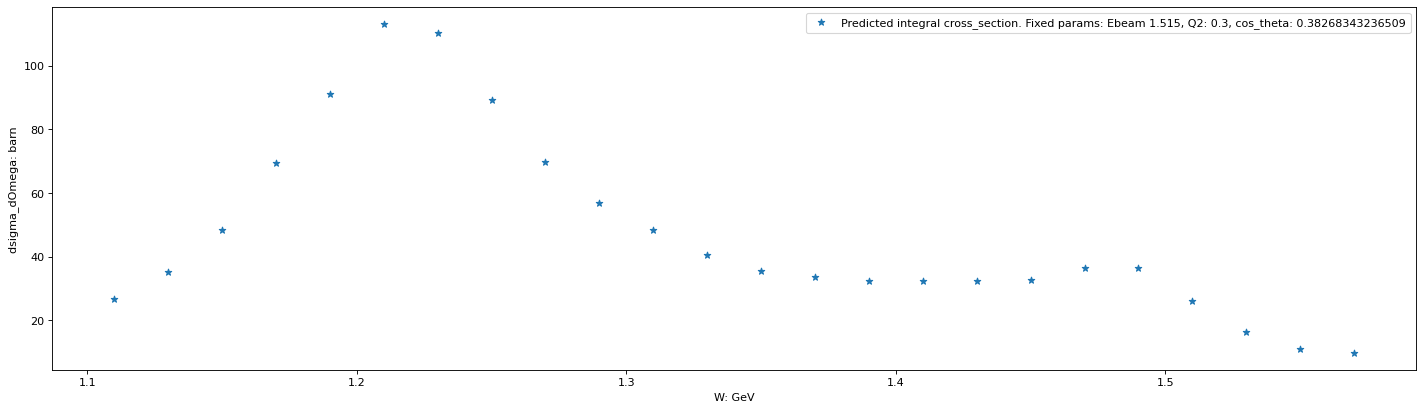

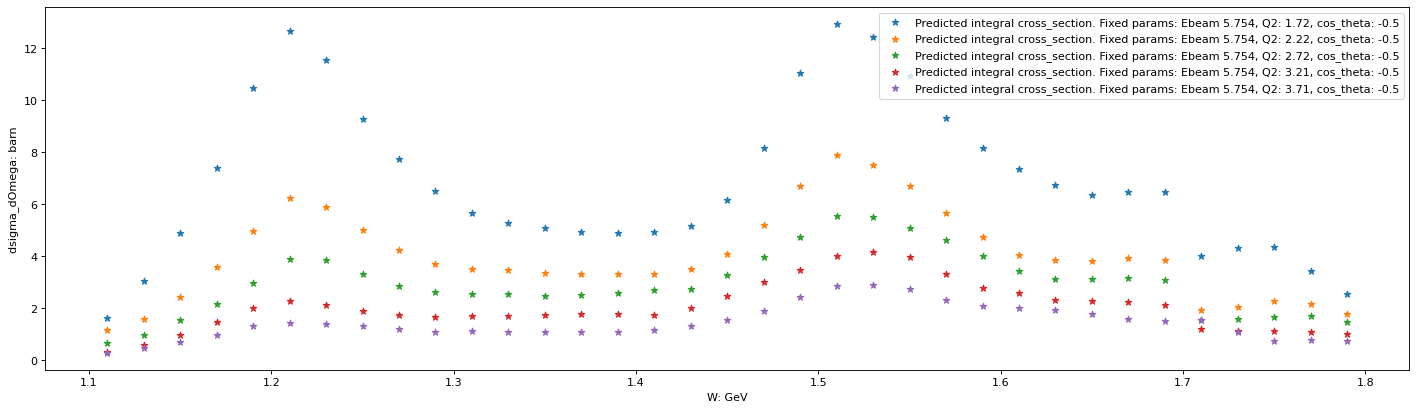

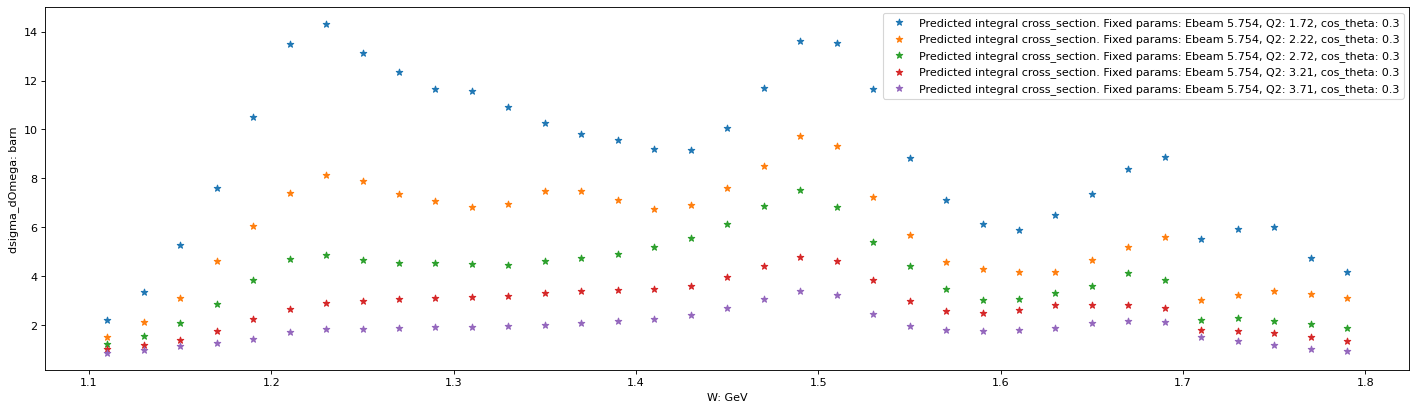

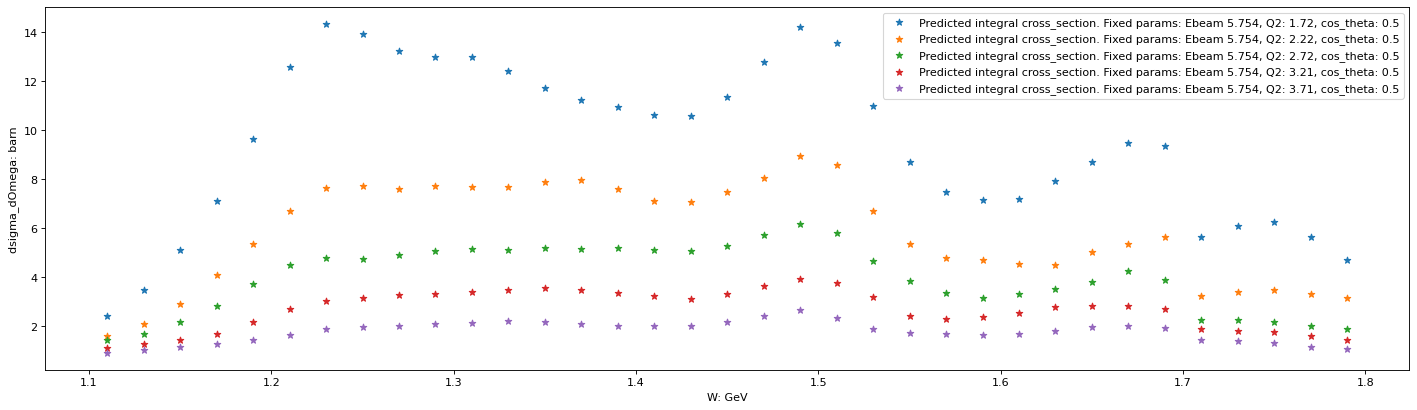

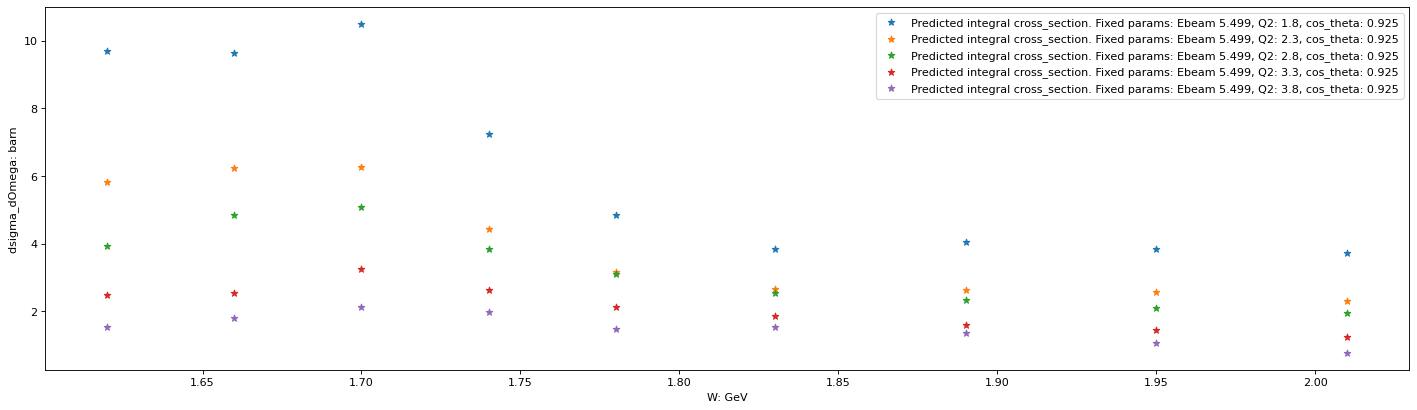

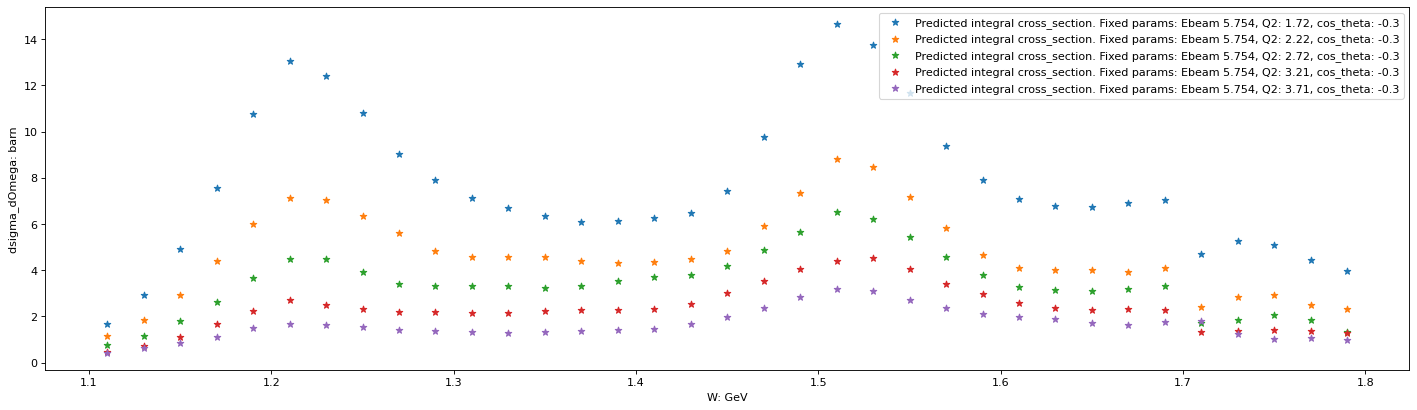

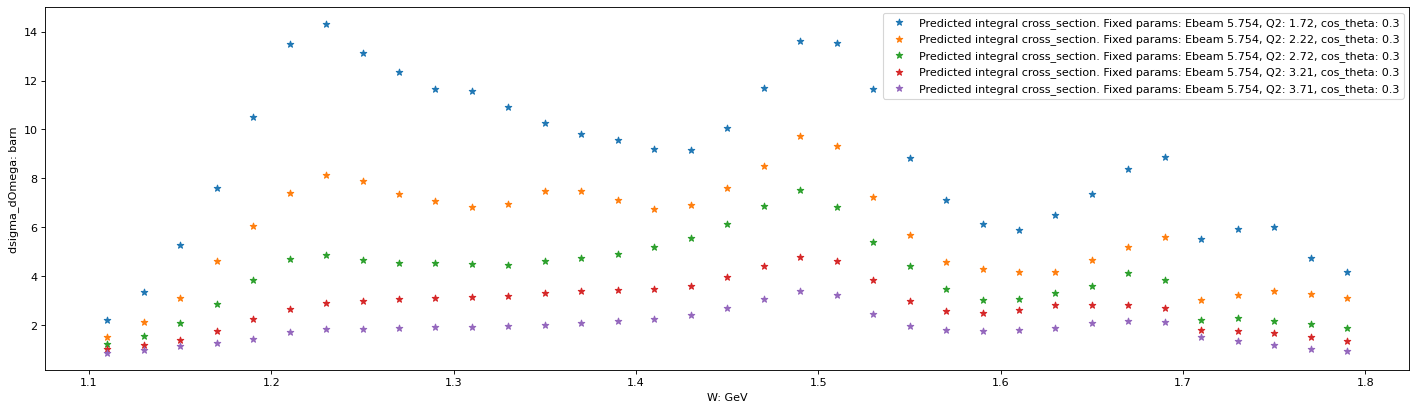

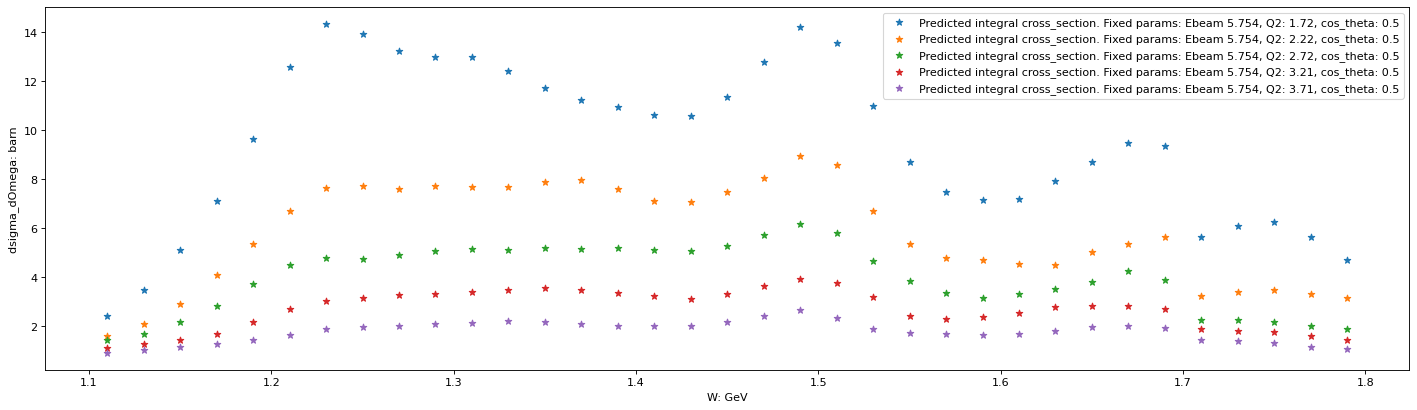

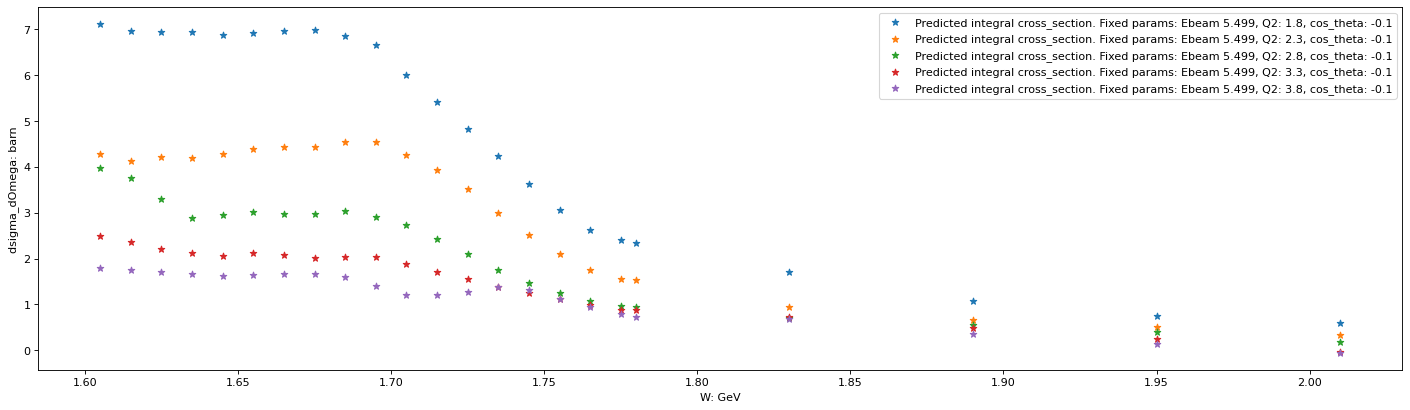

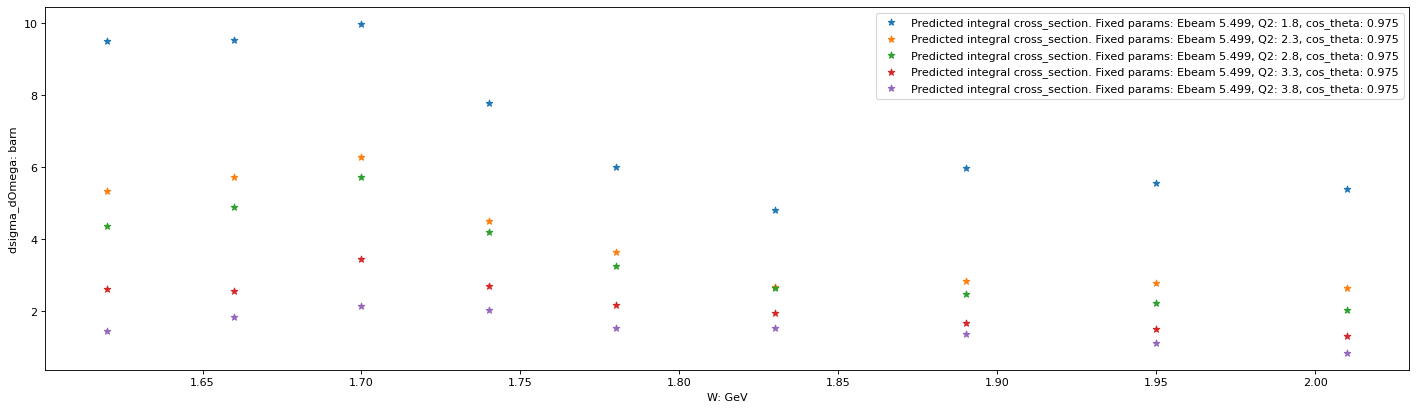

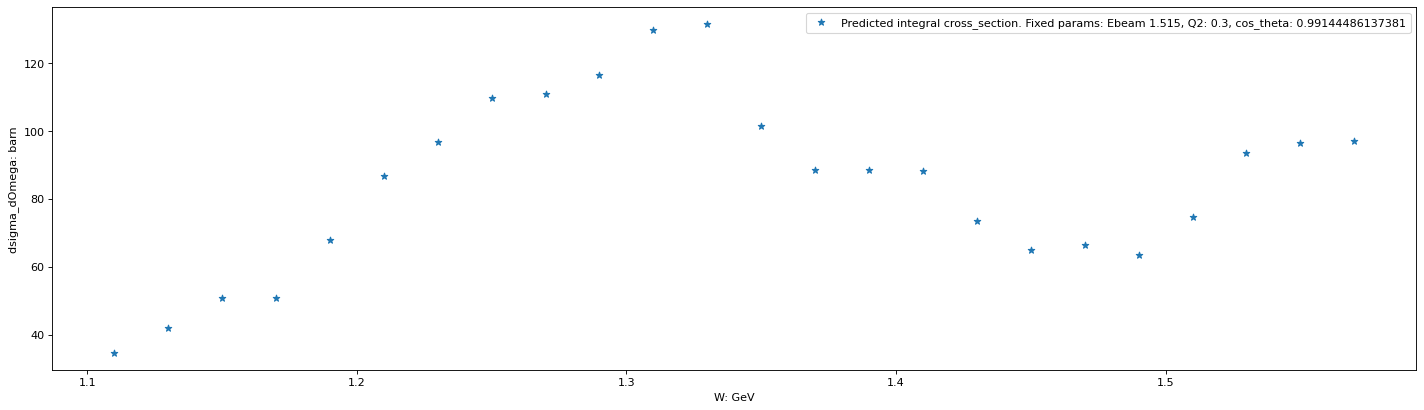

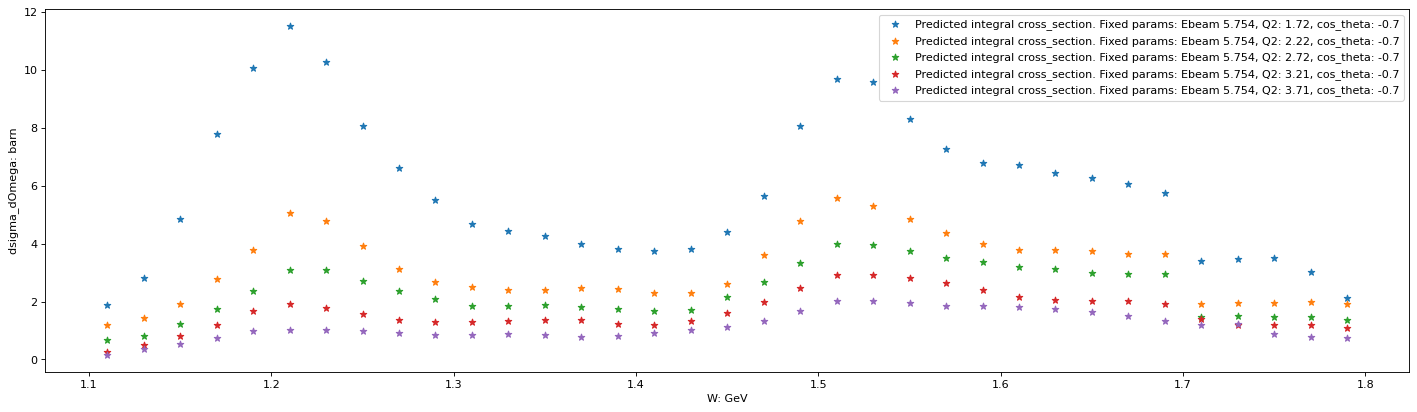

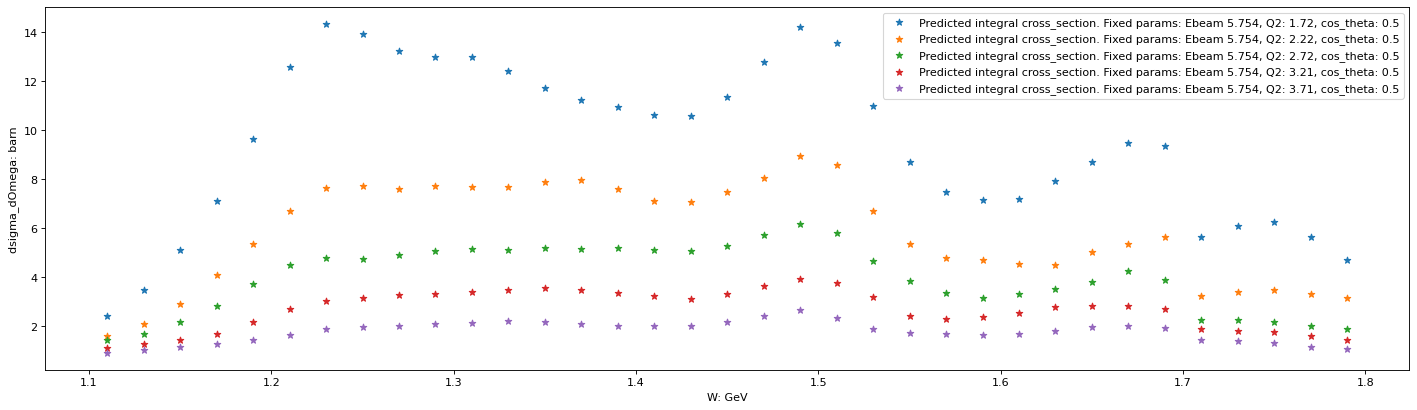

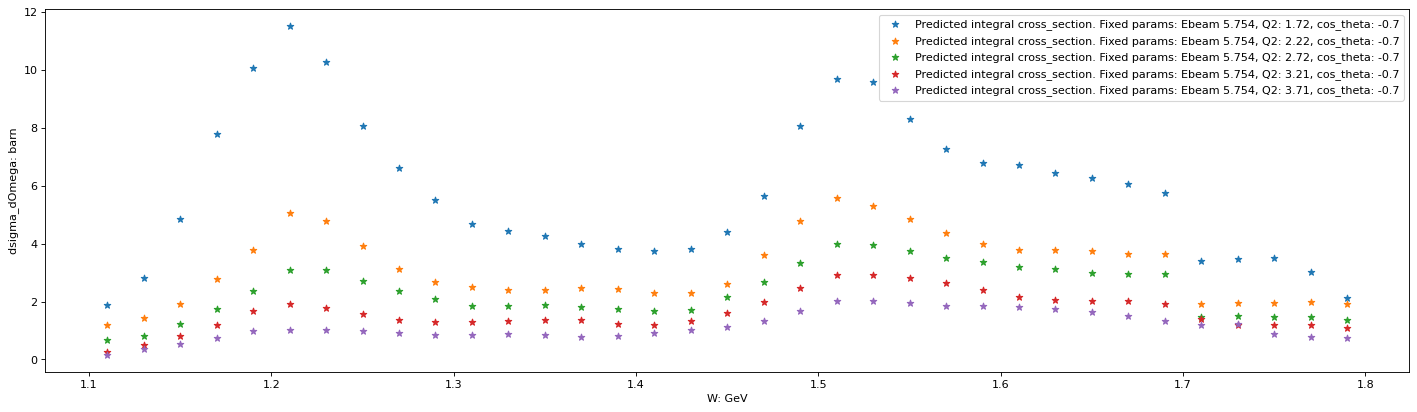

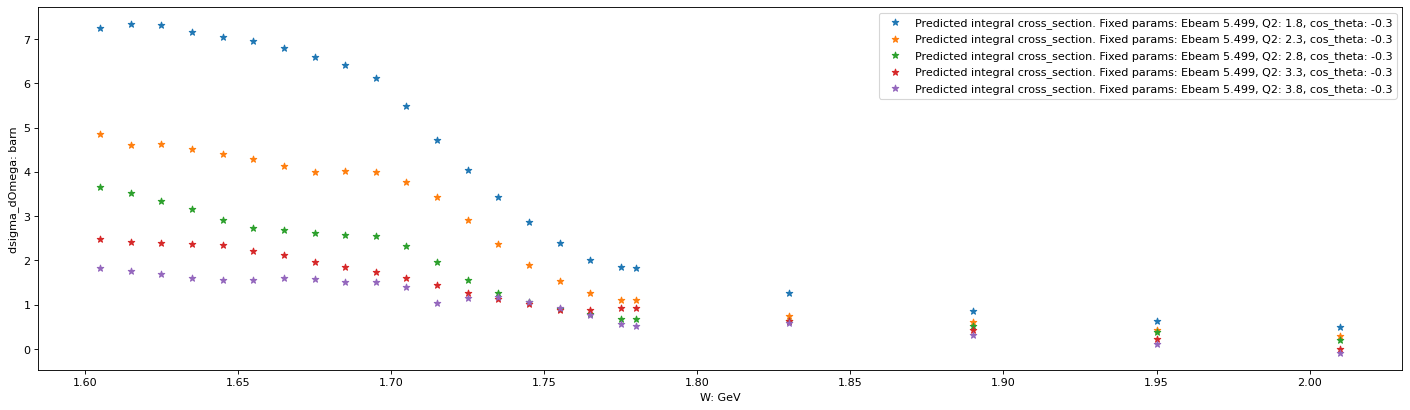

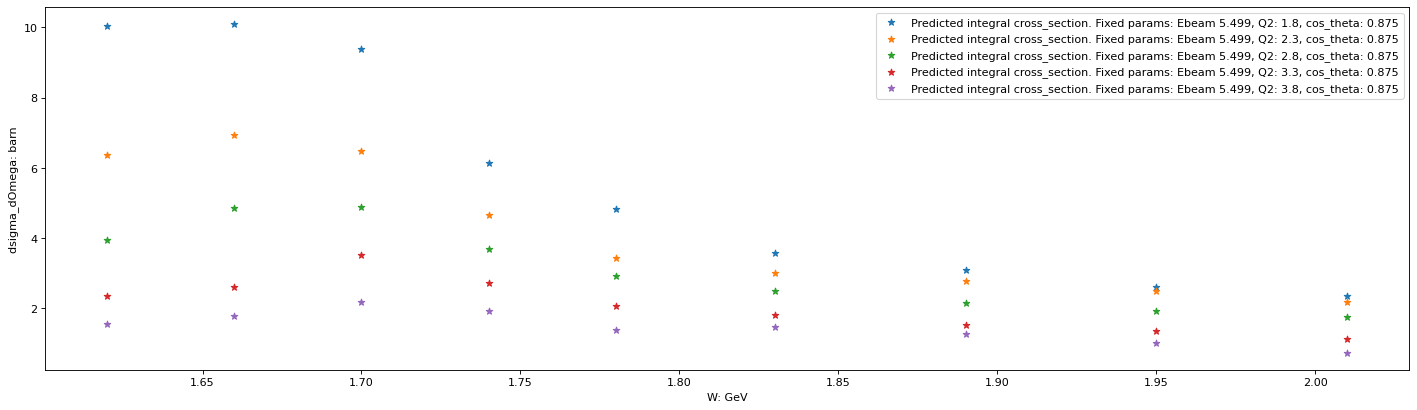

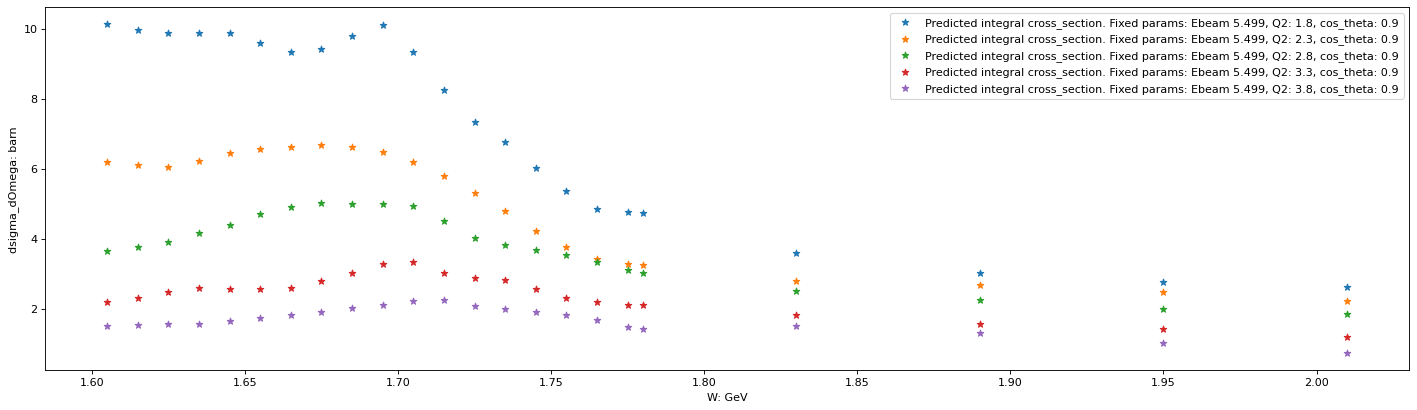

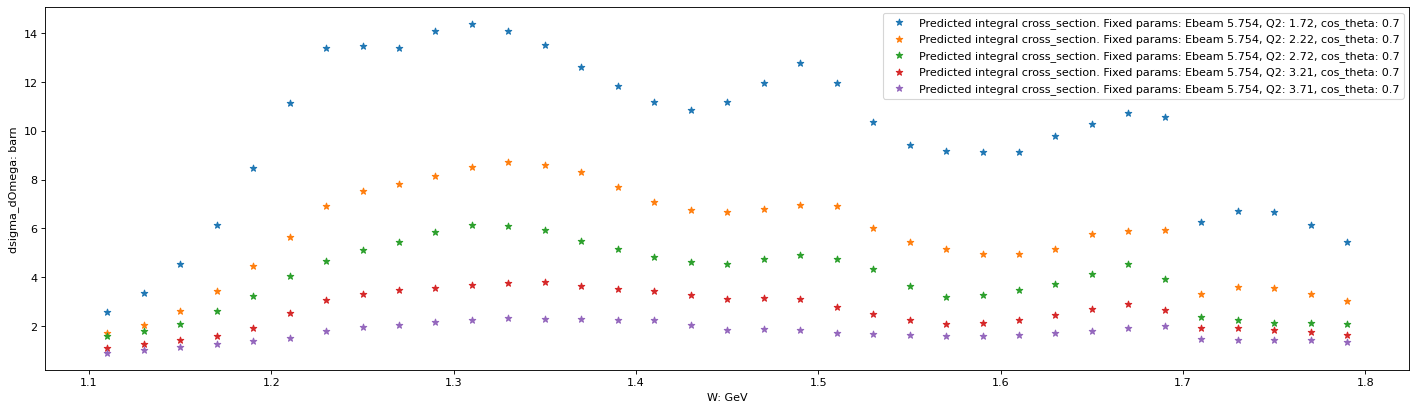

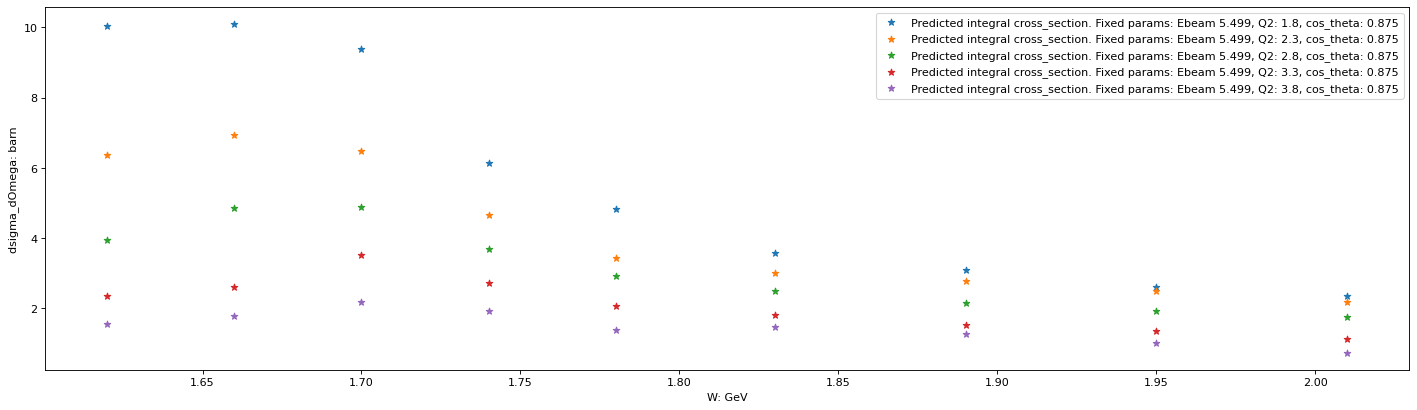

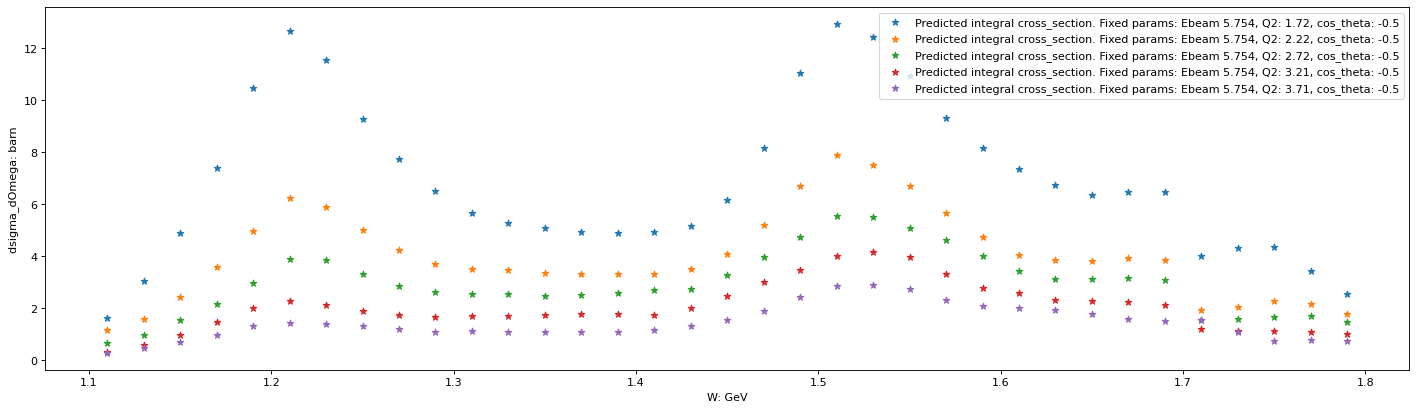

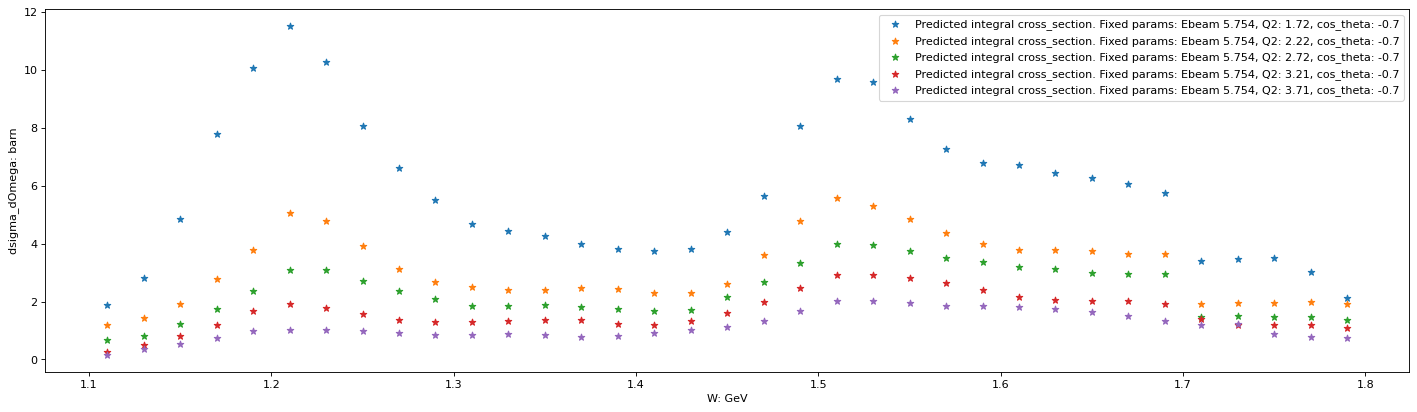

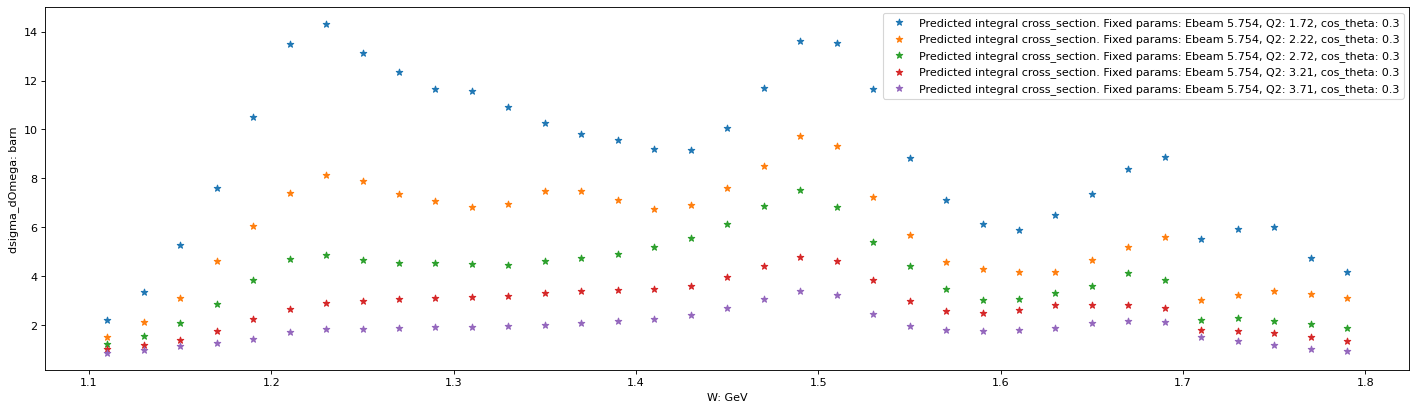

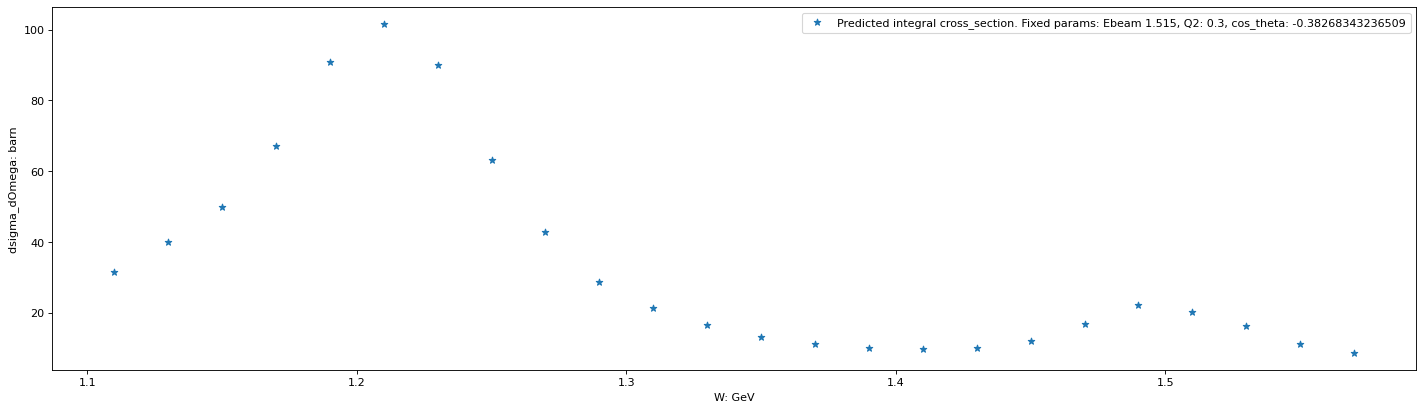

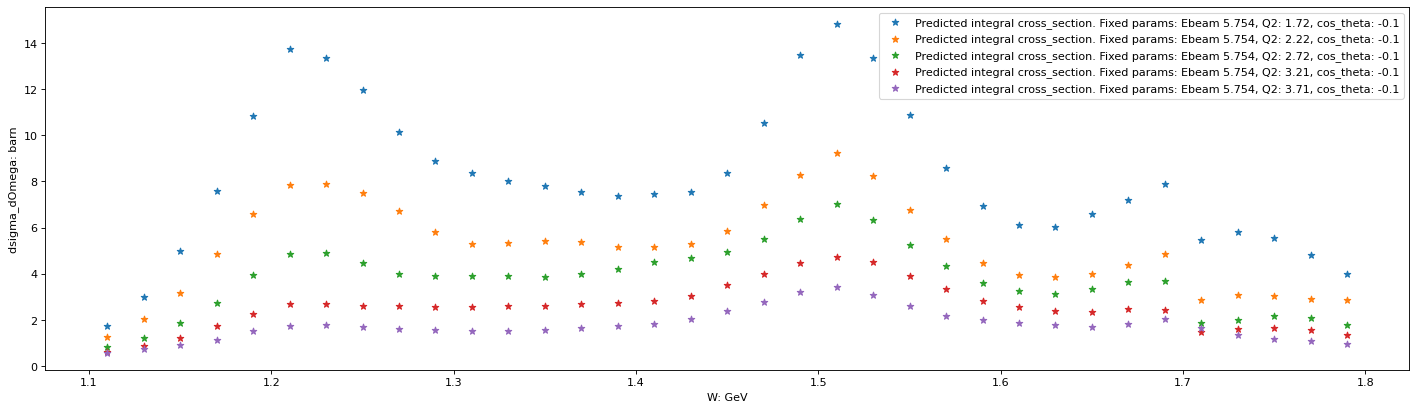

In [66]:
for _ in range(30):
    integral_cross_section_W_Q2()

model(0.300, 0.793353340291235, 1.515, 0, 1.1,  )

F(Ebeam	W	Q2	cos_theta	phi) --> dsigma_dOmega

F(1.515	1.1	0.300	0.793353340291235	phi) -> dsigma_dOmega[1]

0, 0.01, ...           2pi ----phi

1.1, 0.01                      1.6  ----W

Q2, cos_theta, E_beam - fixed
W, phi()


W, cos_theta, E_beam - fixed
Q2, phi()